In [44]:
import os
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, classification_report, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import warnings

from utils.dataset import get_df, generate_column_names

warnings.filterwarnings("ignore")

In [2]:
X_train_16, X_val_16, X_test_16, y_train_16, y_val_16, y_test_16 = get_df(window_size=16)
X_train_32, X_val_32, X_test_32, y_train_32, y_val_32, y_test_32 = get_df(window_size=32)
X_train_48, X_val_48, X_test_48, y_train_48, y_val_48, y_test_48 = get_df(window_size=48)

In [45]:
X_train_16

nvda_open_t-0  nvda_high_t-0  nvda_low_t-0  \
timestamp                                                               
2022-03-04 00:00:00+00:00        23.7230        23.7489       23.4690   
2022-03-04 09:00:00+00:00        23.2657        23.3606       23.2118   
2022-03-04 10:00:00+00:00        23.2408        23.4294       23.2408   
2022-03-04 11:00:00+00:00        23.3106        23.3606       23.1958   
2022-03-04 12:00:00+00:00        23.2707        23.3596       23.0102   
...                                  ...            ...           ...   
2024-06-28 19:00:00+00:00       124.2146       124.6444      122.7500   
2024-06-28 20:00:00+00:00       123.7547       123.8447      122.9428   
2024-06-28 21:00:00+00:00       123.7347       123.8547      123.4948   
2024-06-28 22:00:00+00:00       123.7447       123.7947      123.6248   
2024-06-28 23:00:00+00:00       123.6348       123.7947      123.6148   

                           nvda_close_t-0  nvda_volume_t-0  amd_open_t-0  \
timestamp                                                                  
2022-03-04 00:00:00+00:00         23.4690        1065750.0        112.30   
2022-03-04 09:00:00+00:00         23.2308         192780.0        110.90   
2022-03-04 10:00:00+00:00         23.2907          26040.0        110.50   
2022-03-04 11:00:00+00:00         23.2837          99220.0        110.41   
2022-03-04 12:00:00+00:00         23.2008         637530.0        110.60   
...                                   ...              ...           ...   
2024-06-28 19:00:00+00:00        123.3649       42202182.0        162.10   
2024-06-28 20:00:00+00:00        123.7347       84521822.0        162.21   
2024-06-28 21:00:00+00:00        123.7546        2801658.0        162.41   
2024-06-28 22:00:00+00:00        123.6298         252972.0        162.43   
2024-06-28 23:00:00+00:00        123.7049         365138.0        162.25   

                           amd_high_t-0  amd_low_t-0  amd_close_t-0  \
timestamp                                                             
2022-03-04 00:00:00+00:00        112.38       111.05        111.050   
2022-03-04 09:00:00+00:00        111.30       109.50        110.500   
2022-03-04 10:00:00+00:00        111.31       110.40        110.410   
2022-03-04 11:00:00+00:00        111.00       110.18        111.000   
2022-03-04 12:00:00+00:00        110.65       109.60        110.150   
...                                 ...          ...            ...   
2024-06-28 19:00:00+00:00        162.68       160.50        162.210   
2024-06-28 20:00:00+00:00        164.08       161.90        162.210   
2024-06-28 21:00:00+00:00        162.55       162.21        162.460   
2024-06-28 22:00:00+00:00        162.54       162.25        162.315   
2024-06-28 23:00:00+00:00        162.50       162.17        162.200   

                           amd_volume_t-0  ...  stoch_d_t-15  macd_t-15  \
timestamp                                  ...                            
2022-03-04 00:00:00+00:00        238563.0  ...     58.122658   0.071580   
2022-03-04 09:00:00+00:00         32734.0  ...     58.160142   0.066487   
2022-03-04 10:00:00+00:00          7239.0  ...     57.713734   0.061739   
2022-03-04 11:00:00+00:00         11440.0  ...     58.284334   0.065117   
2022-03-04 12:00:00+00:00         89630.0  ...     62.239256   0.083822   
...                                   ...  ...           ...        ...   
2024-06-28 19:00:00+00:00       6295016.0  ...     41.927550  -0.166160   
2024-06-28 20:00:00+00:00      11507575.0  ...     38.377650  -0.179979   
2024-06-28 21:00:00+00:00         47693.0  ...     35.566427  -0.180387   
2024-06-28 22:00:00+00:00         20122.0  ...     35.285876  -0.149941   
2024-06-28 23:00:00+00:00         20996.0  ...     40.438886  -0.097264   

                           macd_signal_t-15  macd_hist_t-15  sma_14_t-15  \
timestamp                                                                  
2022-03-04 00:00:00+00:00          0

In [46]:
PRICE_NVDA_COLS = ["nvda_close", "nvda_volume"]
PRICE_AMD_COLS = ["amd_close", "amd_volume"]
PRICE_INTC_COLS = ["intc_close", "intc_volume"]
PRICE_SPY_COLS = ["spy_close", "spy_volume"]
PRICE_DIA_COLS = ["dia_close", "dia_volume"]
PRICE_IWM_COLS = ["iwm_close", "iwm_volume"]
PRICE_BTC_COLS = ["btc_close", "btc_volume"]
PRICE_GOLD_COLS = ["gold_close", "gold_volume"]


COLS_GROUPS = {
    "price_amd": PRICE_NVDA_COLS + PRICE_AMD_COLS,
    "price_intc": PRICE_NVDA_COLS + PRICE_INTC_COLS,
    "price_spy": PRICE_NVDA_COLS + PRICE_SPY_COLS,
    "price_dia": PRICE_NVDA_COLS + PRICE_DIA_COLS,
    "price_iwm": PRICE_NVDA_COLS + PRICE_IWM_COLS,
    "price_btc": PRICE_NVDA_COLS + PRICE_BTC_COLS,
    "price_gold": PRICE_NVDA_COLS + PRICE_GOLD_COLS,
    "price_all_stocks": PRICE_NVDA_COLS + PRICE_AMD_COLS + PRICE_INTC_COLS,
    "price_all_etf": PRICE_NVDA_COLS + PRICE_SPY_COLS + PRICE_DIA_COLS + PRICE_IWM_COLS,
    "price_all_alt": PRICE_NVDA_COLS + PRICE_BTC_COLS + PRICE_GOLD_COLS,
    "price_all_market": PRICE_NVDA_COLS
    + PRICE_AMD_COLS
    + PRICE_INTC_COLS
    + PRICE_SPY_COLS
    + PRICE_DIA_COLS
    + PRICE_IWM_COLS
    + PRICE_BTC_COLS
    + PRICE_GOLD_COLS,
}

WINDOW_SIZES_DATA_DATA = {
    16: (X_train_16, X_val_16, X_test_16, y_train_16, y_val_16, y_test_16),
    32: (X_train_32, X_val_32, X_test_32, y_train_32, y_val_32, y_test_32),
    48: (X_train_48, X_val_48, X_test_48, y_train_48, y_val_48, y_test_48),
}

MODELS = [
    "GaussianNB",
    "RandomForestClassifier",
    "XGBClassifier",
    "LGBMClassifier",
]


In [47]:
pipelines = {}
metrics_val = {}
metrics_test = {}

for window_size in WINDOW_SIZES_DATA_DATA.keys():
    X_train, X_val, X_test, y_train, y_val, y_test = WINDOW_SIZES_DATA_DATA[window_size]
    for col_group_name, col_group in COLS_GROUPS.items():
        for model_name in MODELS:
            scaler = MinMaxScaler()
            if model_name == "GaussianNB":
                model = GaussianNB()
            elif model_name == "RandomForestClassifier":
                model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            elif model_name == "XGBClassifier":
                model = XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1)
            elif model_name == "LGBMClassifier":
                params = {
                    "objective": "binary",  # For binary classification
                    "metric": "binary_logloss",  # Evaluation metric
                    "boosting_type": "gbdt",
                    "num_leaves": 31,
                    "learning_rate": 0.05,
                    "feature_fraction": 0.9,
                    "verbose": -1,  # Suppress verbose output
                }
                model = LGBMClassifier(**params, random_state=42, n_jobs=-1)
            else:
                raise ValueError(f"Unknown model name: {model_name}")
            pipeline = Pipeline([("scaler", scaler), ("classifier", model)])
            col_to_use = generate_column_names(col_group, window_size)

            start_time = time.time()
            pipeline.fit(X_train[col_to_use], y_train)
            end_time = time.time()
            y_pred = pipeline.predict(X_val[col_to_use])
            y_pred_proba = pipeline.predict_proba(X_val[col_to_use])[:, 1]
            train_time = end_time - start_time

            report_dict = classification_report(
                y_val,
                y_pred,
                # 0 = Down, 1 = Up
                target_names=["Down", "Up"],
                zero_division=0,
                output_dict=True,
            )
            report = classification_report(
                y_val,
                y_pred,
                # 0 = Down, 1 = Up
                target_names=["Down", "Up"],
                zero_division=0,
                output_dict=False,
            )

            fpr, tpr, _ = roc_curve(
                y_val,
                y_pred_proba,
            )
            auc_score = auc(fpr, tpr)

            pipelines[(window_size, col_group_name, model_name)] = pipeline
            metrics_val[(window_size, col_group_name, model_name)] = {
                "time_used": train_time,
                "classification_report": report_dict,
                "classification_report_str": report,
                "roc_auc": {
                    "fpr": fpr.tolist(),
                    "tpr": tpr.tolist(),
                    "auc_score": auc_score,
                },
                "col_used": col_group,
            }
            print(
                f"Completed: Window Size={window_size}, Col Group={col_group_name}, Model={model_name} in {train_time:.2f} seconds"
            )

model_dir = "2_market_context_feature_analysis"
os.makedirs(model_dir, exist_ok=True)
# Save eentire pipelines and metrics dictionaries
joblib.dump(pipelines, model_dir + "/pipelines.joblib")
joblib.dump(metrics_val, model_dir + "/metrics.joblib")

Completed: Window Size=16, Col Group=price_amd, Model=GaussianNB in 0.01 seconds
Completed: Window Size=16, Col Group=price_amd, Model=RandomForestClassifier in 0.73 seconds
Completed: Window Size=16, Col Group=price_amd, Model=XGBClassifier in 0.26 seconds
Completed: Window Size=16, Col Group=price_amd, Model=LGBMClassifier in 0.15 seconds
Completed: Window Size=16, Col Group=price_intc, Model=GaussianNB in 0.01 seconds
Completed: Window Size=16, Col Group=price_intc, Model=RandomForestClassifier in 0.71 seconds
Completed: Window Size=16, Col Group=price_intc, Model=XGBClassifier in 0.27 seconds
Completed: Window Size=16, Col Group=price_intc, Model=LGBMClassifier in 0.15 seconds
Completed: Window Size=16, Col Group=price_spy, Model=GaussianNB in 0.02 seconds
Completed: Window Size=16, Col Group=price_spy, Model=RandomForestClassifier in 0.77 seconds
Completed: Window Size=16, Col Group=price_spy, Model=XGBClassifier in 0.29 seconds
Completed: Window Size=16, Col Group=price_spy, Mode

['2_market_context_feature_analysis/metrics.joblib']

In [48]:
len(pipelines)

132

In [49]:
pipelines_loaded = joblib.load("2_market_context_feature_analysis/pipelines.joblib")
metrics_loaded = joblib.load("2_market_context_feature_analysis/metrics.joblib")

In [50]:
for window_size in WINDOW_SIZES_DATA_DATA.keys():
    for col_group_name, col_group in list(COLS_GROUPS.items()):
        for model_name in MODELS:
            print("Window Size:", window_size, "Col Group:", col_group_name, "Model:", model_name)
            print(metrics_loaded[(window_size, col_group_name, model_name)]["classification_report_str"])

Window Size: 16 Col Group: price_amd Model: GaussianNB
              precision    recall  f1-score   support

        Down       0.58      0.01      0.02      1106
          Up       0.46      0.99      0.63       933

    accuracy                           0.46      2039
   macro avg       0.52      0.50      0.33      2039
weighted avg       0.53      0.46      0.30      2039

Window Size: 16 Col Group: price_amd Model: RandomForestClassifier
              precision    recall  f1-score   support

        Down       0.56      0.62      0.59      1106
          Up       0.49      0.43      0.46       933

    accuracy                           0.53      2039
   macro avg       0.53      0.52      0.52      2039
weighted avg       0.53      0.53      0.53      2039

Window Size: 16 Col Group: price_amd Model: XGBClassifier
              precision    recall  f1-score   support

        Down       0.56      0.59      0.57      1106
          Up       0.48      0.44      0.46       933

  

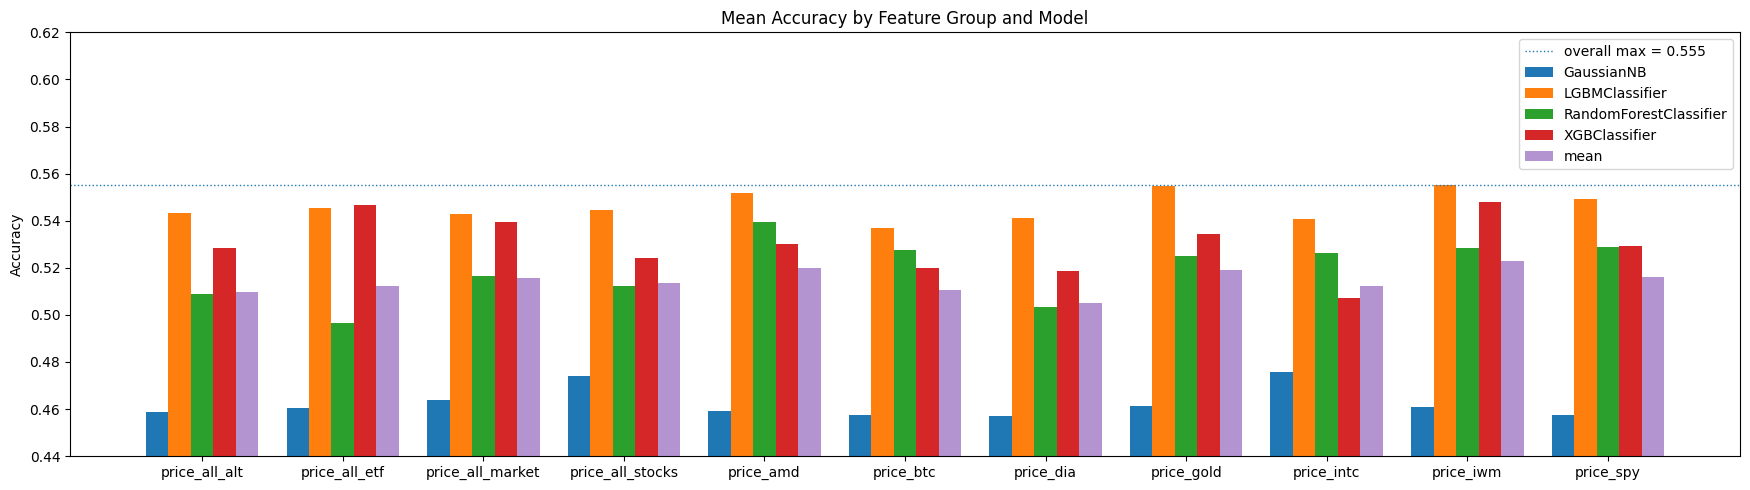

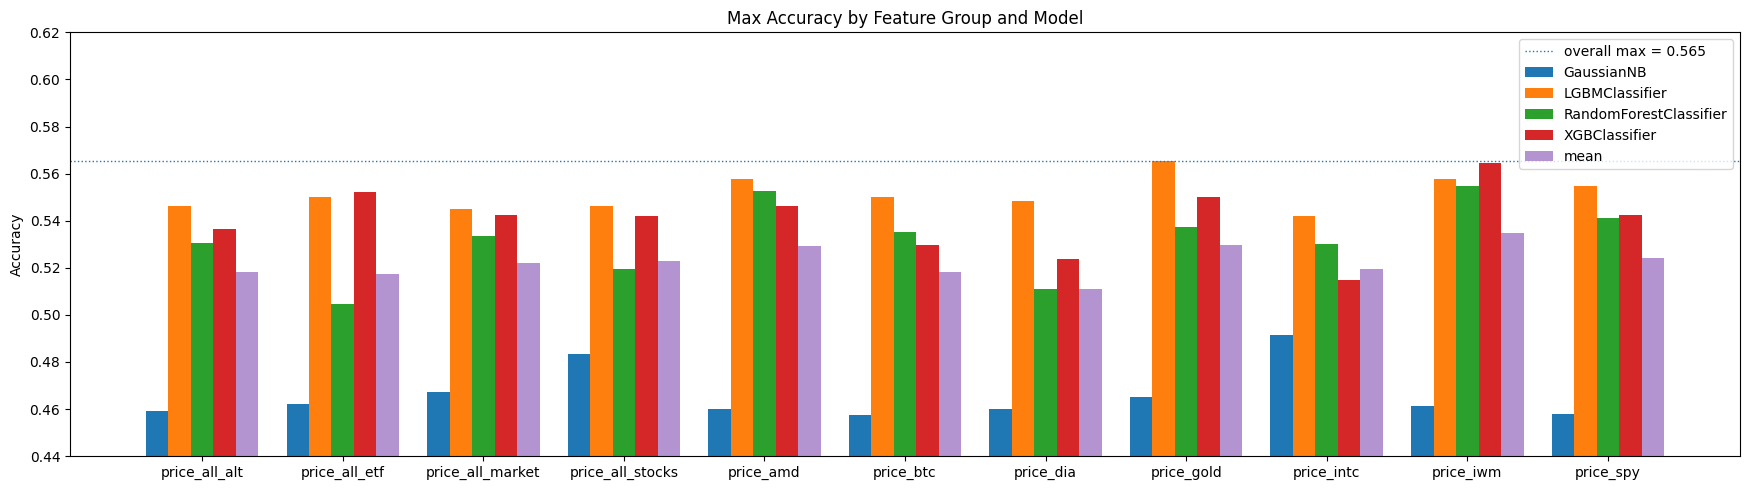

In [53]:
# Build summary DataFrame
rows = []
for window_size in WINDOW_SIZES_DATA_DATA.keys():
    for col_group_name in COLS_GROUPS.keys():
        for model_name in MODELS:
            rep = metrics_loaded[(window_size, col_group_name, model_name)]["classification_report"]
            rows.append(
                {
                    "window": window_size,
                    "col_group": col_group_name,
                    "model": model_name,
                    "accuracy": float(rep["accuracy"]),
                }
            )
df = pd.DataFrame(rows)


def plot_grouped_bars(matrix: pd.DataFrame, title: str, ylabel: str = "Accuracy", show_mean_bar=True):
    groups = list(matrix.index)  # x-axis: feature groups
    models = list(matrix.columns)  # each model is a bar series
    vals = matrix.values
    n_groups, n_models = vals.shape

    # include one extra bar for group mean or max if requested
    total_bars = n_models + (1 if show_mean_bar else 0)
    x = np.arange(n_groups)
    width = 0.8 / total_bars
    center_shift = (total_bars - 1) * width / 2

    plt.figure(figsize=(max(8, 1.6 * n_groups), 5))

    # plot bars per model
    for j, model_name in enumerate(models):
        plt.bar(x + j * width - center_shift, vals[:, j], width, label=model_name)

    # plot mean or max across models per feature group
    if show_mean_bar:
        row_mean = vals.mean(axis=1)
        j_mean = n_models
        plt.bar(x + j_mean * width - center_shift, row_mean, width, label="mean", alpha=0.7)

    # lines for groupwise and overall maxima
    overall_max = float(vals.max())
    plt.axhline(overall_max, linestyle=":", linewidth=1, label=f"overall max = {overall_max:.3f}")

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(x, groups)
    plt.ylim(0.44, 0.62)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


# Compute mean accuracy by col_group and model
pivot_mean = df.pivot_table(index="col_group", columns="model", values="accuracy", aggfunc="mean").sort_index()
plot_grouped_bars(pivot_mean, title="Mean Accuracy by Feature Group and Model")

# Compute max accuracy by col_group and model
pivot_max = df.pivot_table(index="col_group", columns="model", values="accuracy", aggfunc="max").sort_index()
plot_grouped_bars(pivot_max, title="Max Accuracy by Feature Group and Model")


<Axes: >

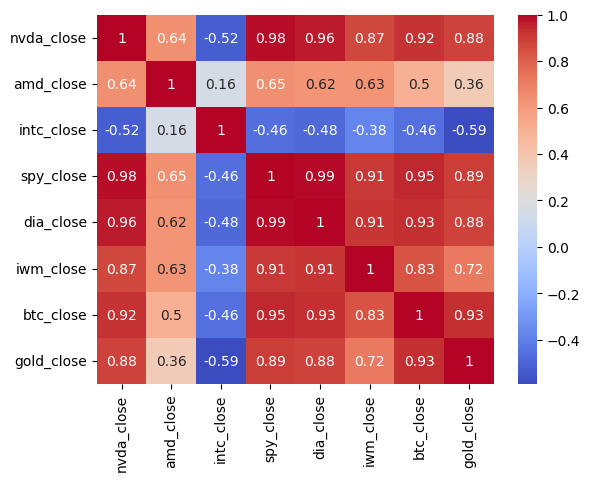

In [54]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("data/processed_data.csv", parse_dates=["timestamp"], index_col="timestamp")
cols = ["nvda_close", "amd_close", "intc_close", "spy_close", "dia_close", "iwm_close", "btc_close", "gold_close"]
df_prices = df[cols]
sns.heatmap(df_prices.corr(), annot=True, cmap="coolwarm")

[saved] models/feature_importances\fi_w16_price_amd_RandomForestClassifier.png


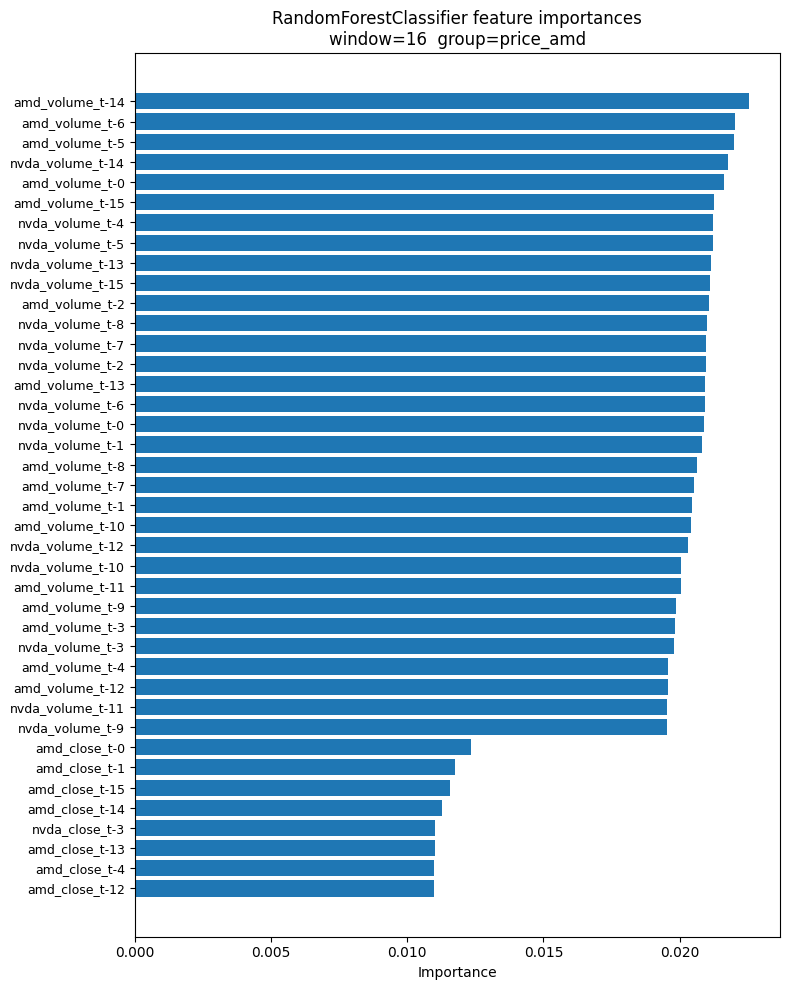

[saved] models/feature_importances\fi_w16_price_amd_XGBClassifier.png


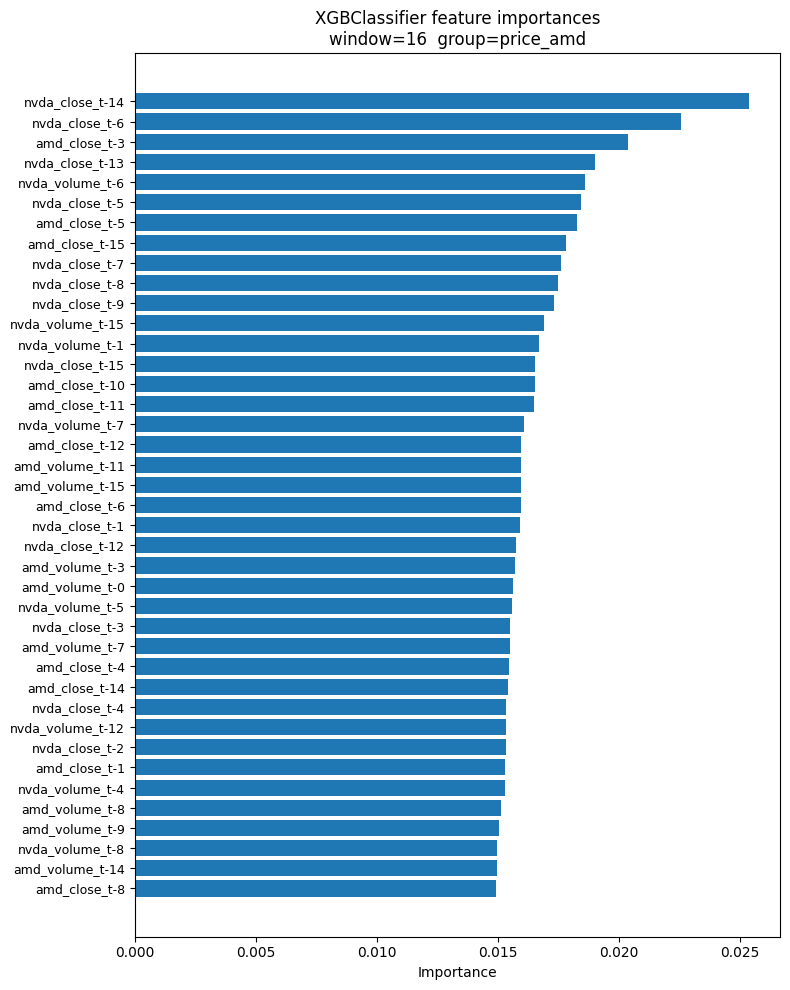

[saved] models/feature_importances\fi_w16_price_amd_LGBMClassifier.png


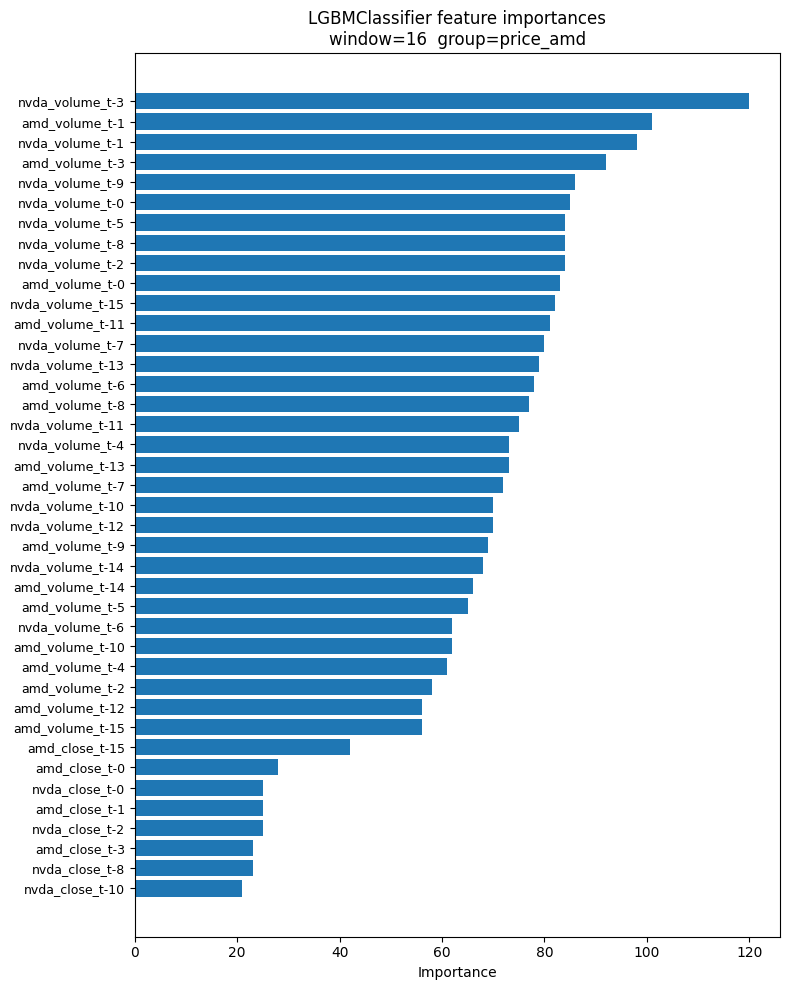

[saved] models/feature_importances\fi_w16_price_intc_RandomForestClassifier.png


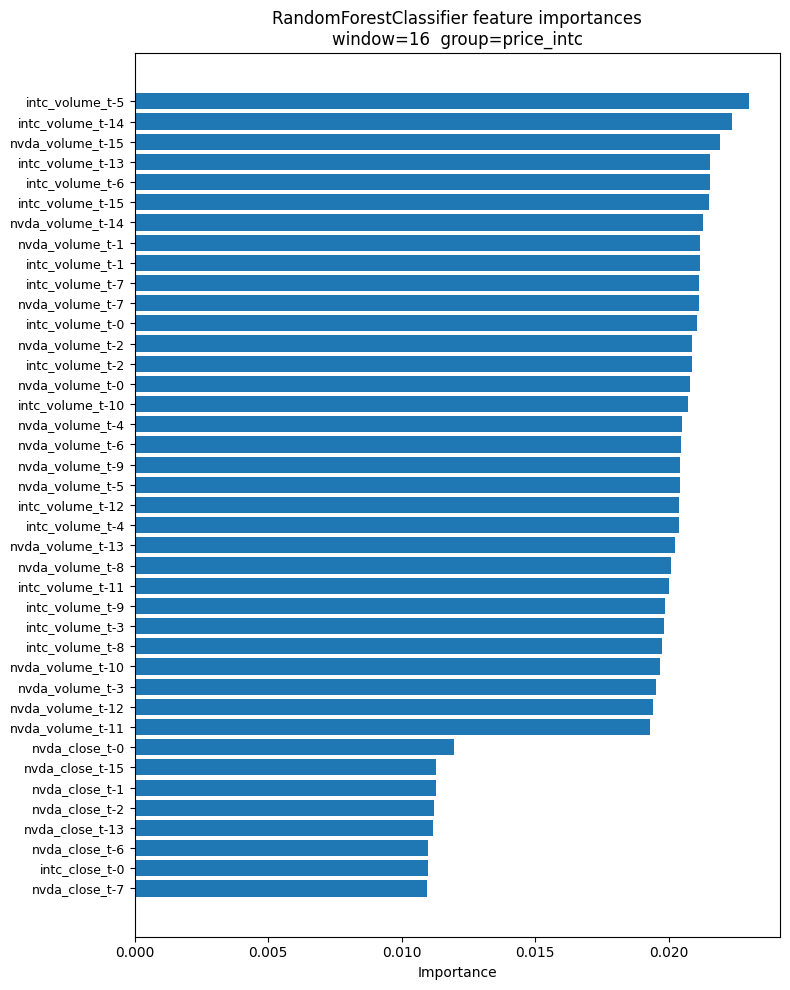

[saved] models/feature_importances\fi_w16_price_intc_XGBClassifier.png


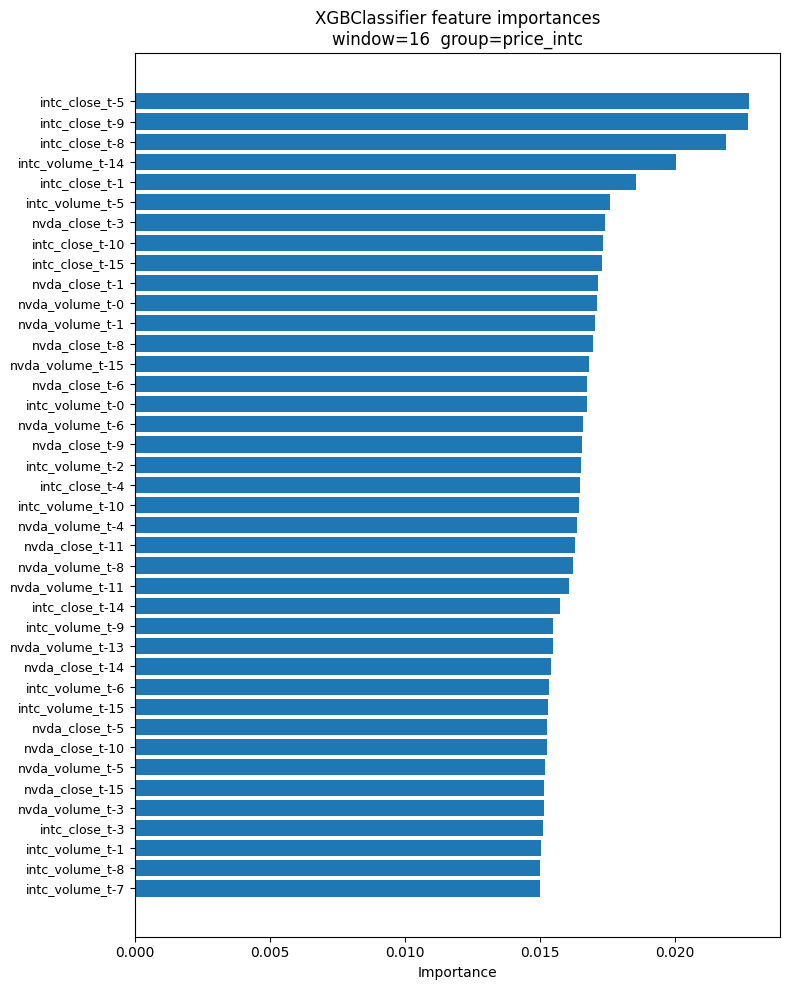

[saved] models/feature_importances\fi_w16_price_intc_LGBMClassifier.png


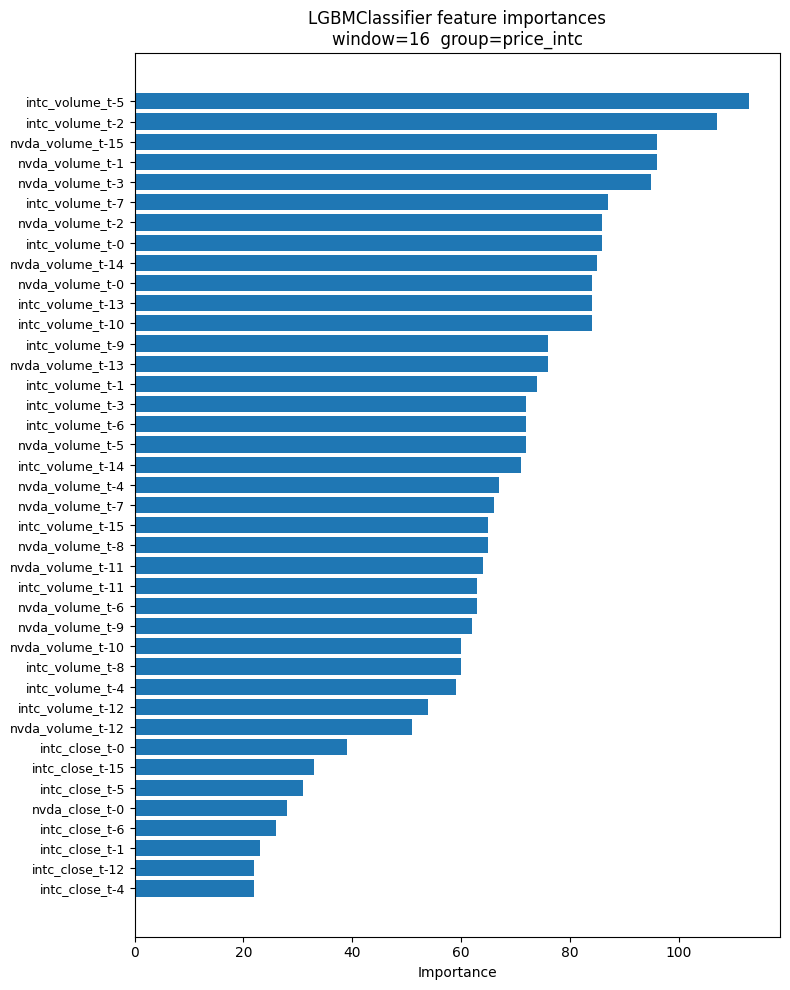

[saved] models/feature_importances\fi_w16_price_spy_RandomForestClassifier.png


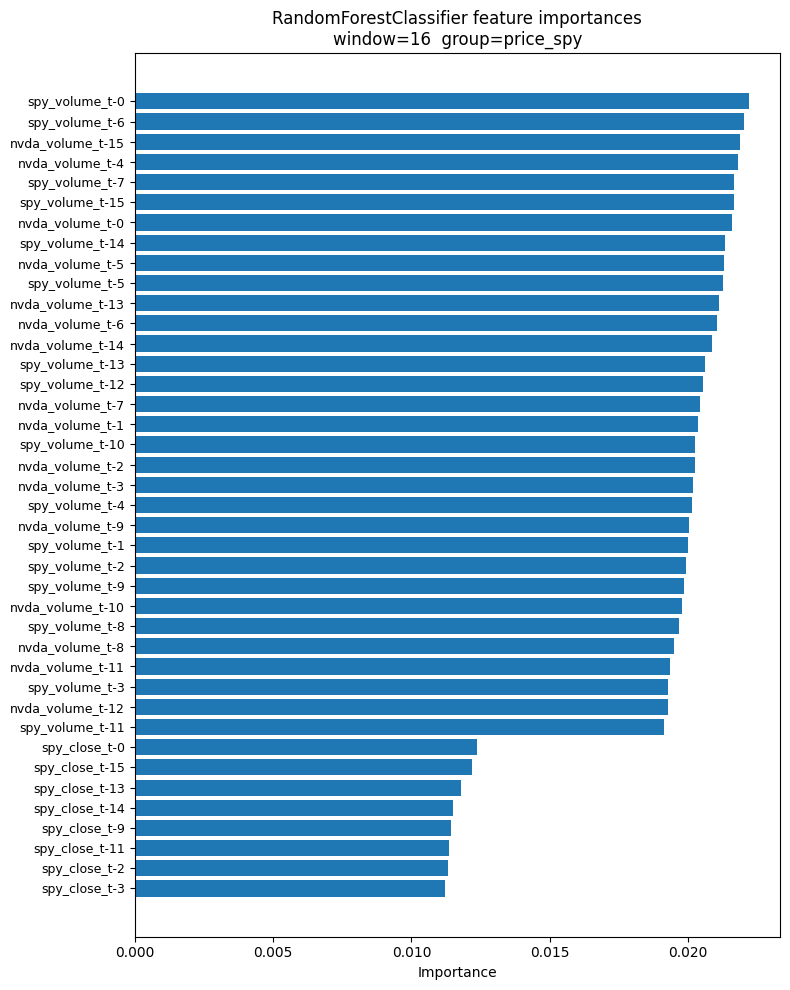

[saved] models/feature_importances\fi_w16_price_spy_XGBClassifier.png


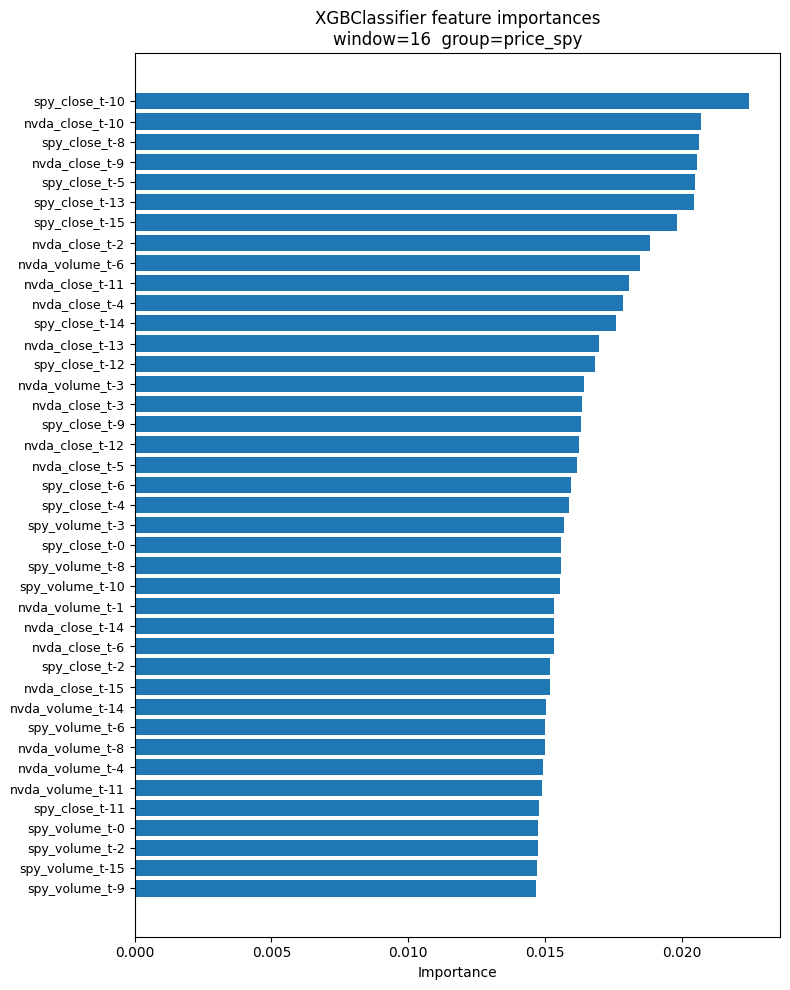

[saved] models/feature_importances\fi_w16_price_spy_LGBMClassifier.png


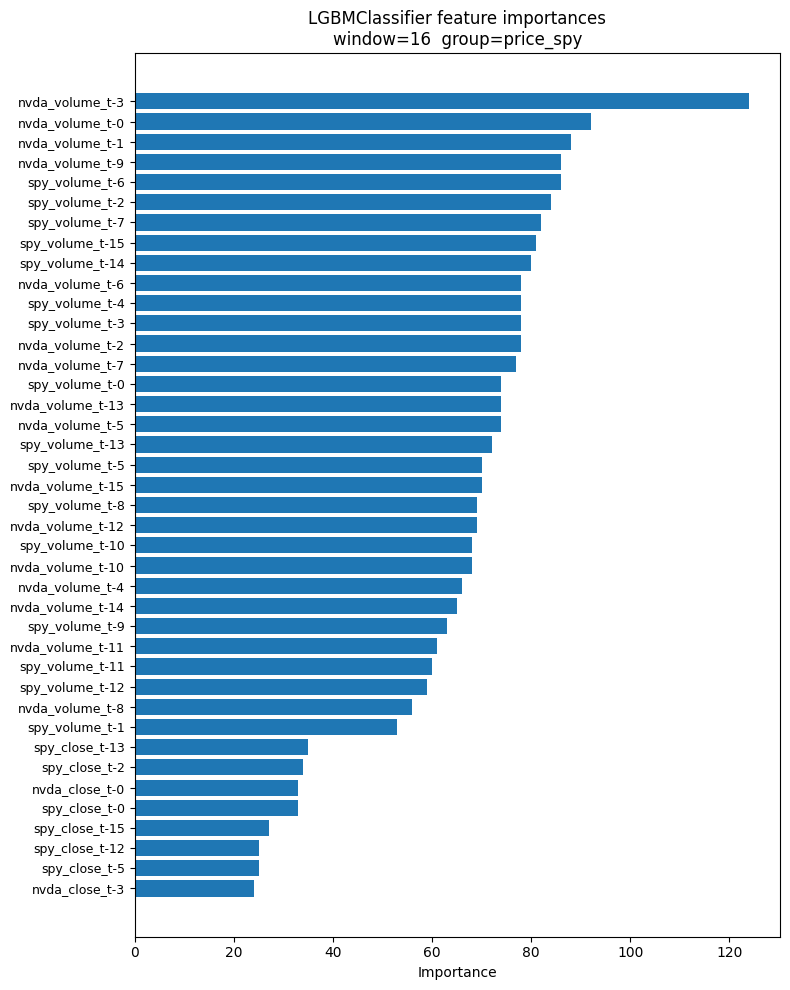

[saved] models/feature_importances\fi_w16_price_dia_RandomForestClassifier.png


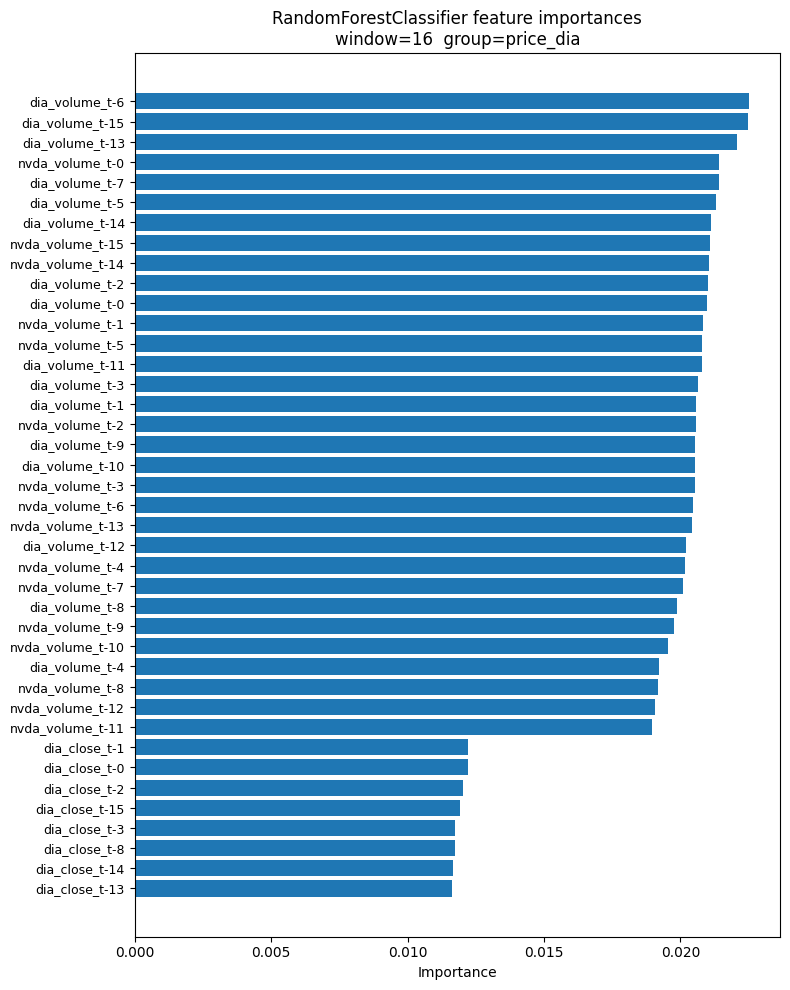

[saved] models/feature_importances\fi_w16_price_dia_XGBClassifier.png


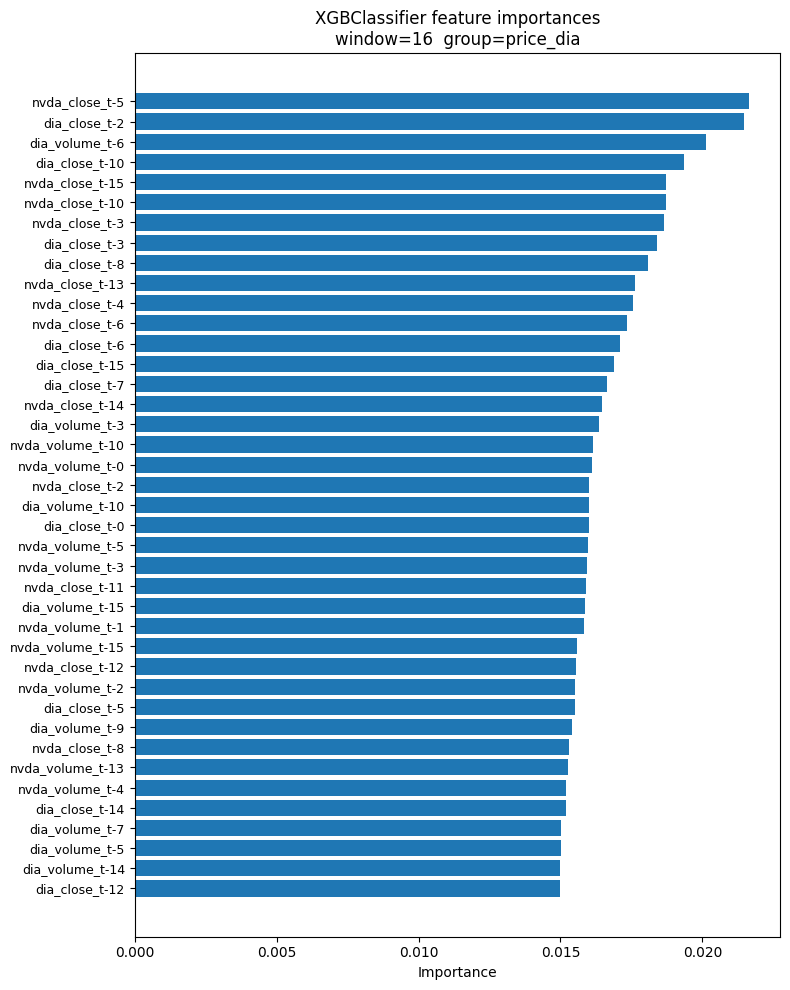

[saved] models/feature_importances\fi_w16_price_dia_LGBMClassifier.png


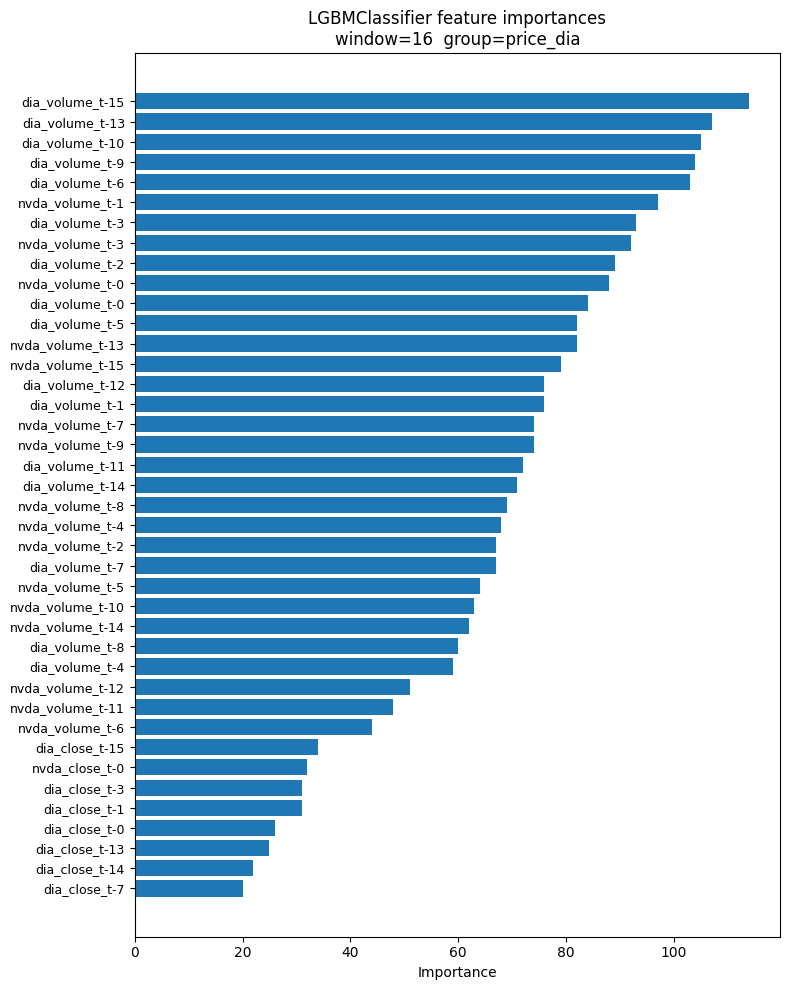

[saved] models/feature_importances\fi_w16_price_iwm_RandomForestClassifier.png


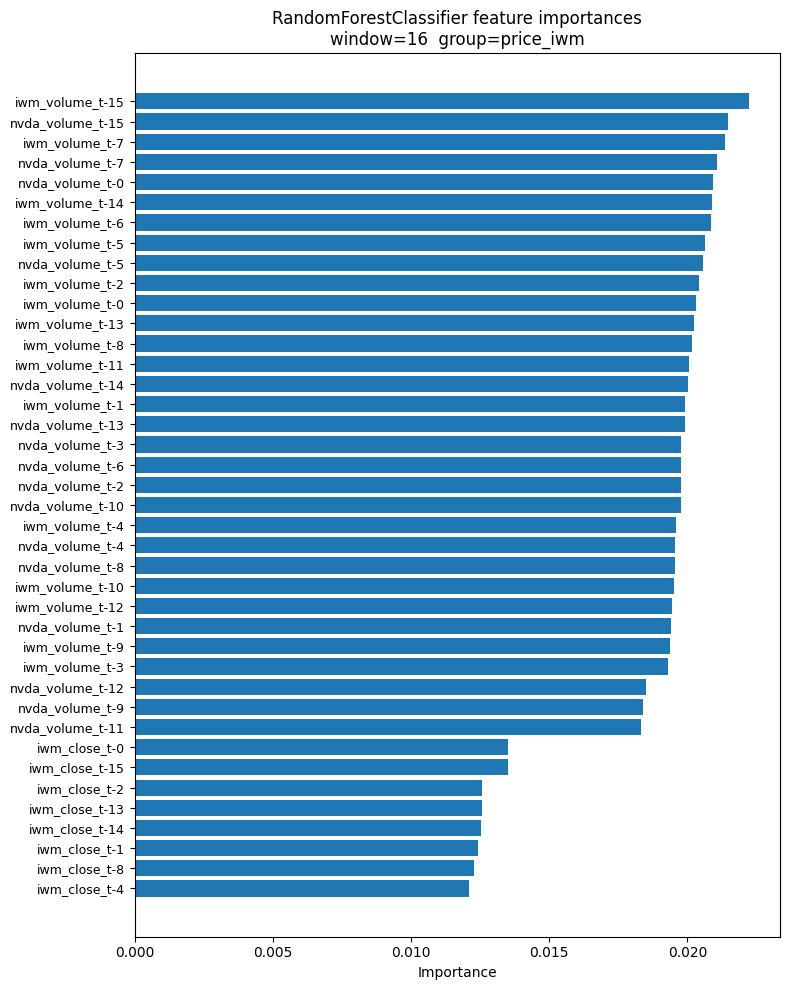

[saved] models/feature_importances\fi_w16_price_iwm_XGBClassifier.png


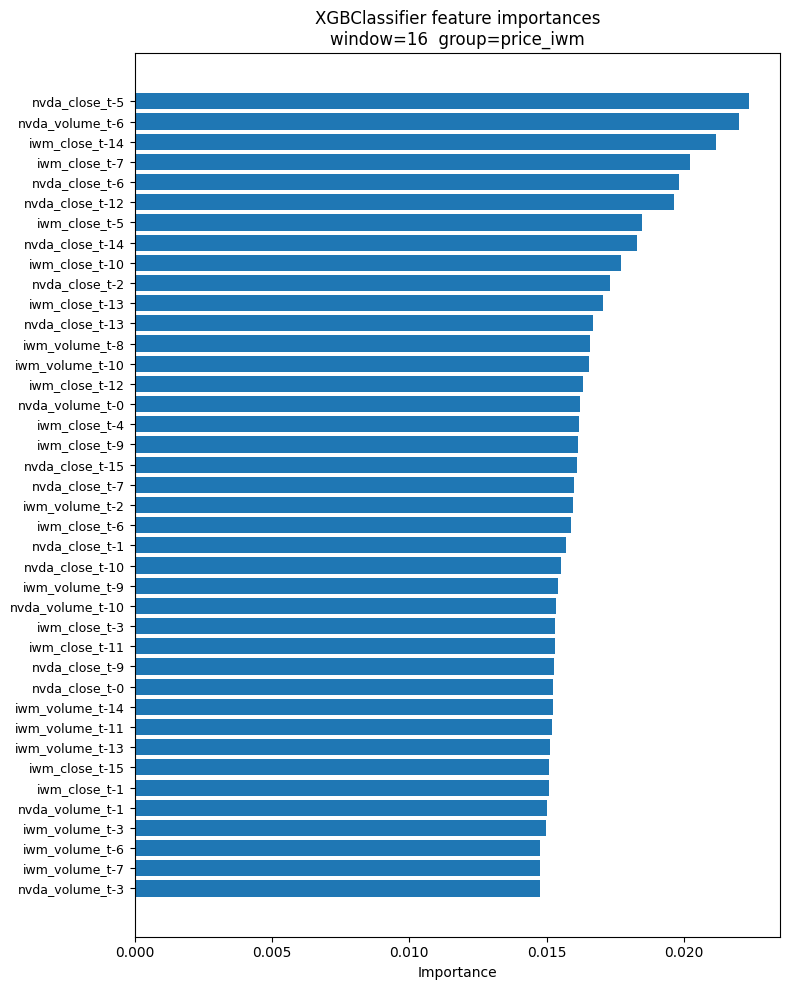

[saved] models/feature_importances\fi_w16_price_iwm_LGBMClassifier.png


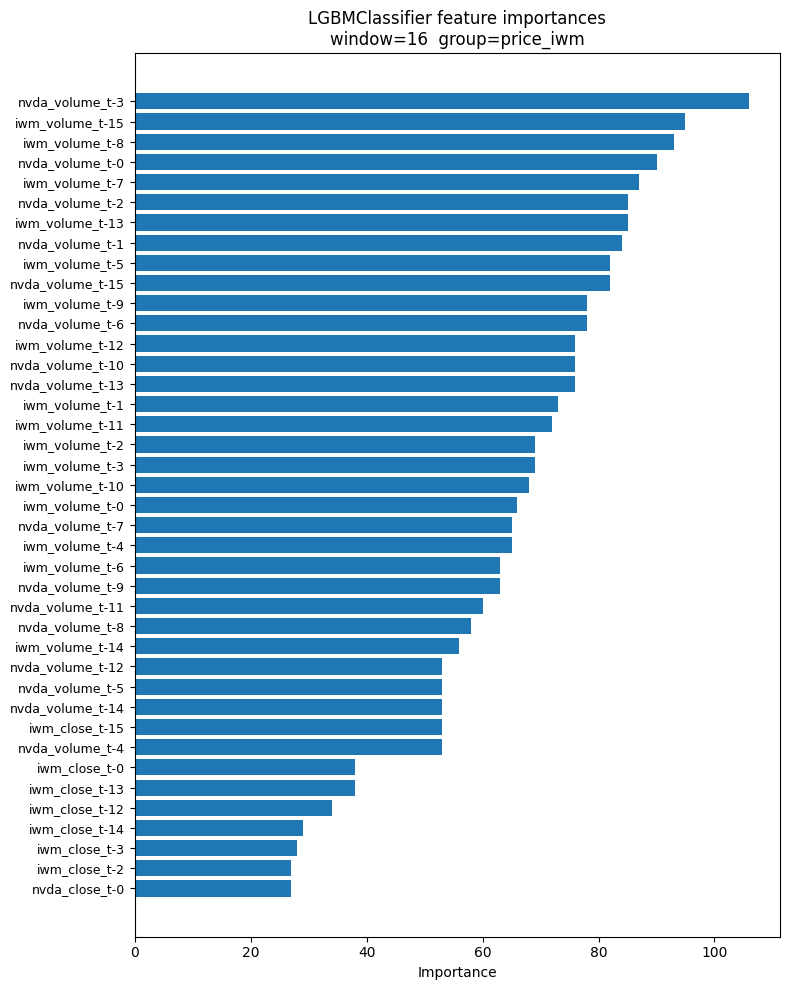

[saved] models/feature_importances\fi_w16_price_btc_RandomForestClassifier.png


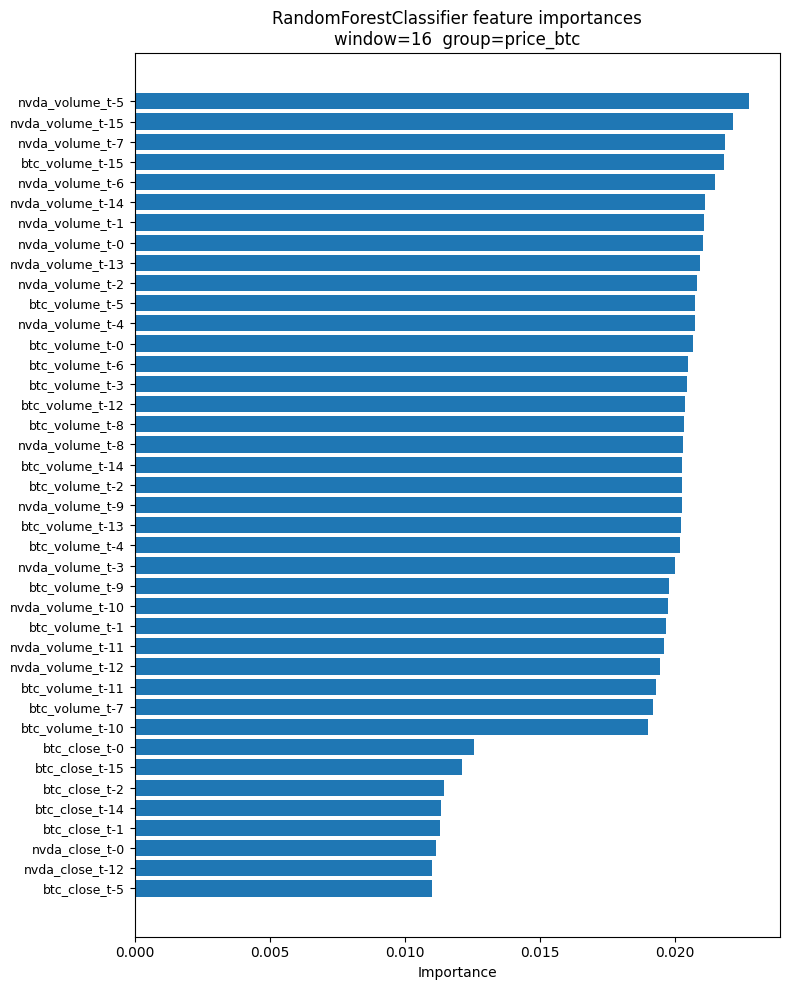

[saved] models/feature_importances\fi_w16_price_btc_XGBClassifier.png


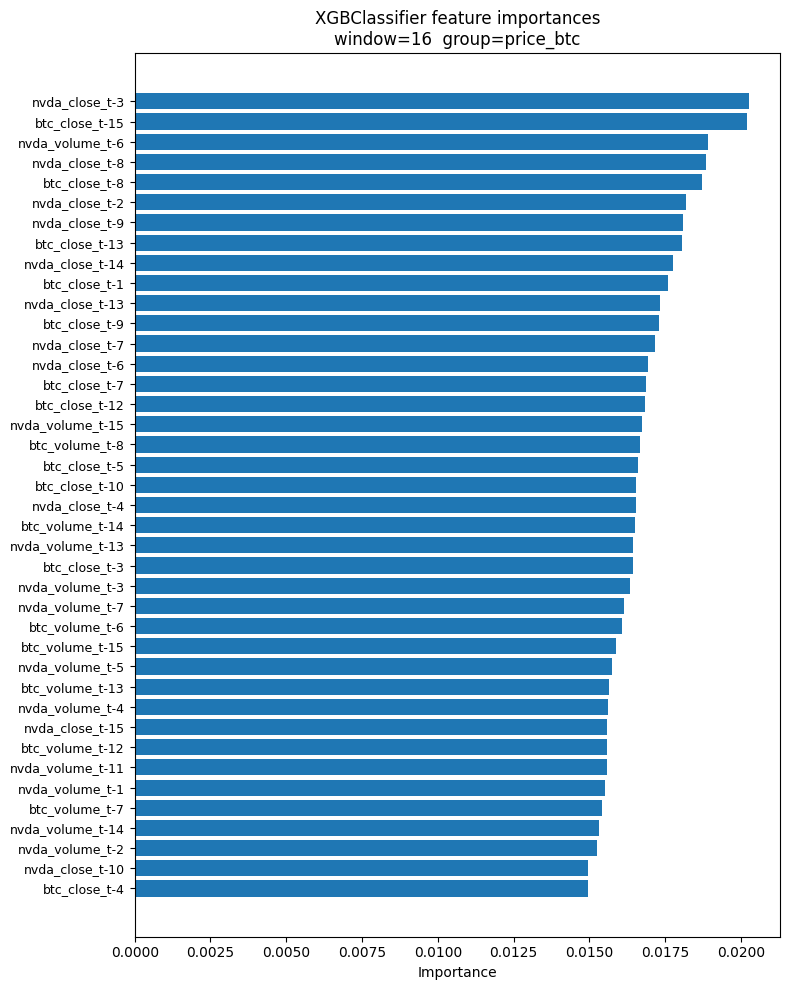

[saved] models/feature_importances\fi_w16_price_btc_LGBMClassifier.png


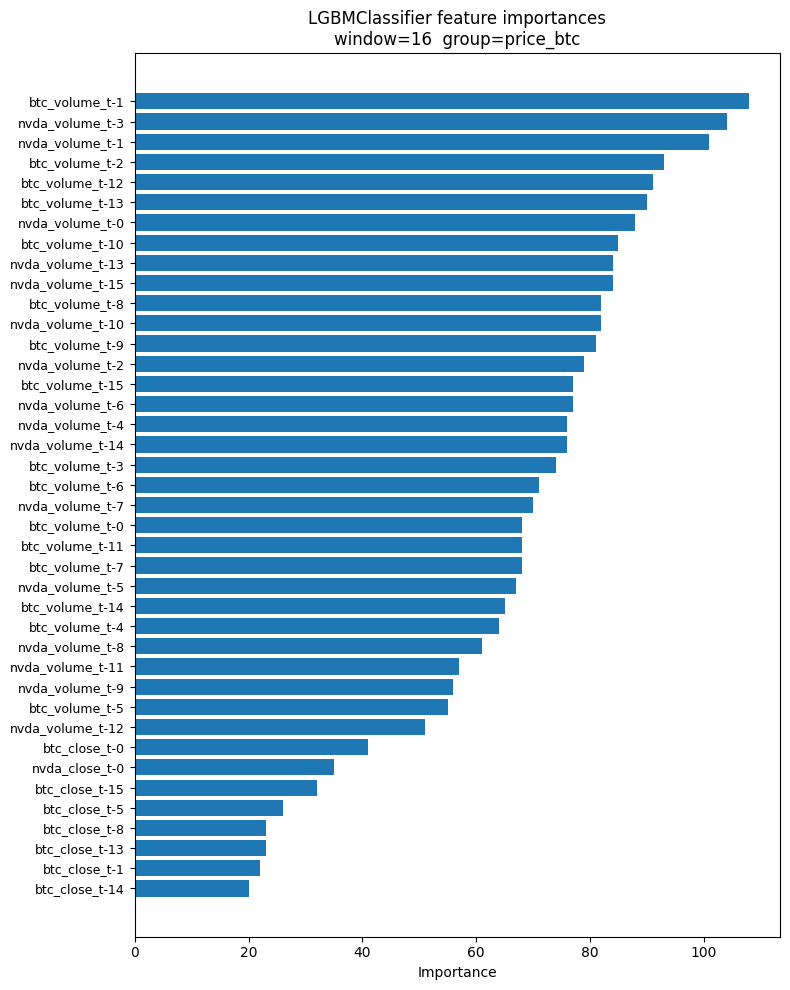

[saved] models/feature_importances\fi_w16_price_gold_RandomForestClassifier.png


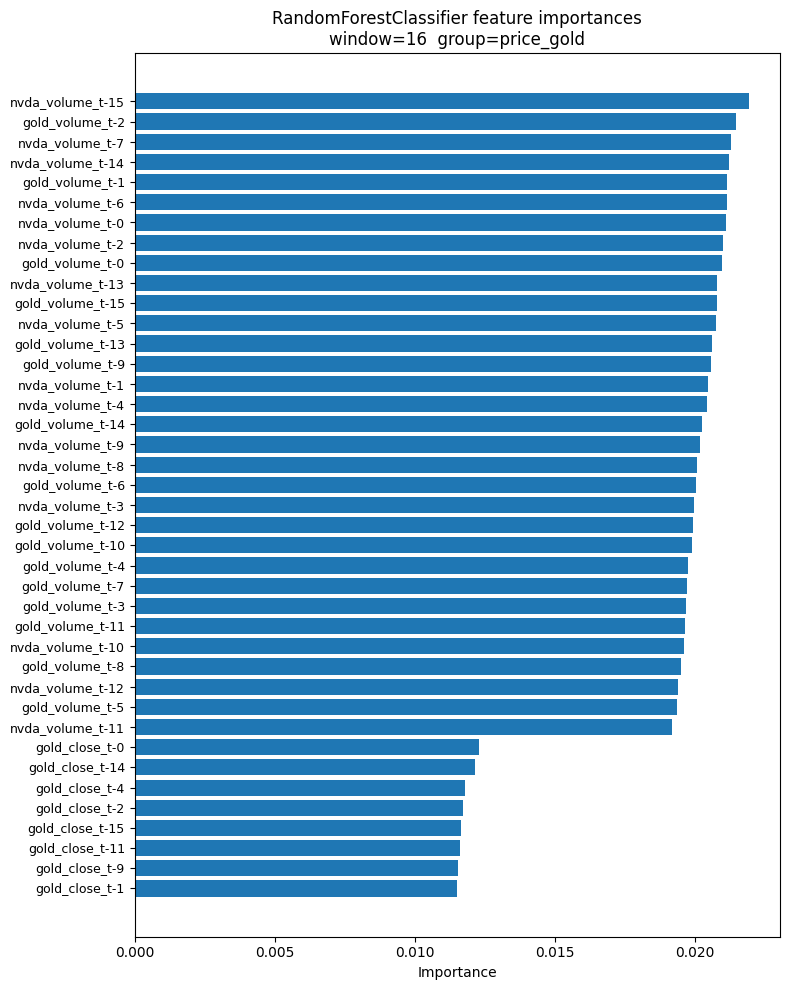

[saved] models/feature_importances\fi_w16_price_gold_XGBClassifier.png


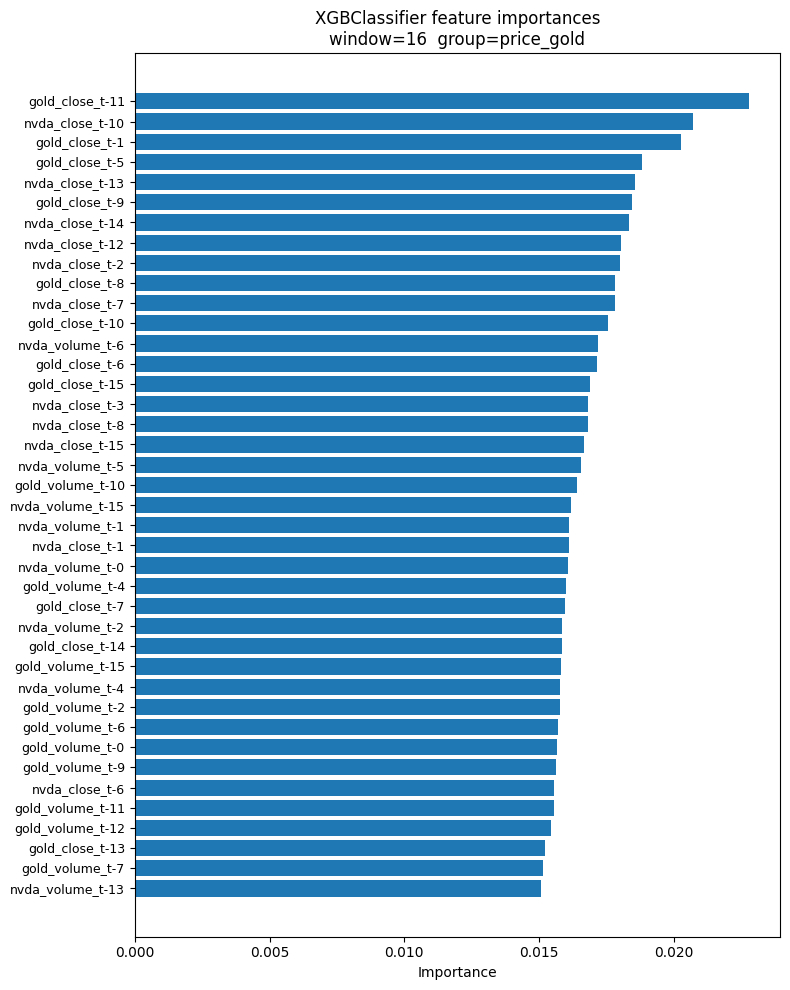

[saved] models/feature_importances\fi_w16_price_gold_LGBMClassifier.png


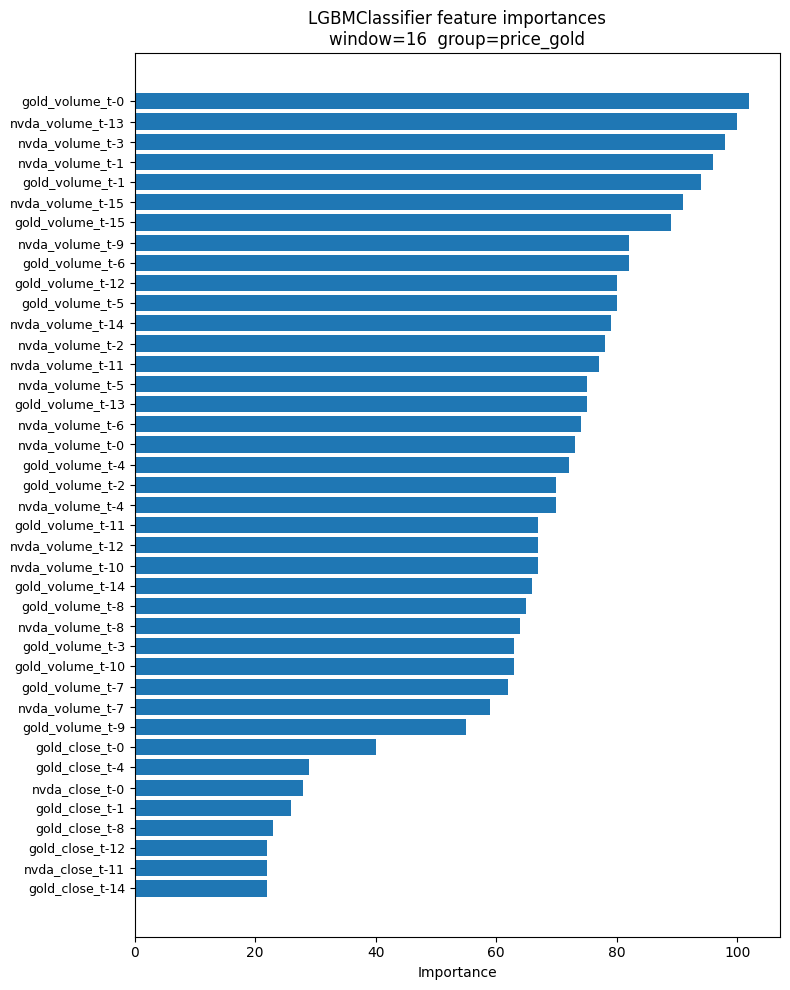

[saved] models/feature_importances\fi_w16_price_all_stocks_RandomForestClassifier.png


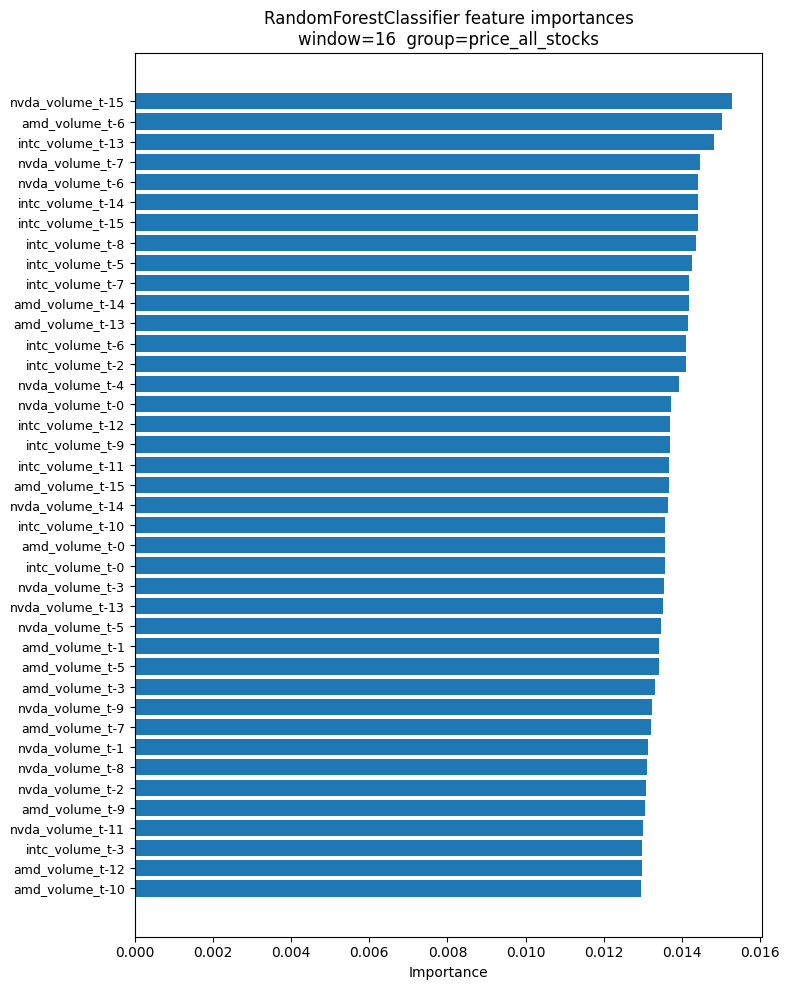

[saved] models/feature_importances\fi_w16_price_all_stocks_XGBClassifier.png


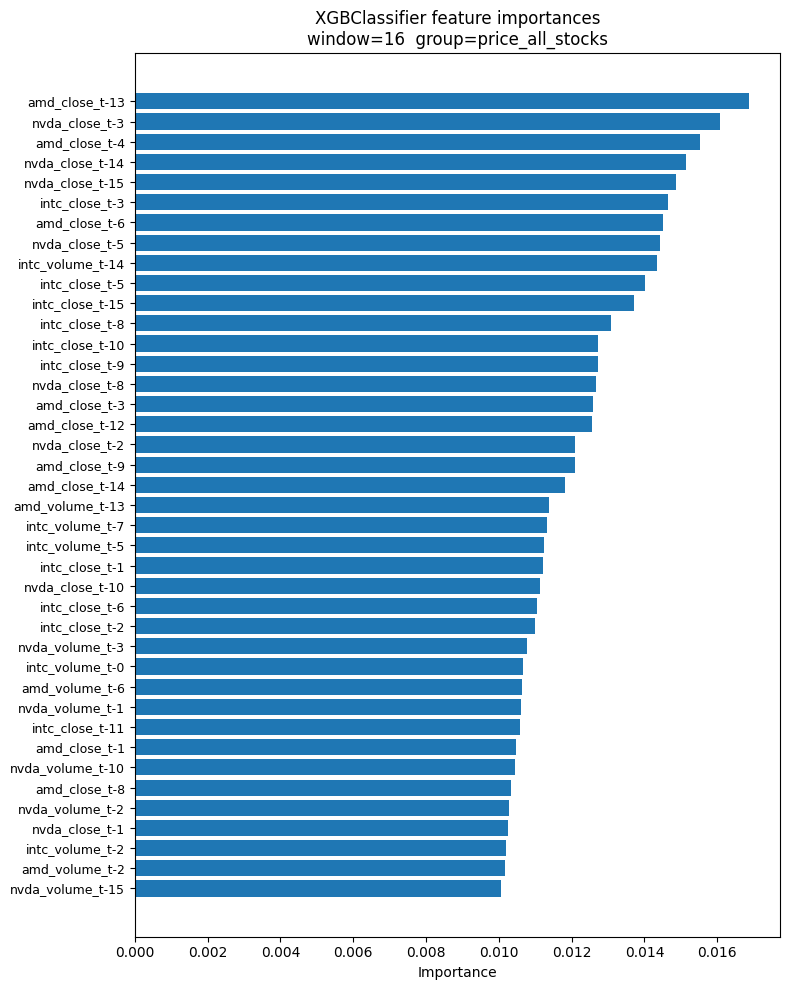

[saved] models/feature_importances\fi_w16_price_all_stocks_LGBMClassifier.png


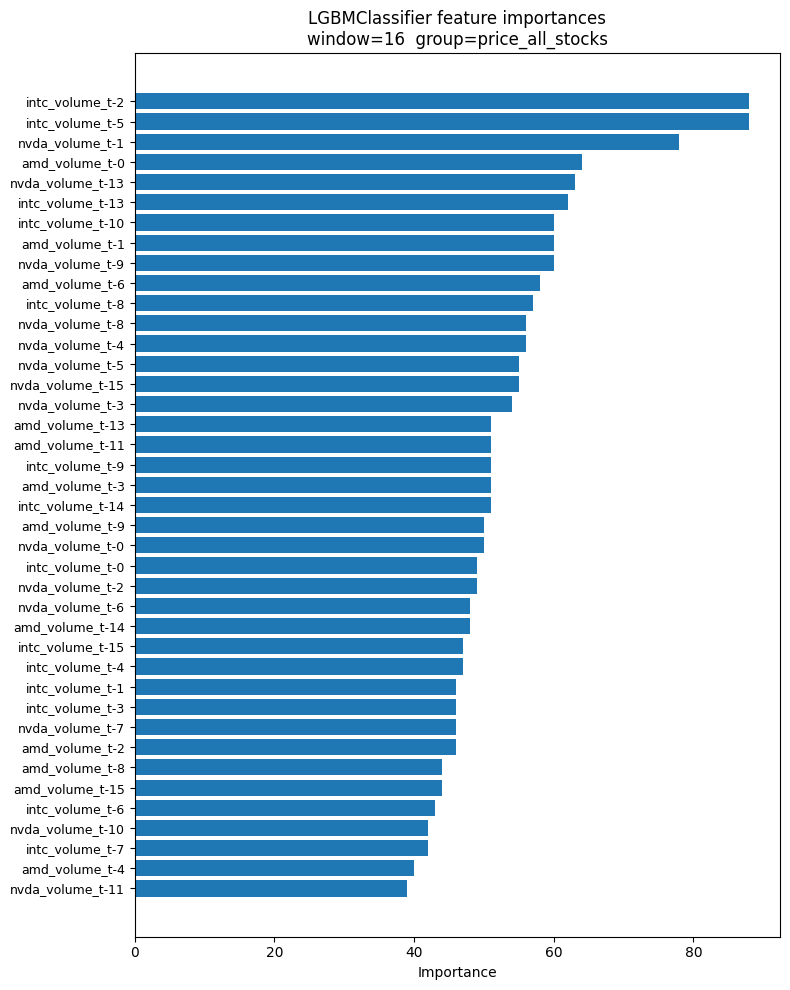

[saved] models/feature_importances\fi_w16_price_all_etf_RandomForestClassifier.png


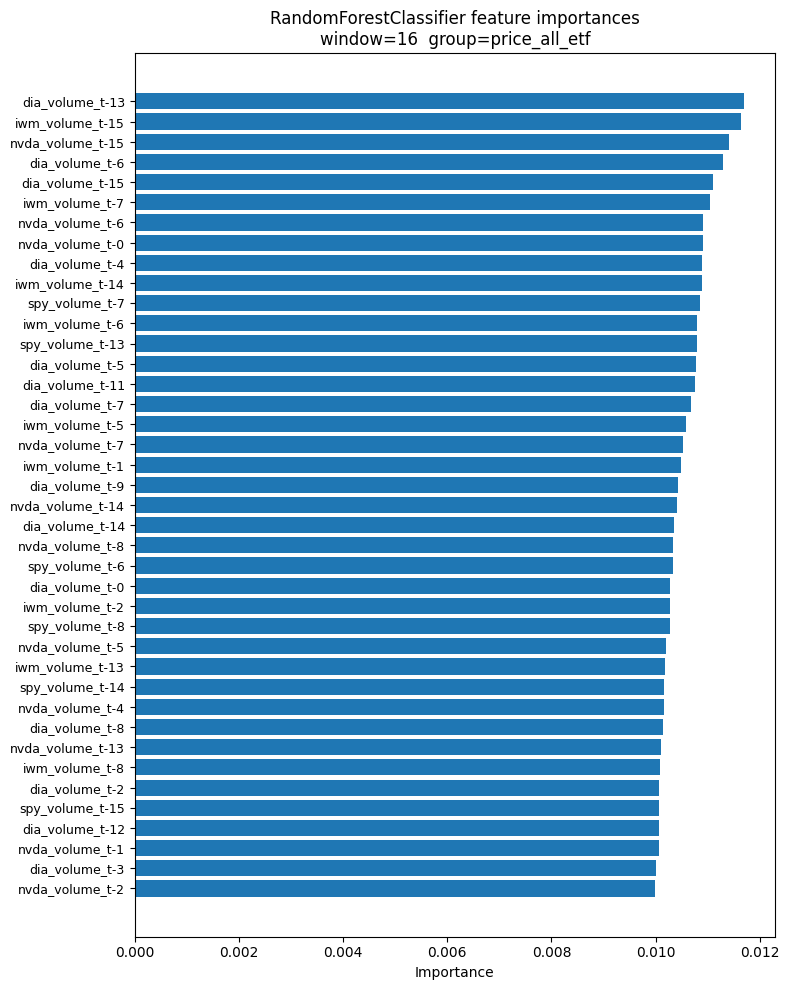

[saved] models/feature_importances\fi_w16_price_all_etf_XGBClassifier.png


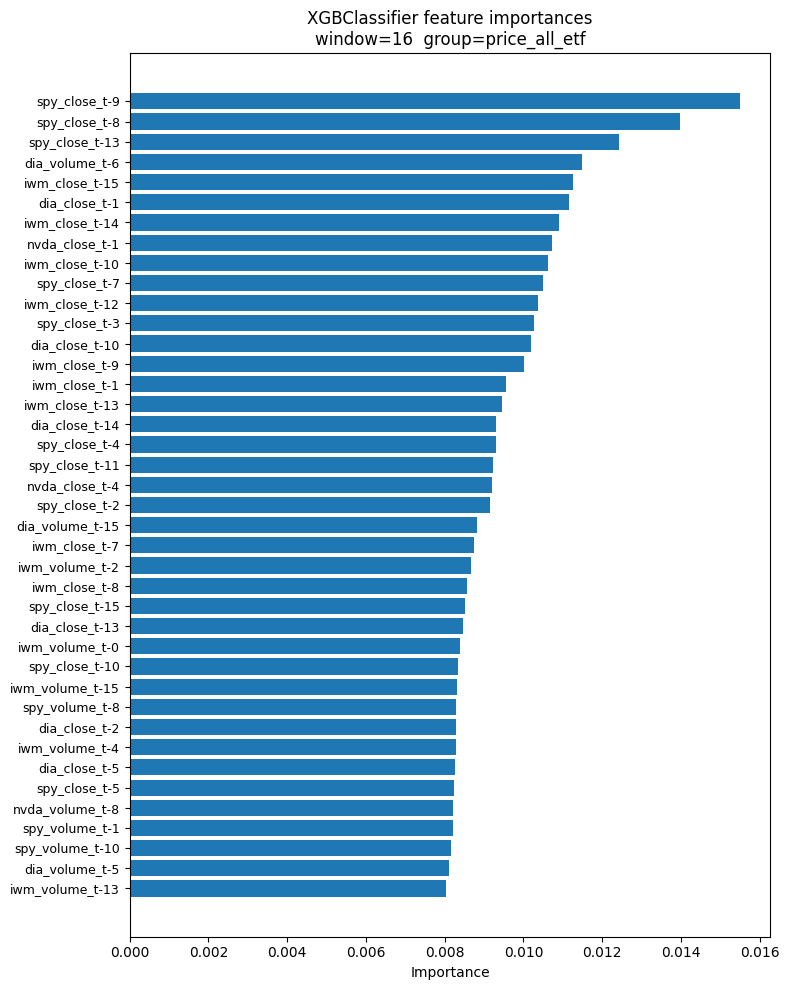

[saved] models/feature_importances\fi_w16_price_all_etf_LGBMClassifier.png


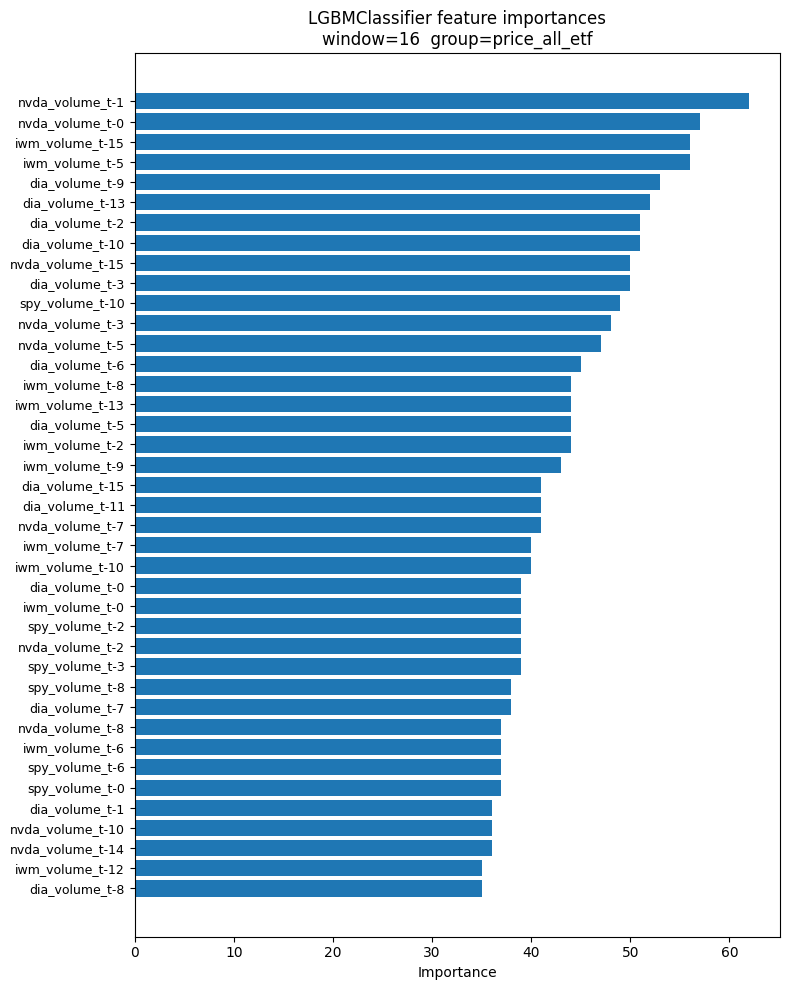

[saved] models/feature_importances\fi_w16_price_all_alt_RandomForestClassifier.png


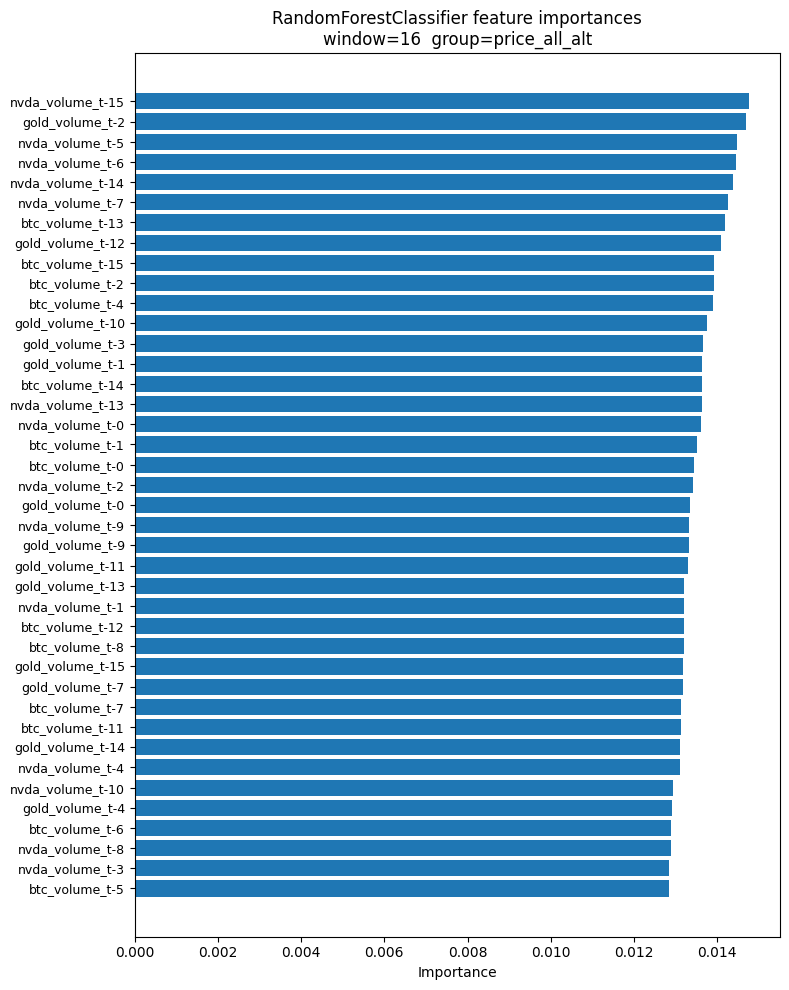

[saved] models/feature_importances\fi_w16_price_all_alt_XGBClassifier.png


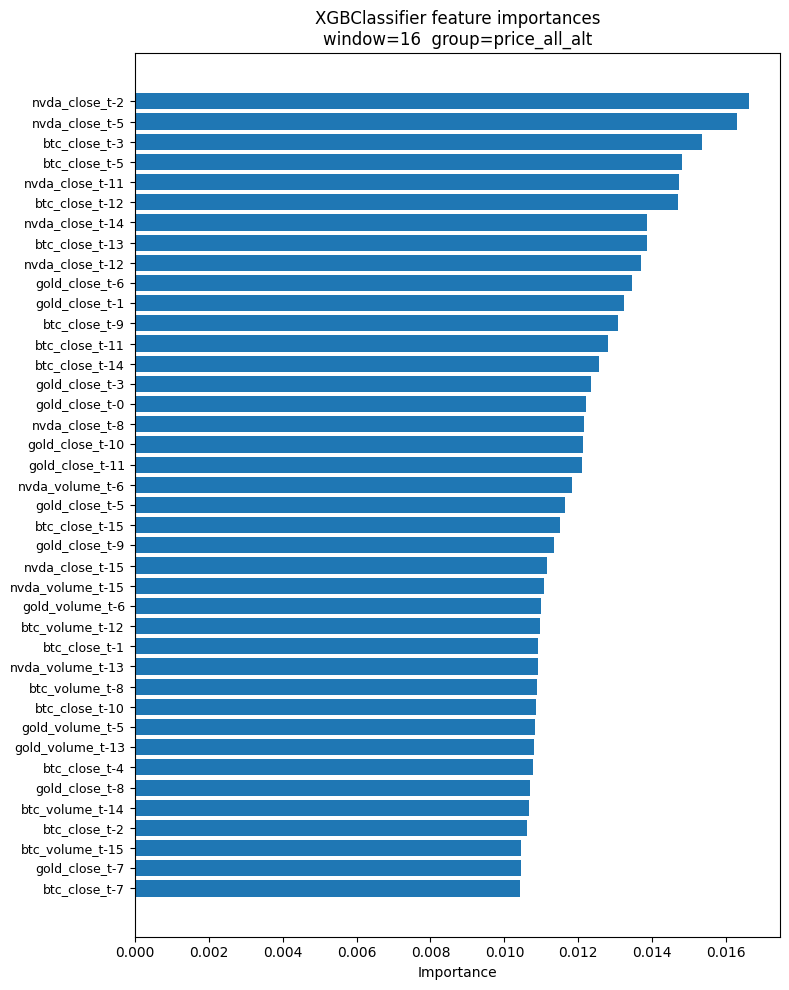

[saved] models/feature_importances\fi_w16_price_all_alt_LGBMClassifier.png


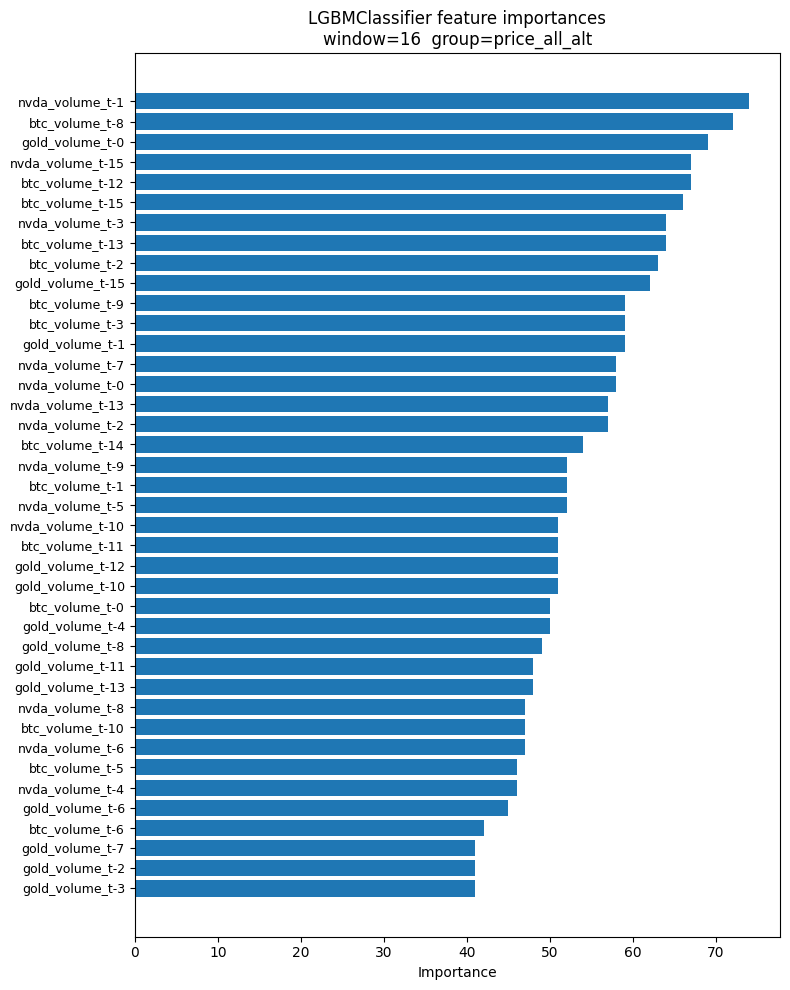

[saved] models/feature_importances\fi_w16_price_all_market_RandomForestClassifier.png


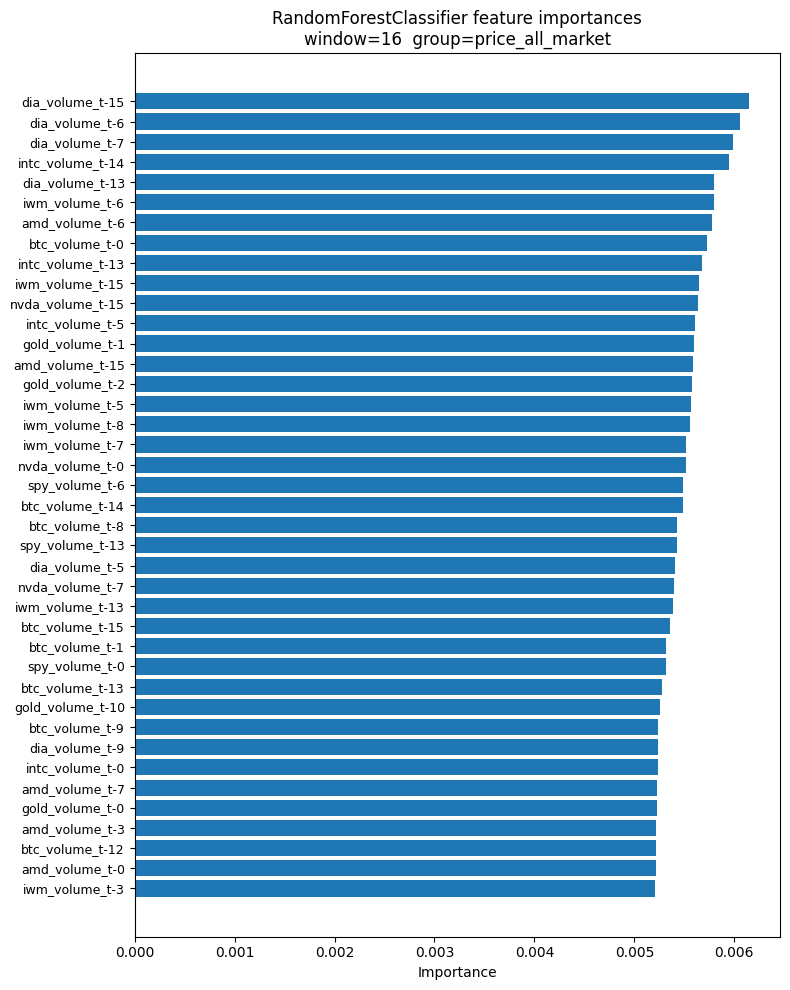

[saved] models/feature_importances\fi_w16_price_all_market_XGBClassifier.png


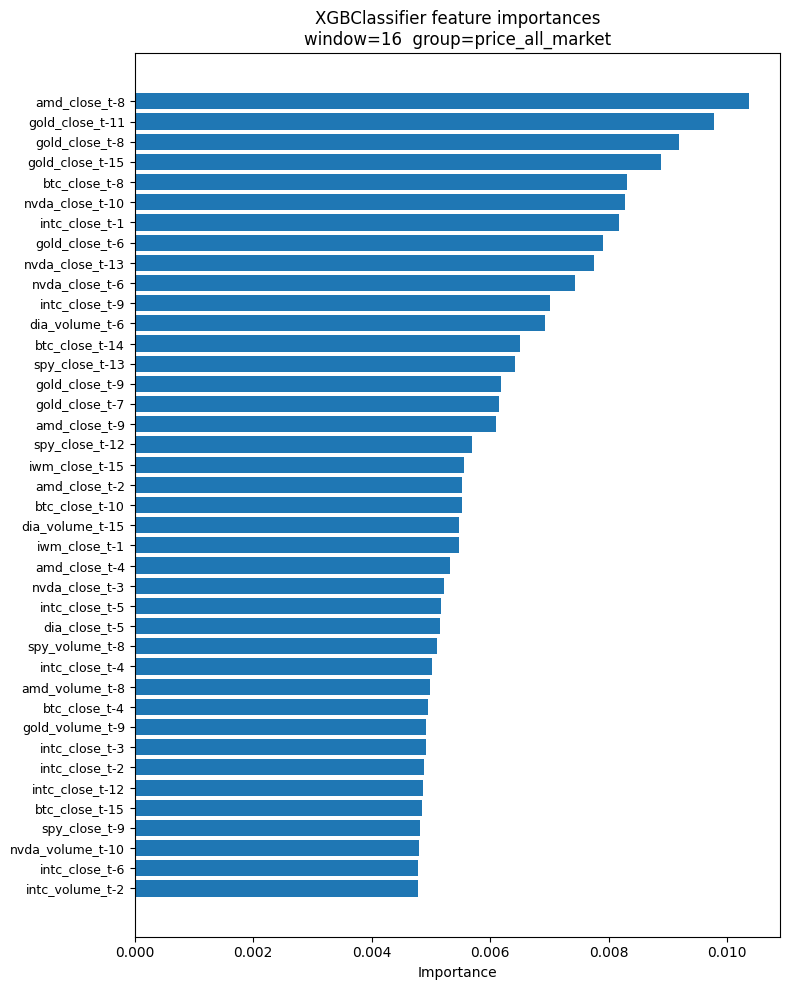

[saved] models/feature_importances\fi_w16_price_all_market_LGBMClassifier.png


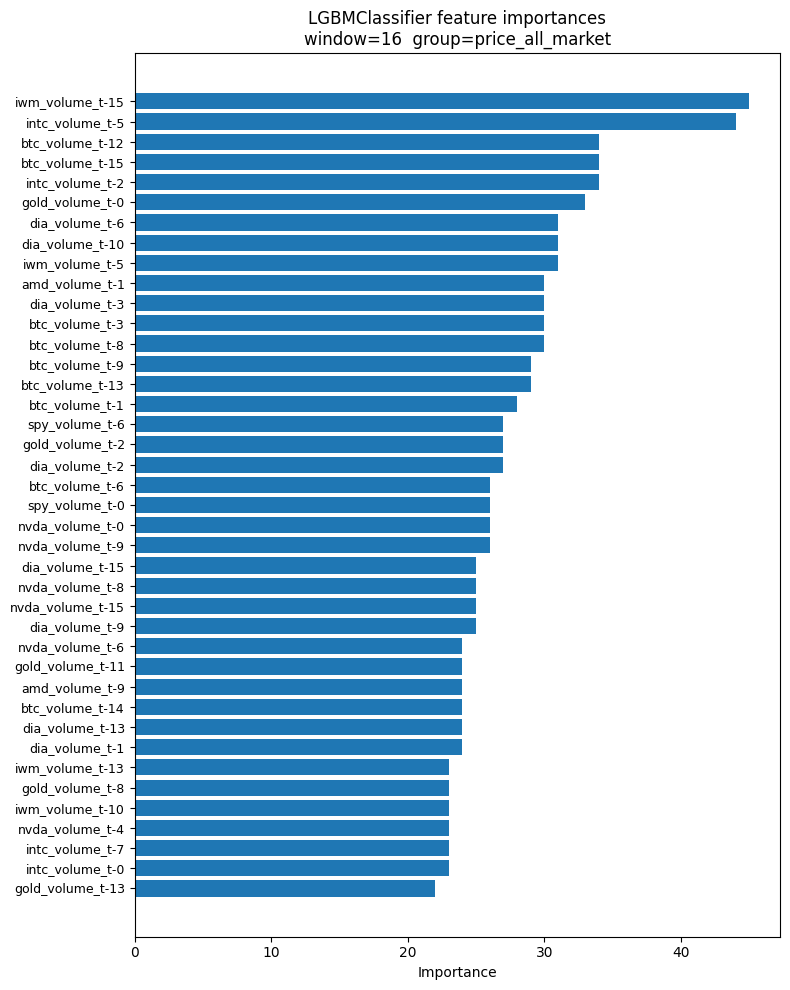

[saved] models/feature_importances\fi_w32_price_amd_RandomForestClassifier.png


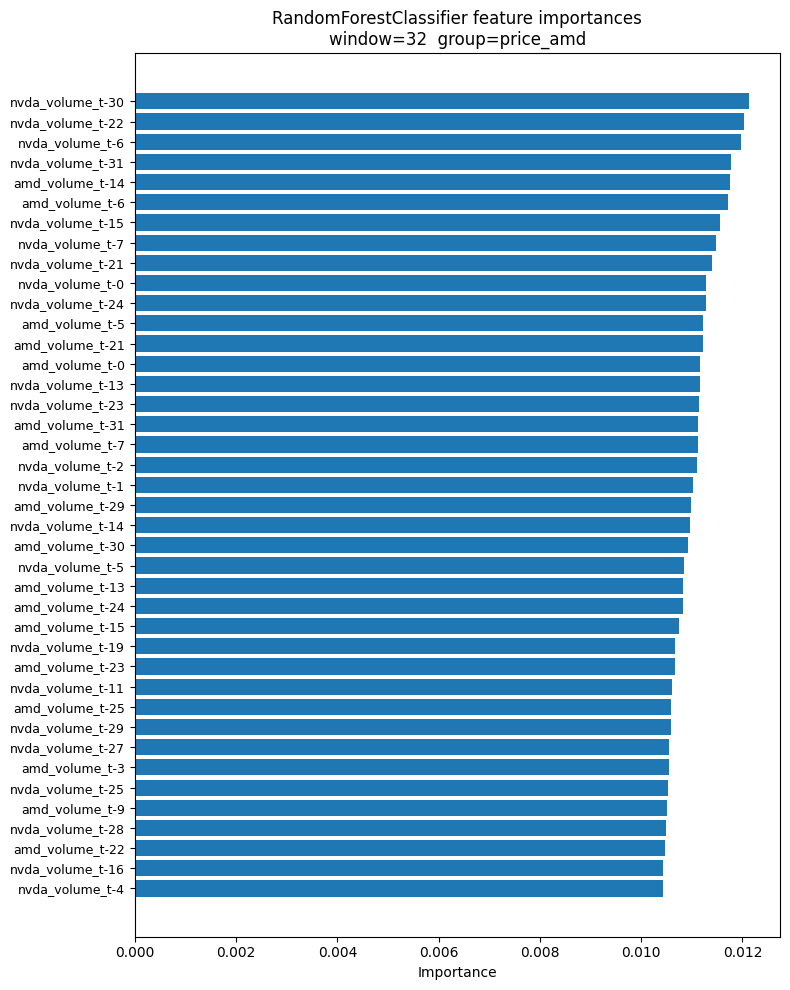

[saved] models/feature_importances\fi_w32_price_amd_XGBClassifier.png


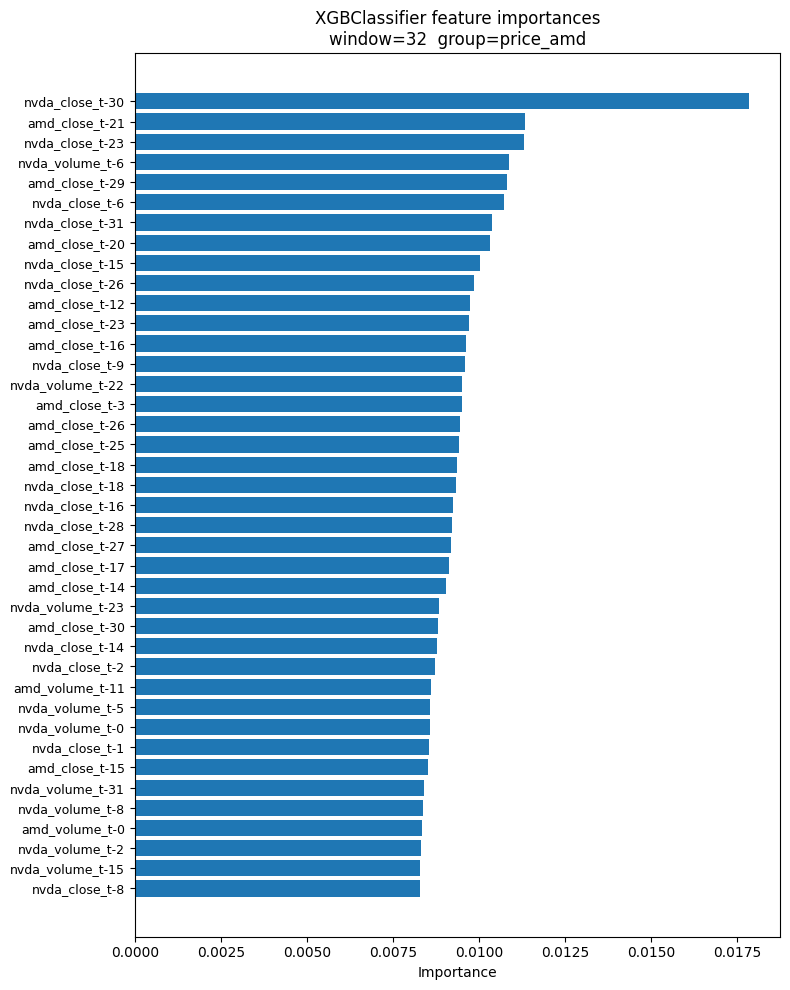

[saved] models/feature_importances\fi_w32_price_amd_LGBMClassifier.png


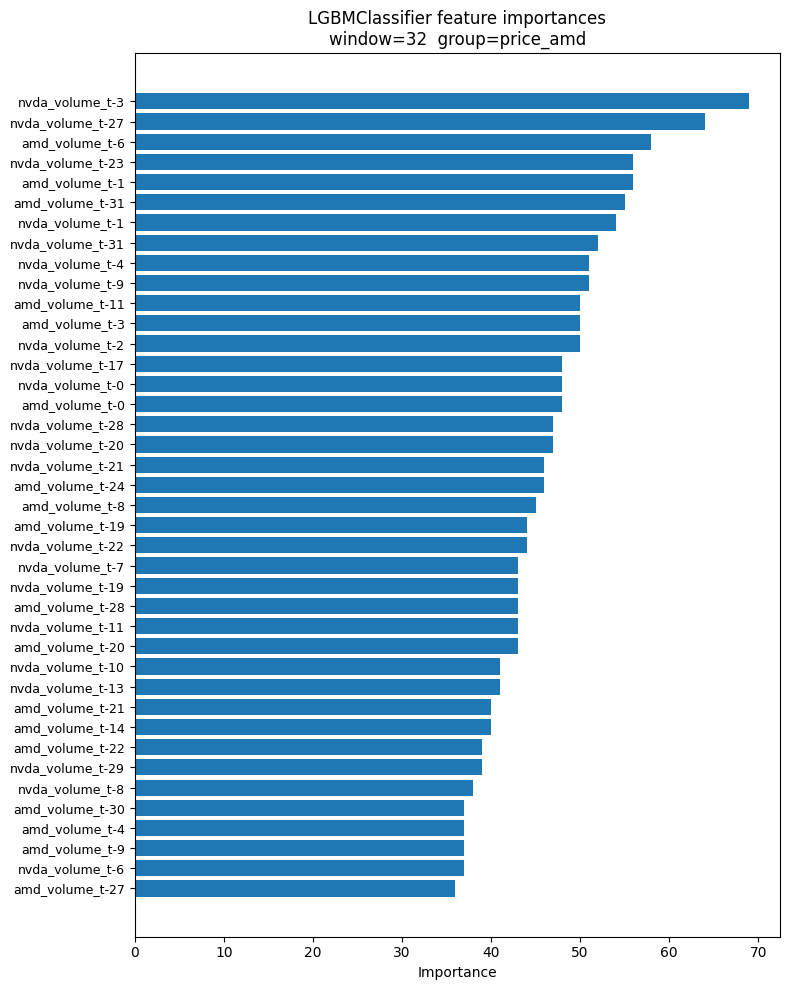

[saved] models/feature_importances\fi_w32_price_intc_RandomForestClassifier.png


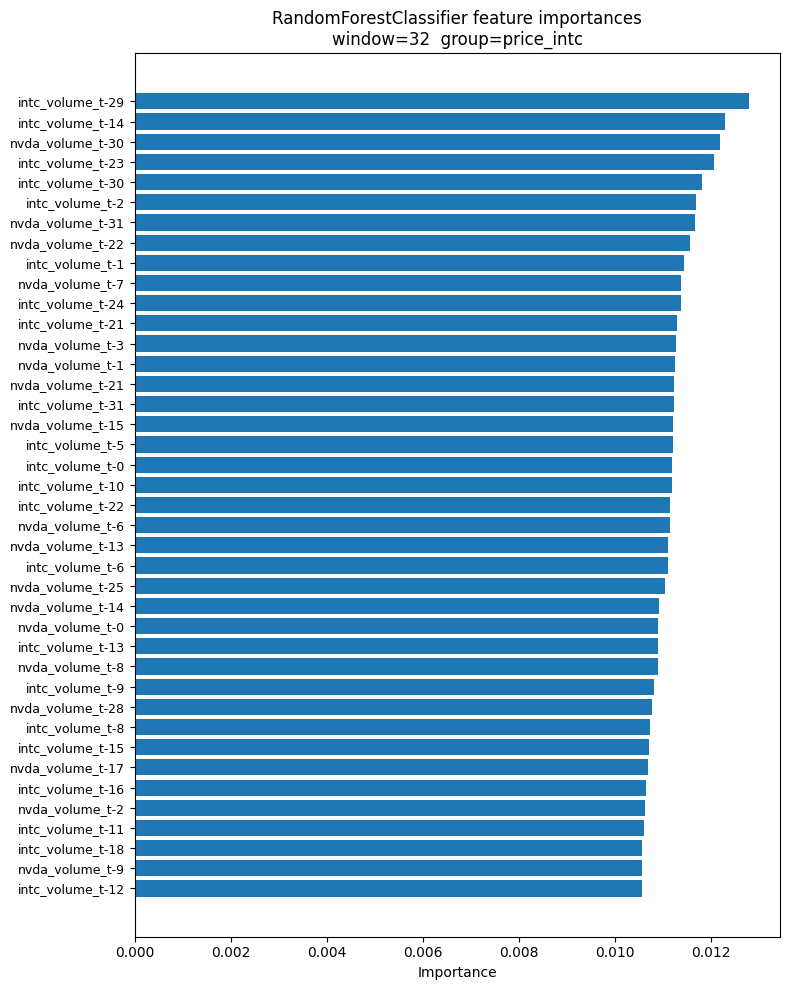

[saved] models/feature_importances\fi_w32_price_intc_XGBClassifier.png


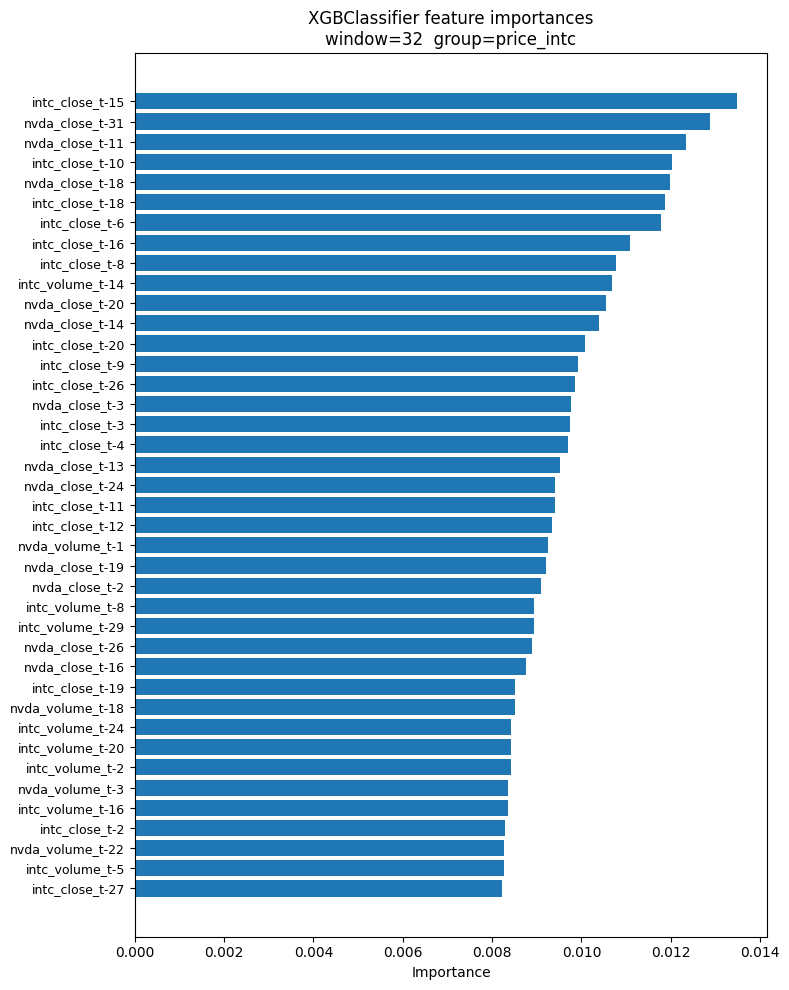

[saved] models/feature_importances\fi_w32_price_intc_LGBMClassifier.png


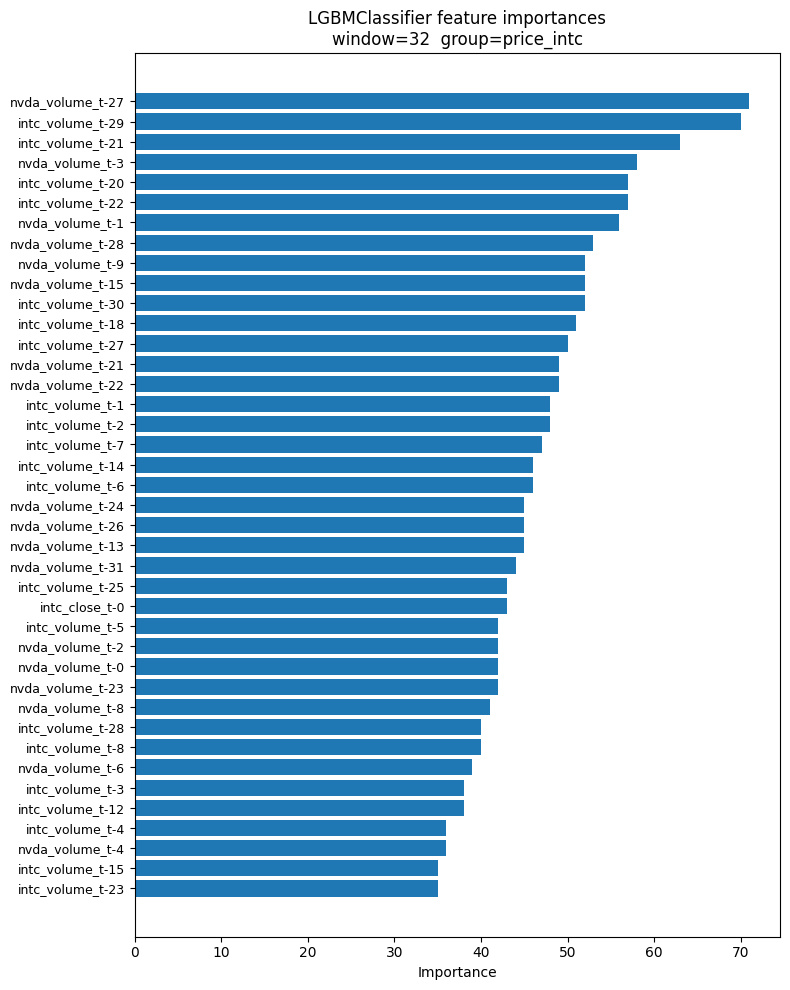

[saved] models/feature_importances\fi_w32_price_spy_RandomForestClassifier.png


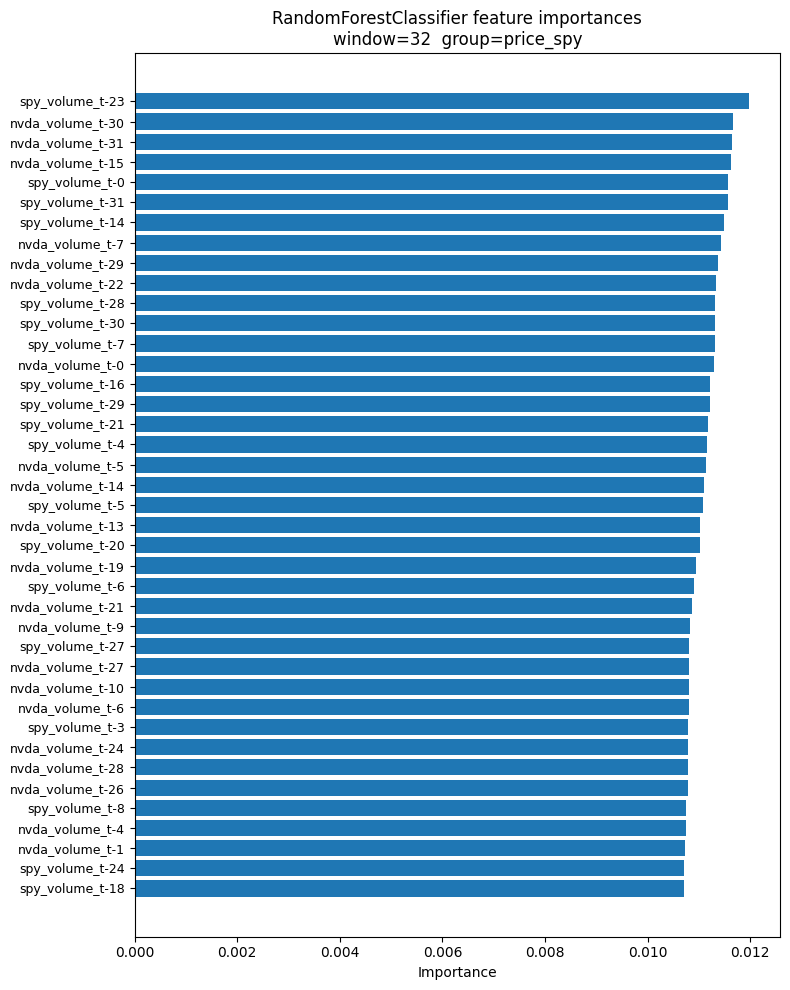

[saved] models/feature_importances\fi_w32_price_spy_XGBClassifier.png


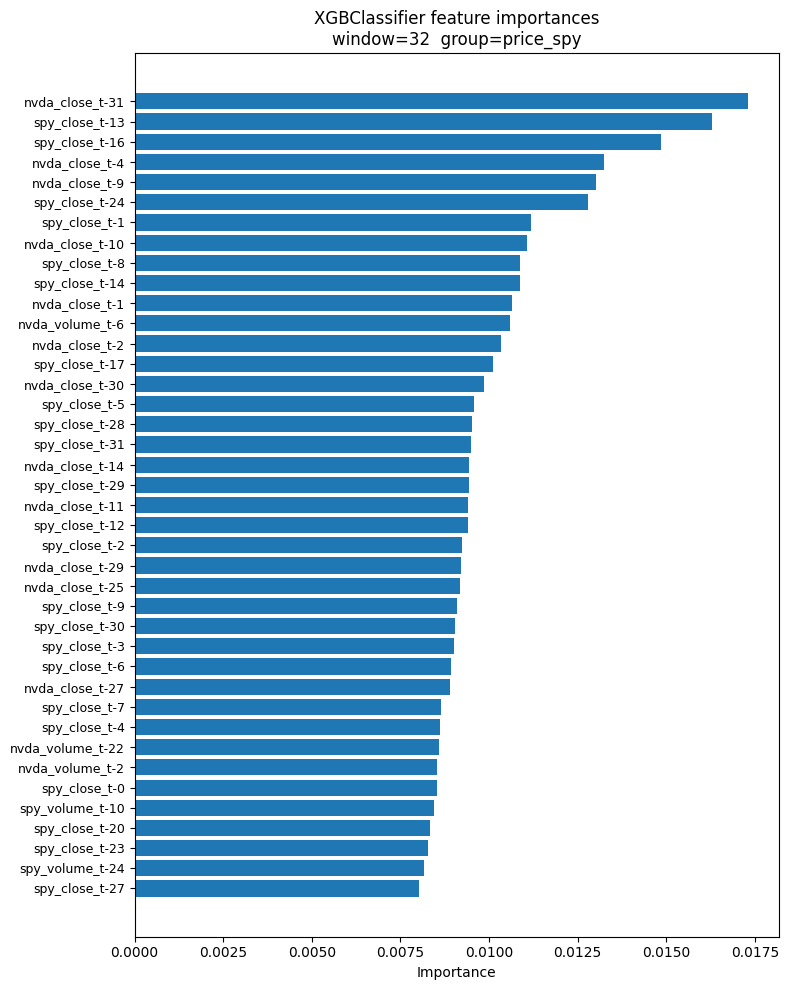

[saved] models/feature_importances\fi_w32_price_spy_LGBMClassifier.png


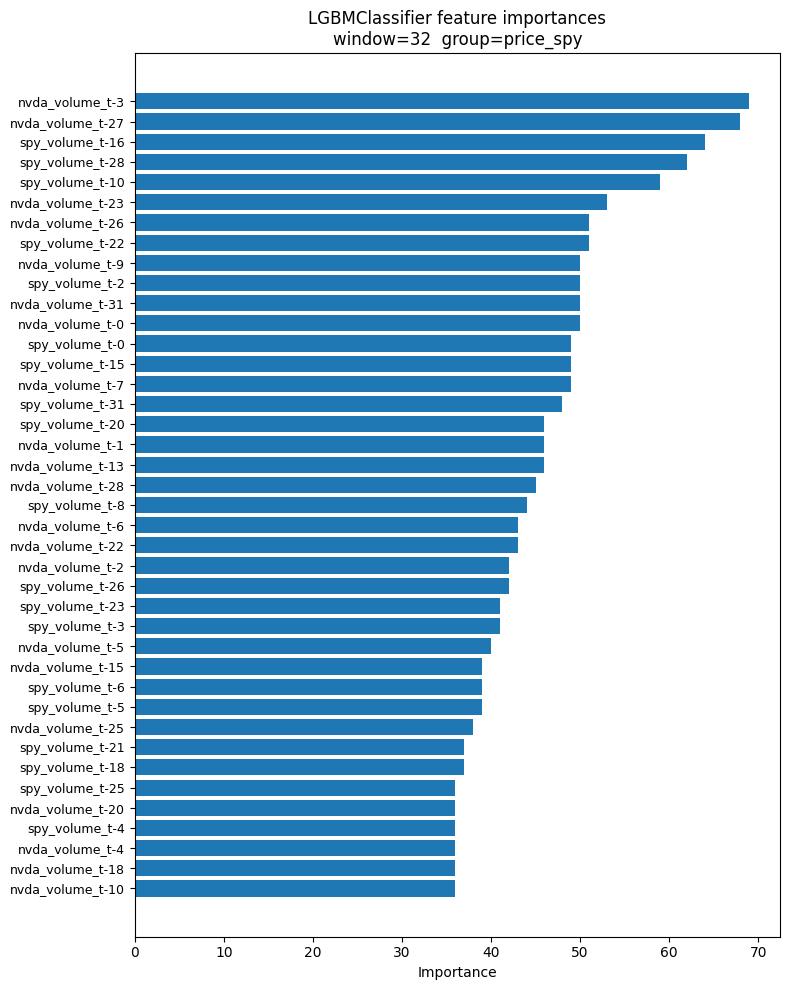

[saved] models/feature_importances\fi_w32_price_dia_RandomForestClassifier.png


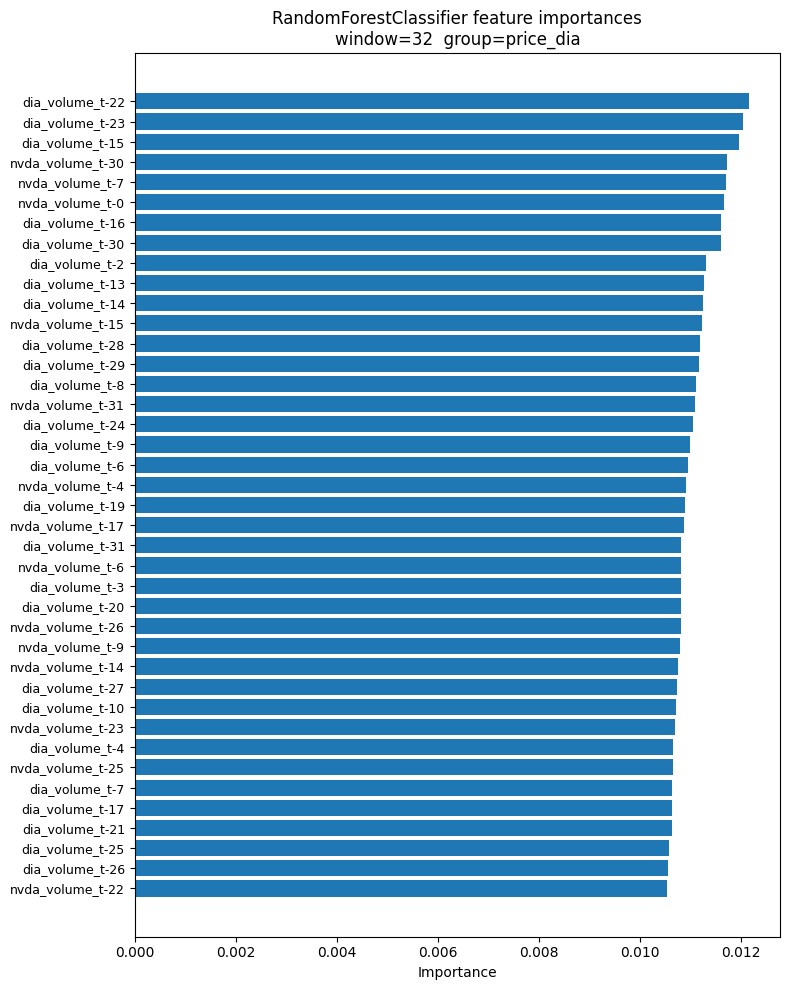

[saved] models/feature_importances\fi_w32_price_dia_XGBClassifier.png


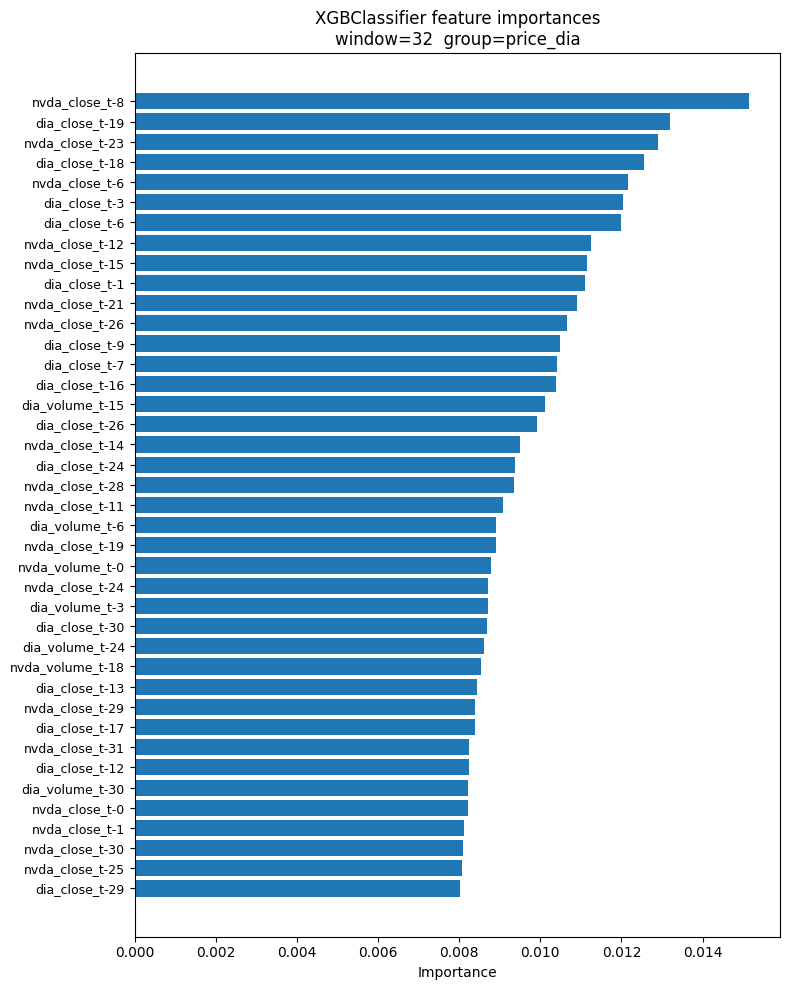

[saved] models/feature_importances\fi_w32_price_dia_LGBMClassifier.png


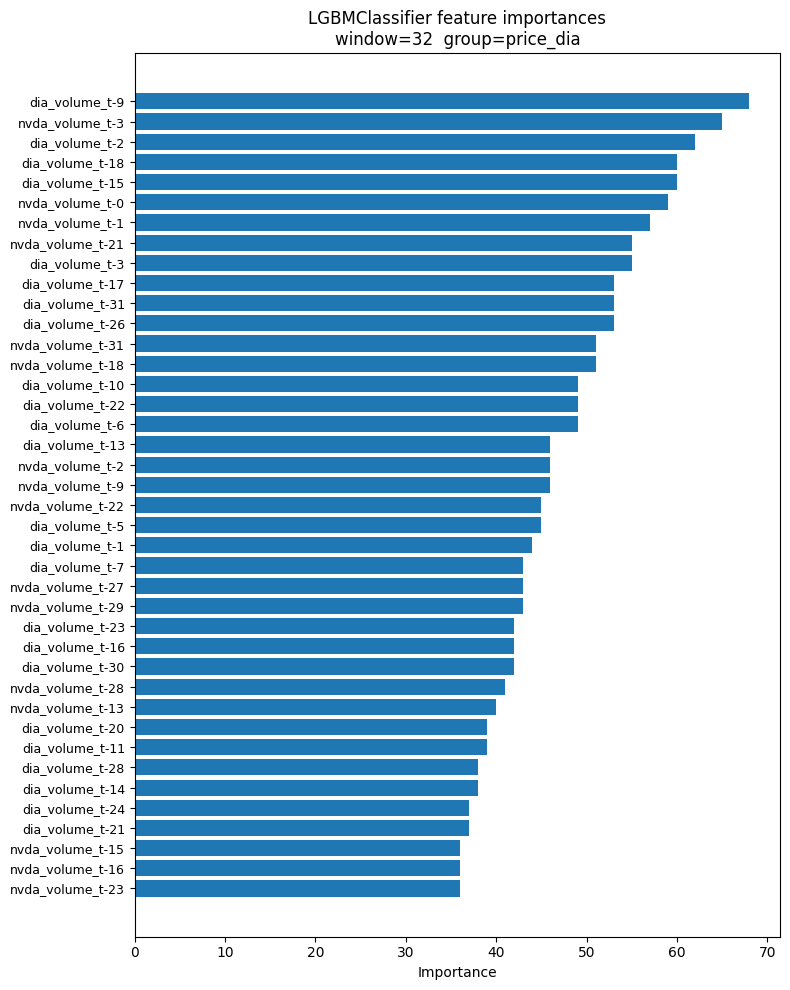

[saved] models/feature_importances\fi_w32_price_iwm_RandomForestClassifier.png


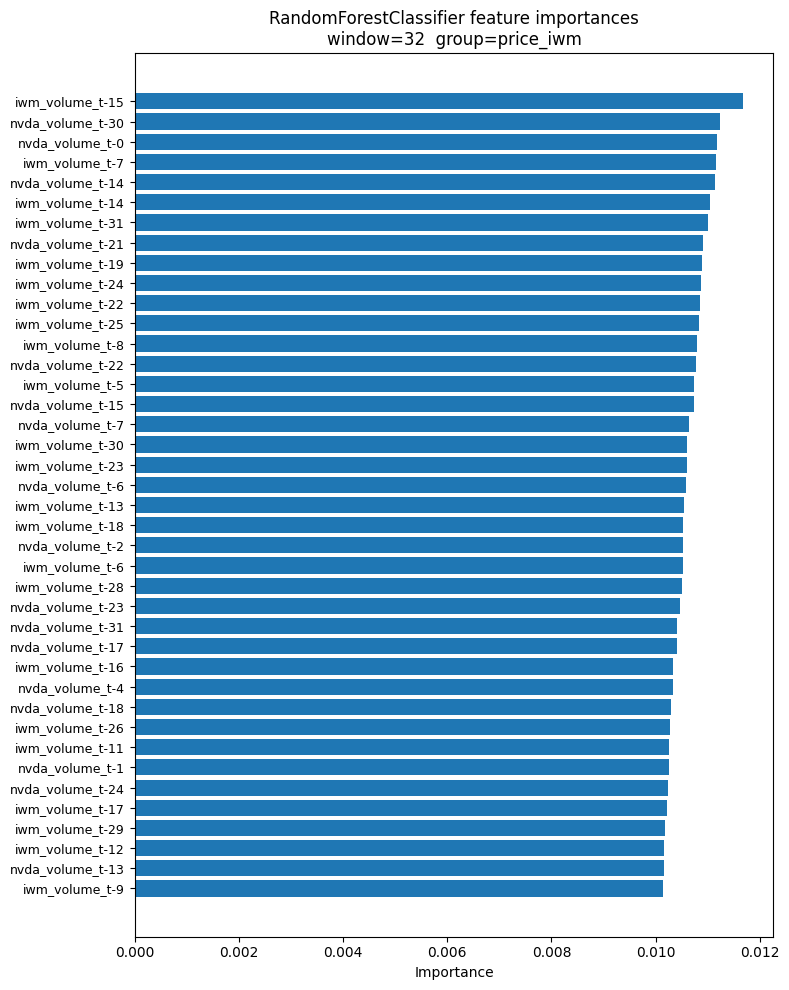

[saved] models/feature_importances\fi_w32_price_iwm_XGBClassifier.png


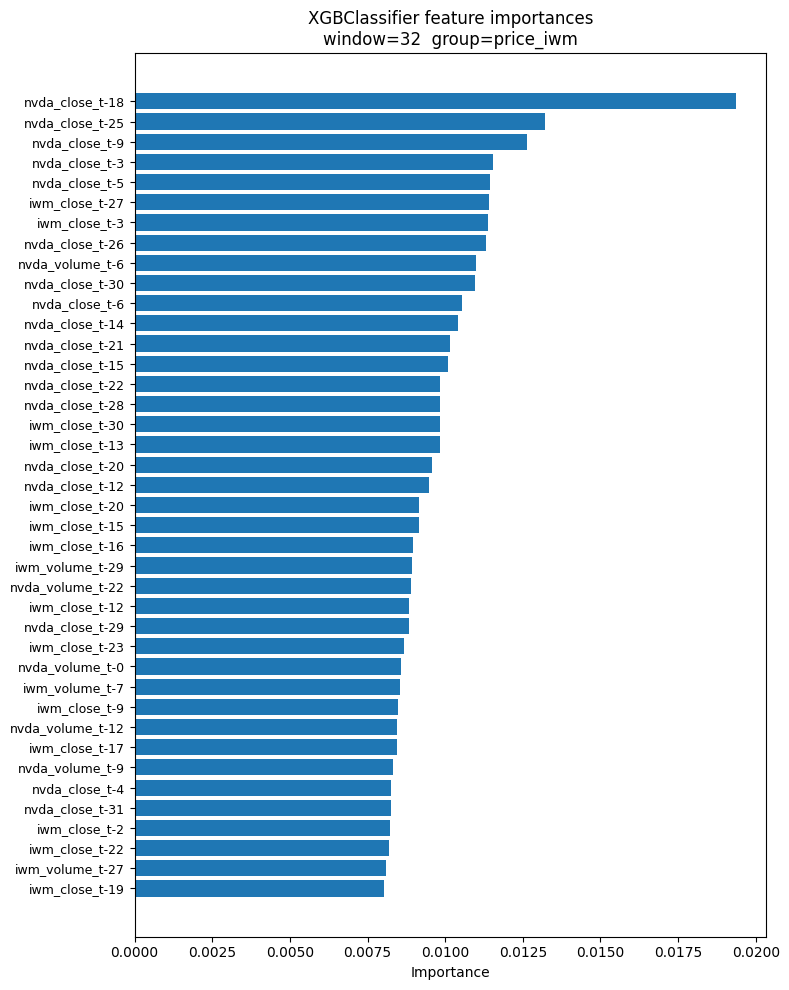

[saved] models/feature_importances\fi_w32_price_iwm_LGBMClassifier.png


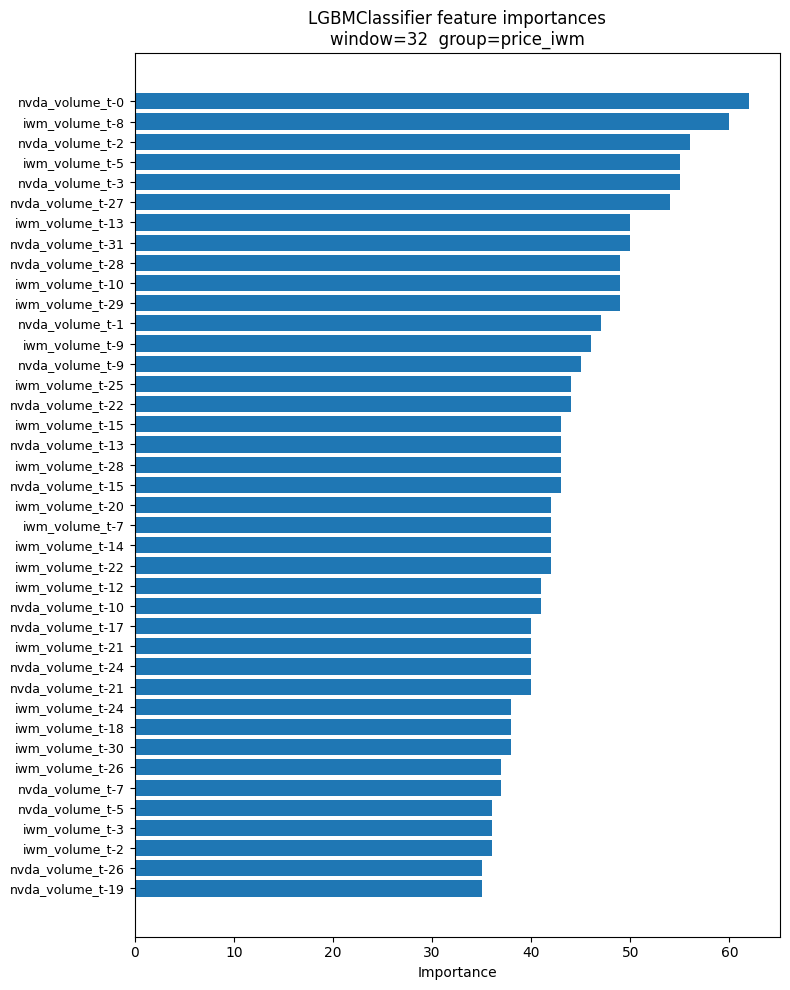

[saved] models/feature_importances\fi_w32_price_btc_RandomForestClassifier.png


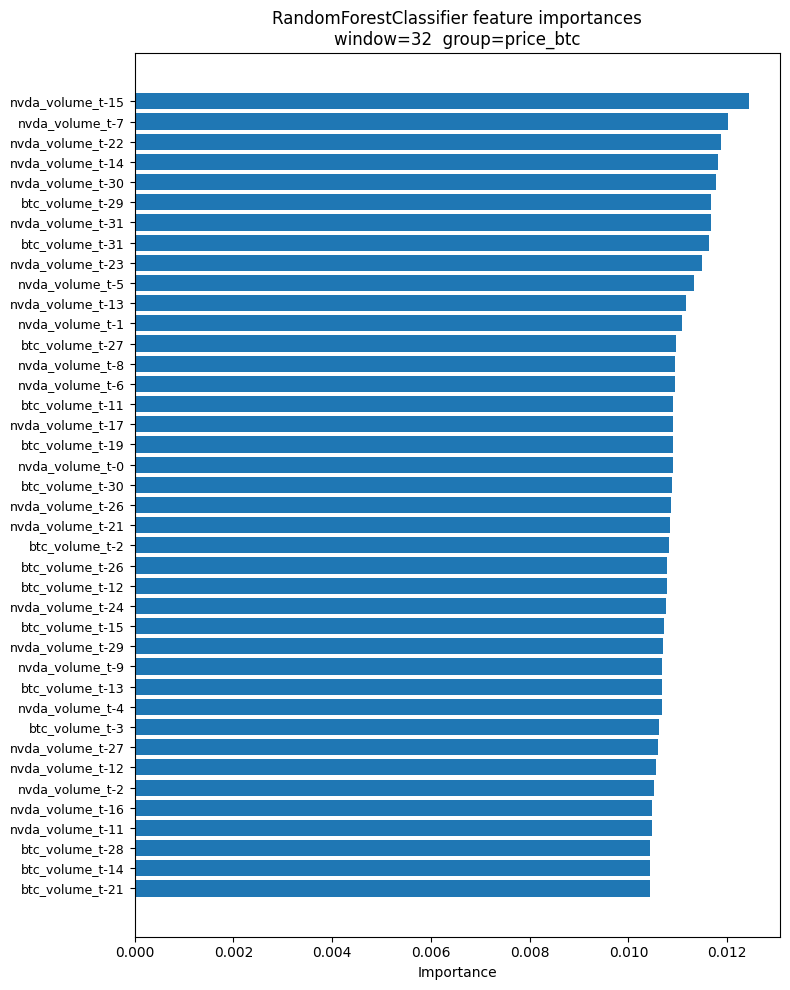

[saved] models/feature_importances\fi_w32_price_btc_XGBClassifier.png


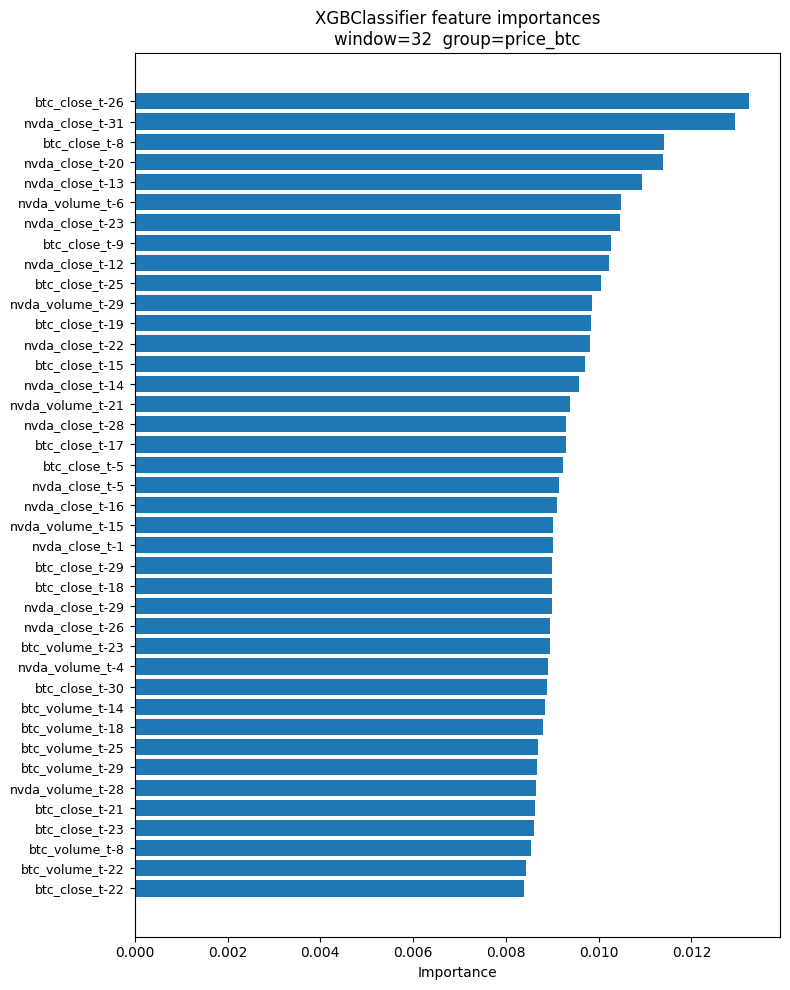

[saved] models/feature_importances\fi_w32_price_btc_LGBMClassifier.png


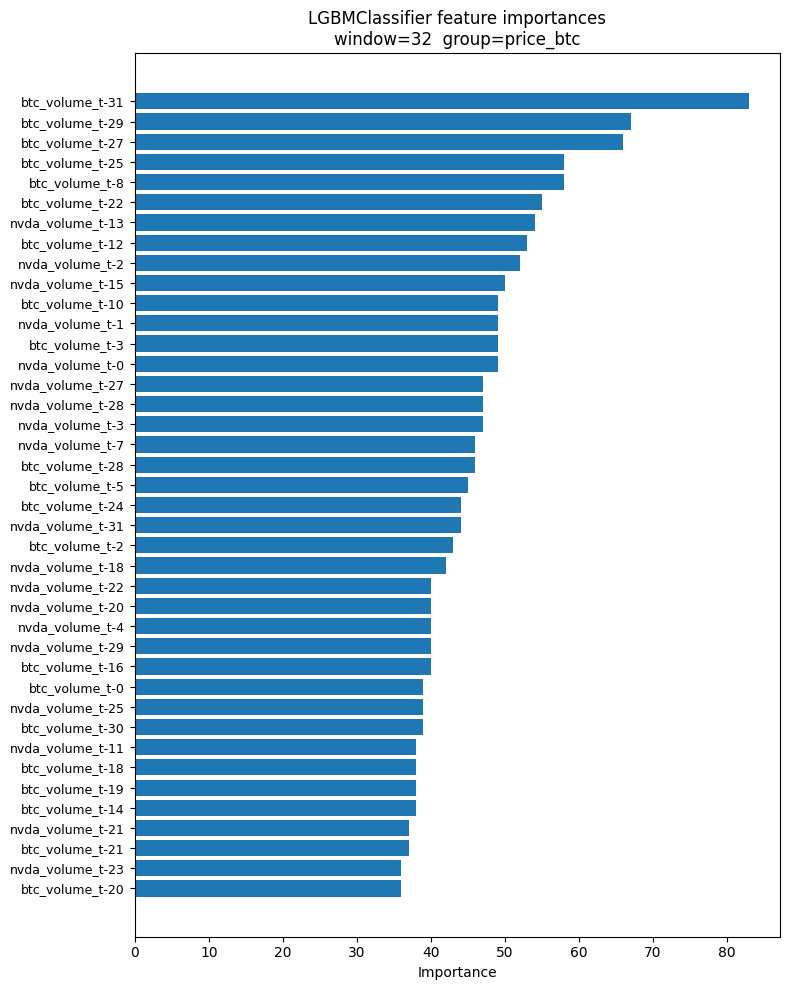

[saved] models/feature_importances\fi_w32_price_gold_RandomForestClassifier.png


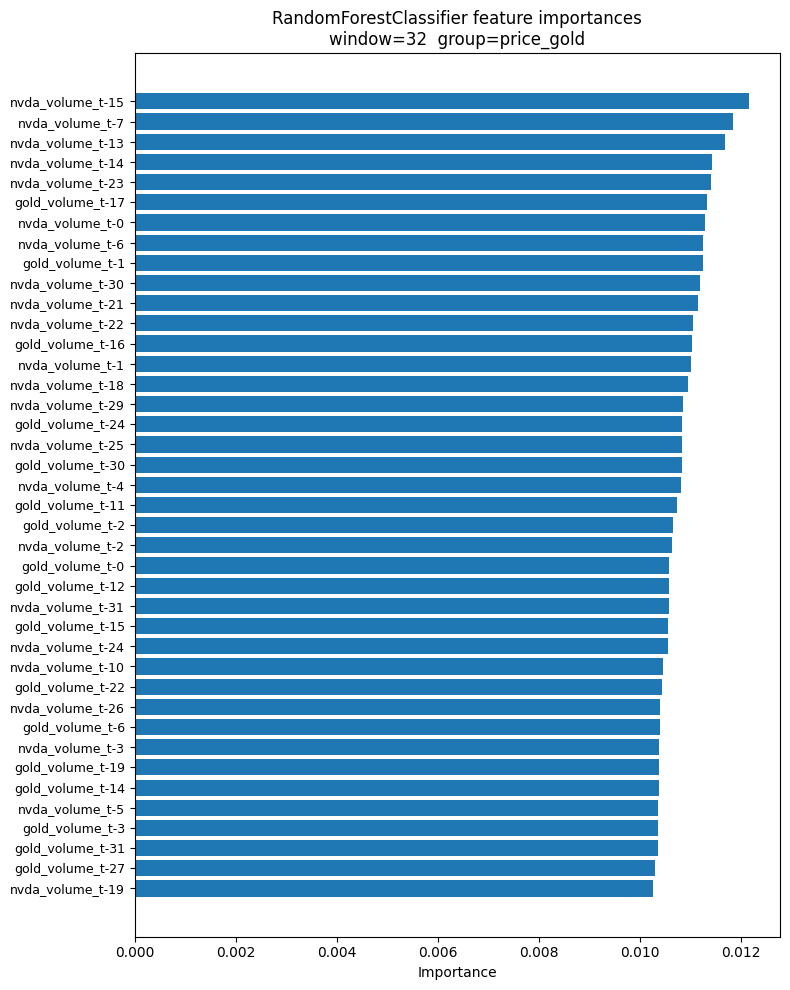

[saved] models/feature_importances\fi_w32_price_gold_XGBClassifier.png


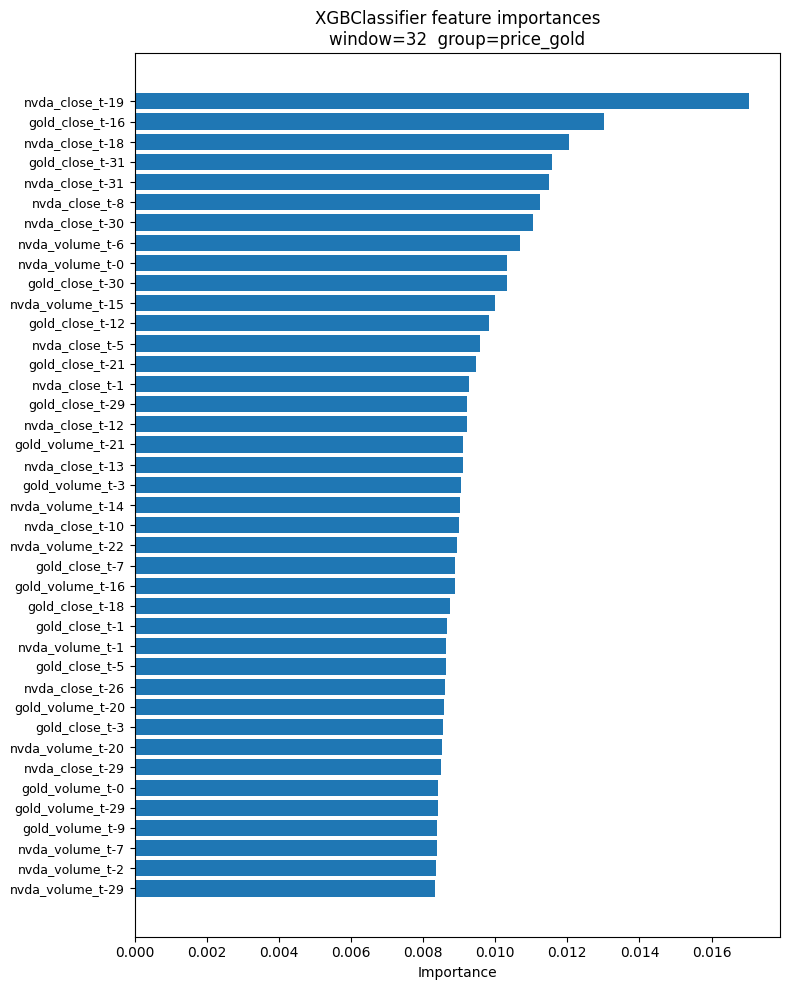

[saved] models/feature_importances\fi_w32_price_gold_LGBMClassifier.png


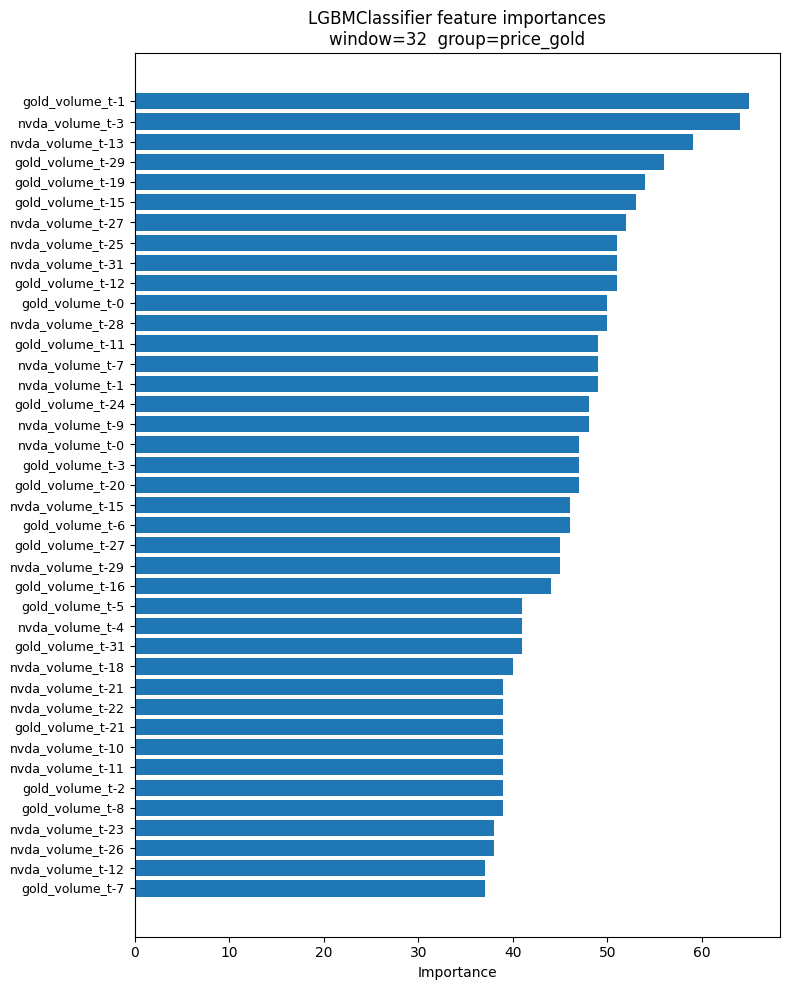

[saved] models/feature_importances\fi_w32_price_all_stocks_RandomForestClassifier.png


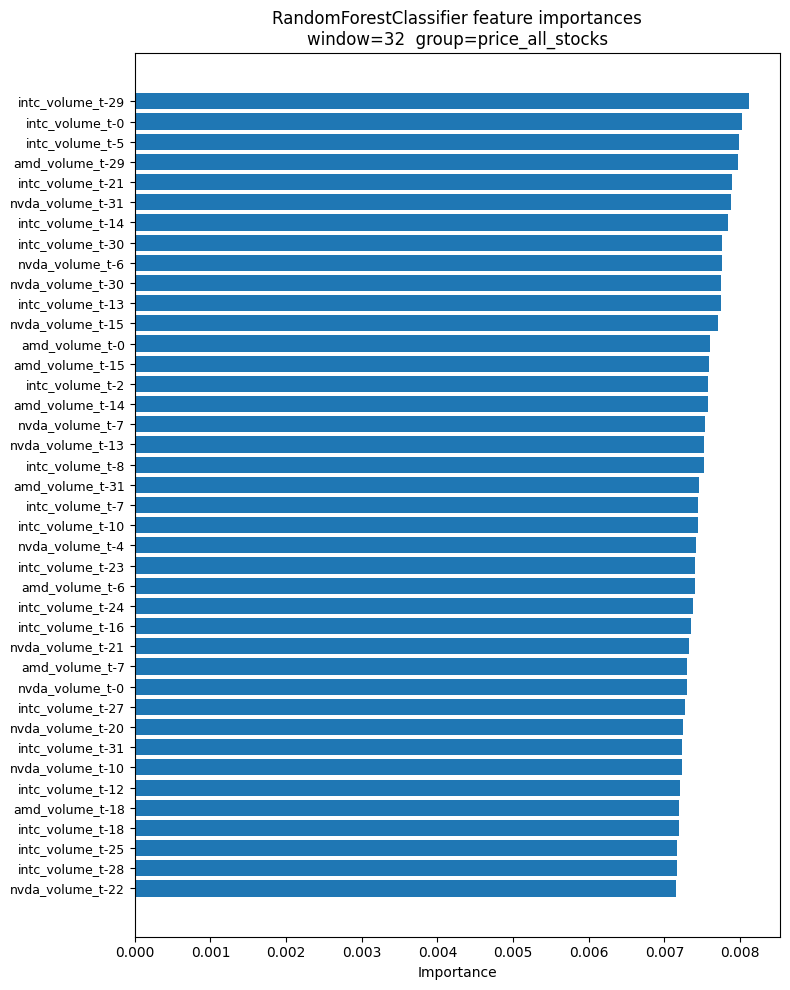

[saved] models/feature_importances\fi_w32_price_all_stocks_XGBClassifier.png


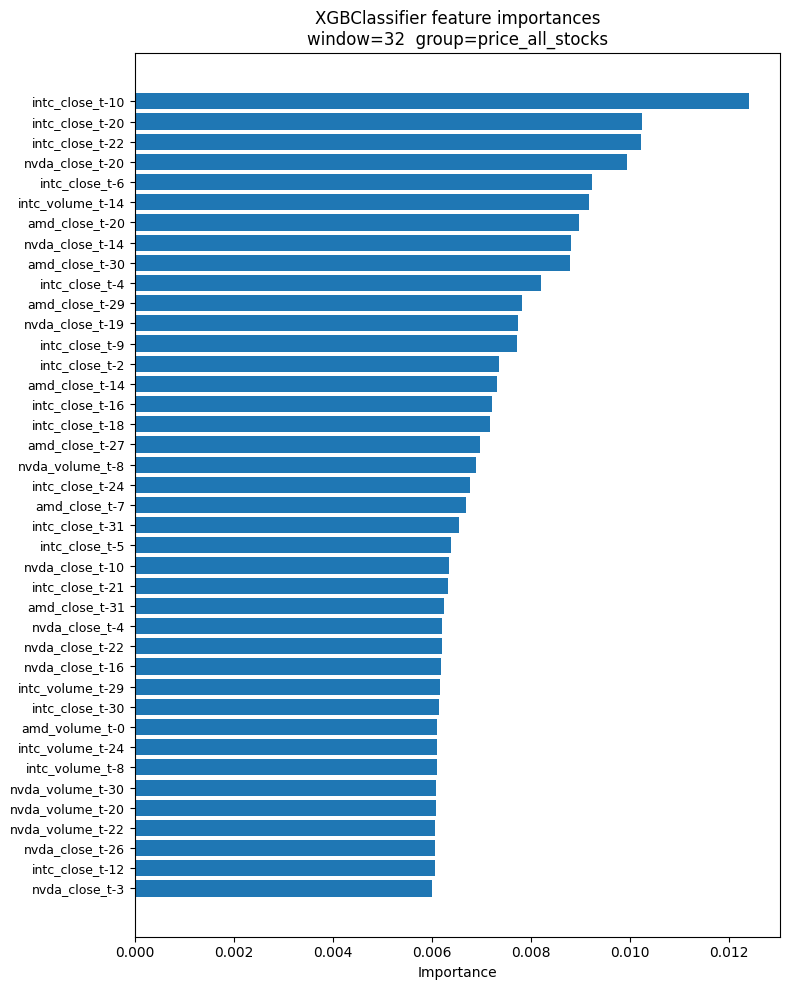

[saved] models/feature_importances\fi_w32_price_all_stocks_LGBMClassifier.png


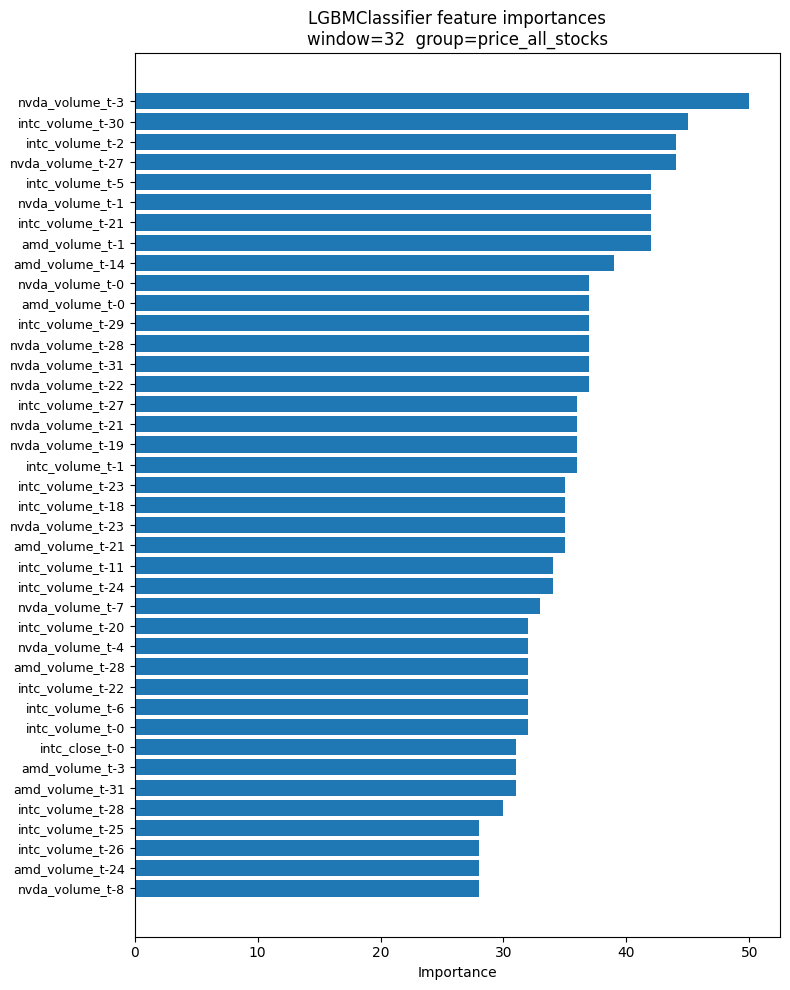

[saved] models/feature_importances\fi_w32_price_all_etf_RandomForestClassifier.png


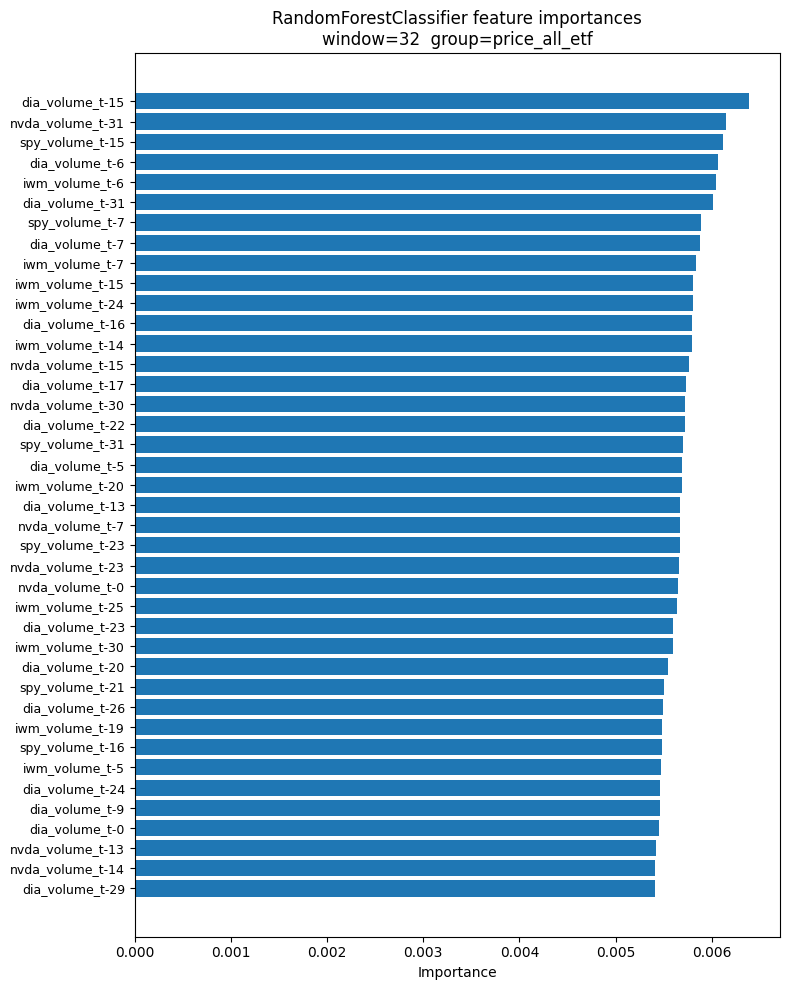

[saved] models/feature_importances\fi_w32_price_all_etf_XGBClassifier.png


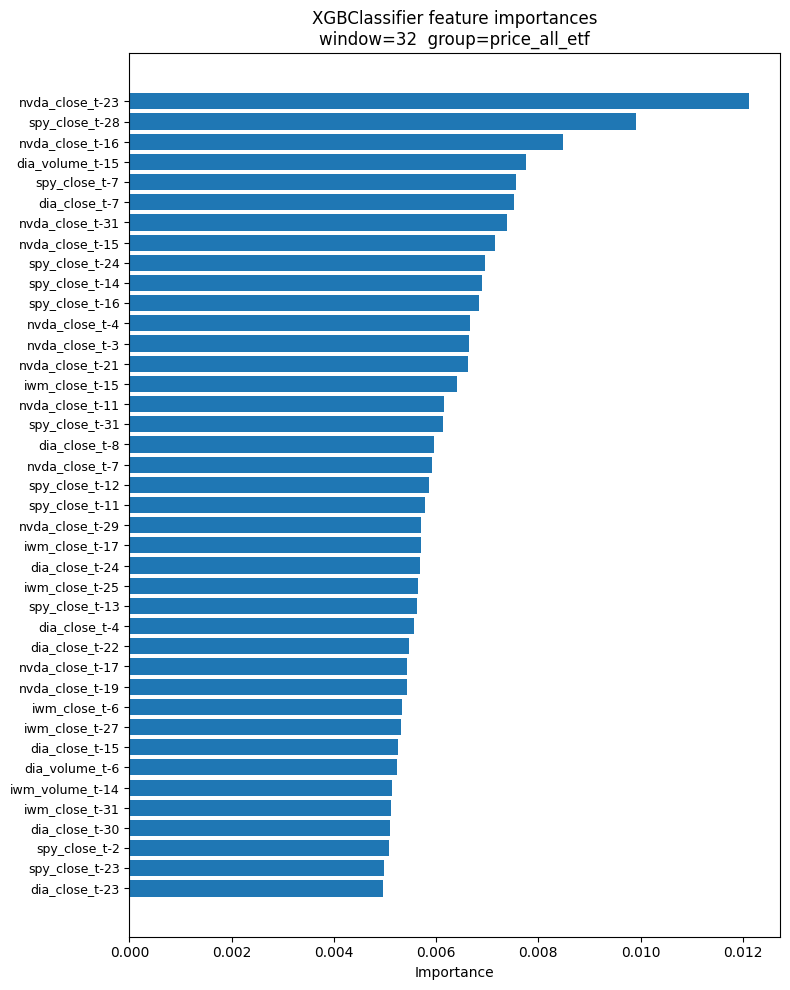

[saved] models/feature_importances\fi_w32_price_all_etf_LGBMClassifier.png


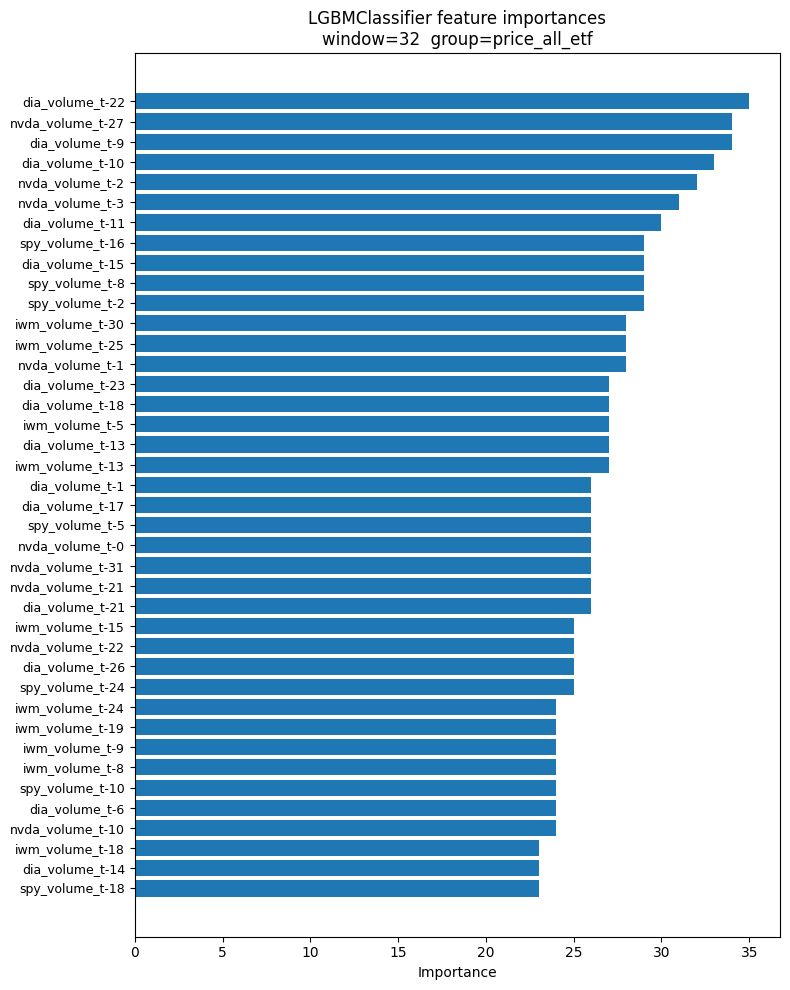

[saved] models/feature_importances\fi_w32_price_all_alt_RandomForestClassifier.png


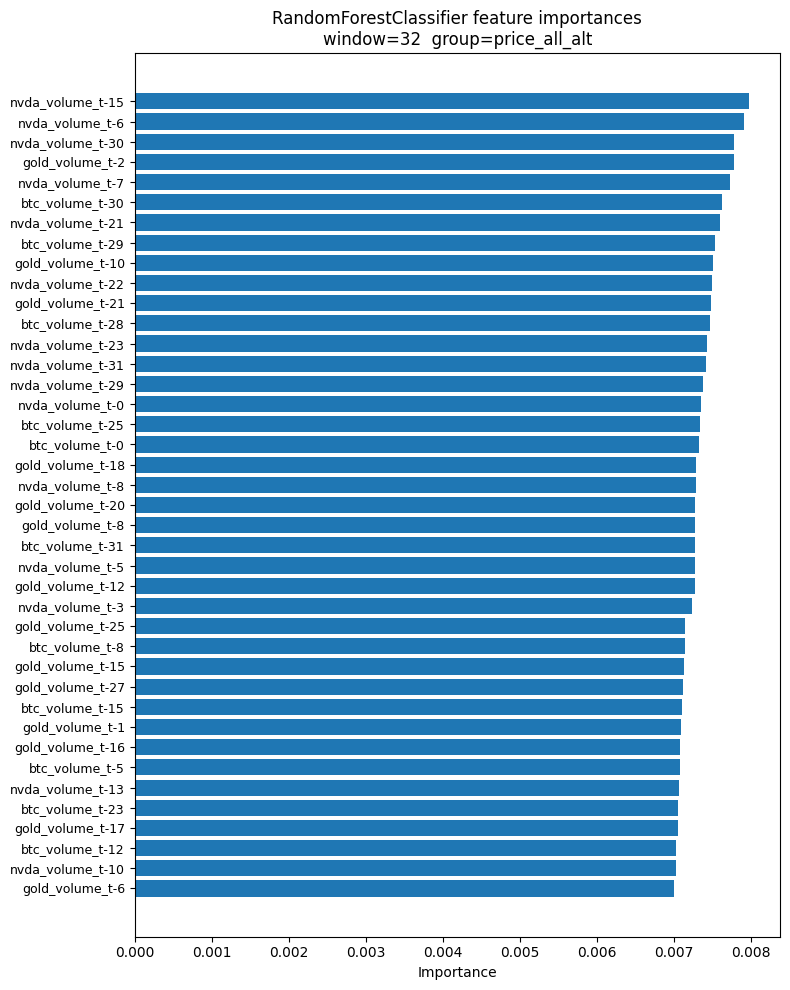

[saved] models/feature_importances\fi_w32_price_all_alt_XGBClassifier.png


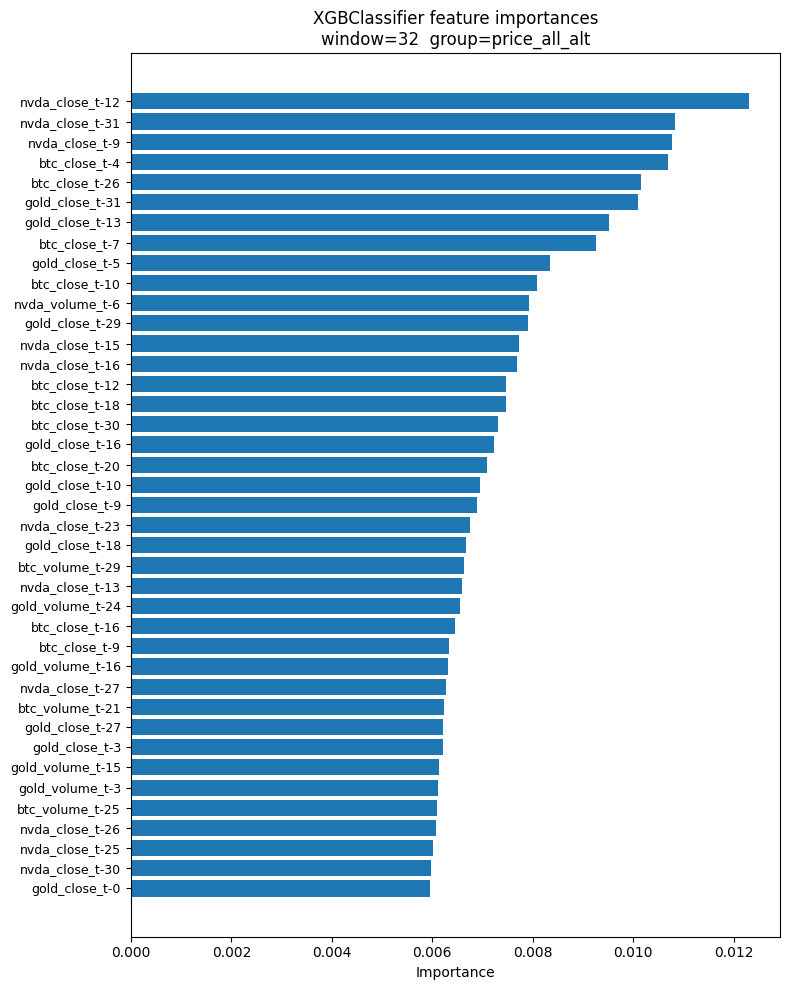

[saved] models/feature_importances\fi_w32_price_all_alt_LGBMClassifier.png


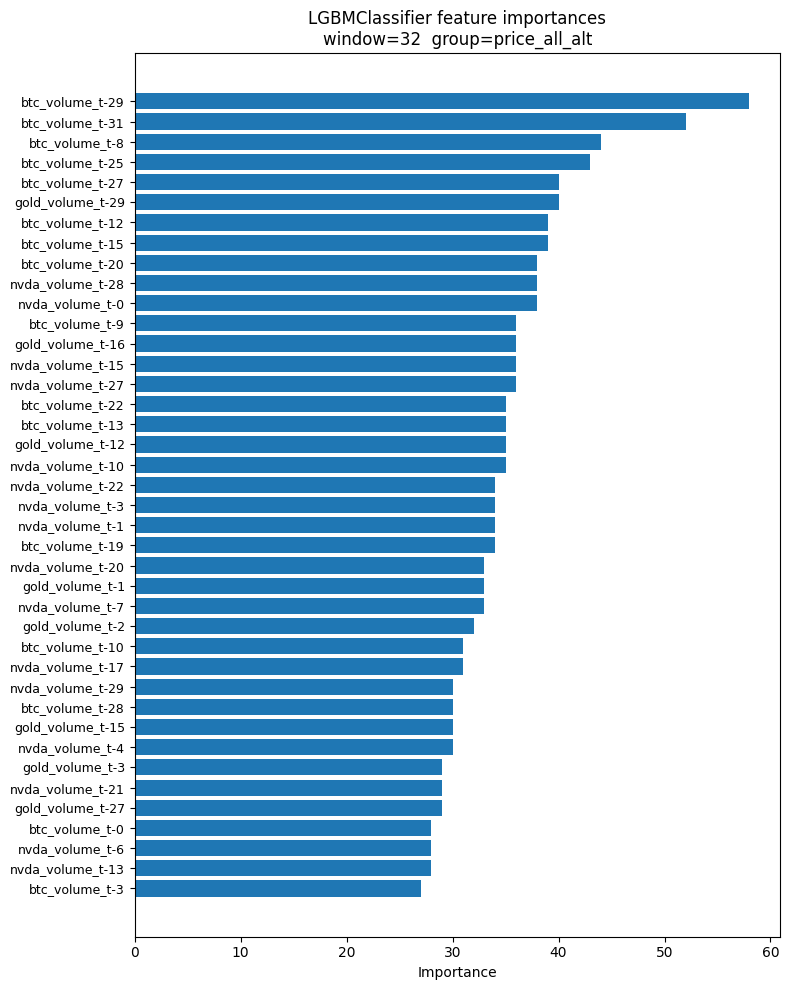

[saved] models/feature_importances\fi_w32_price_all_market_RandomForestClassifier.png


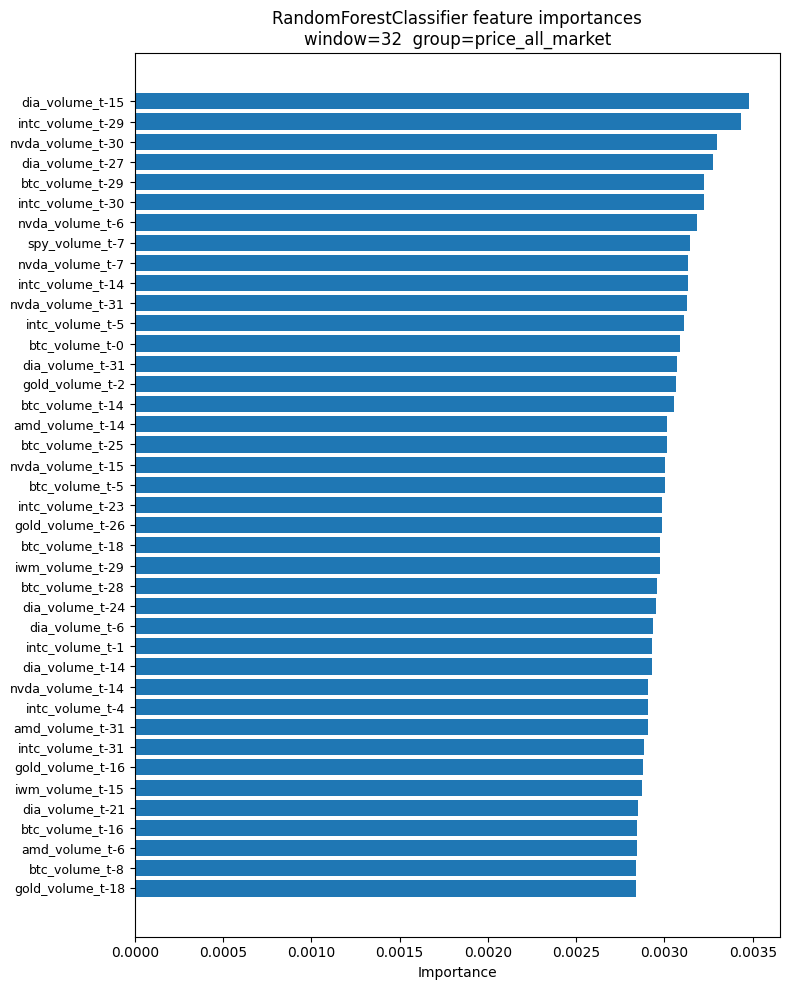

[saved] models/feature_importances\fi_w32_price_all_market_XGBClassifier.png


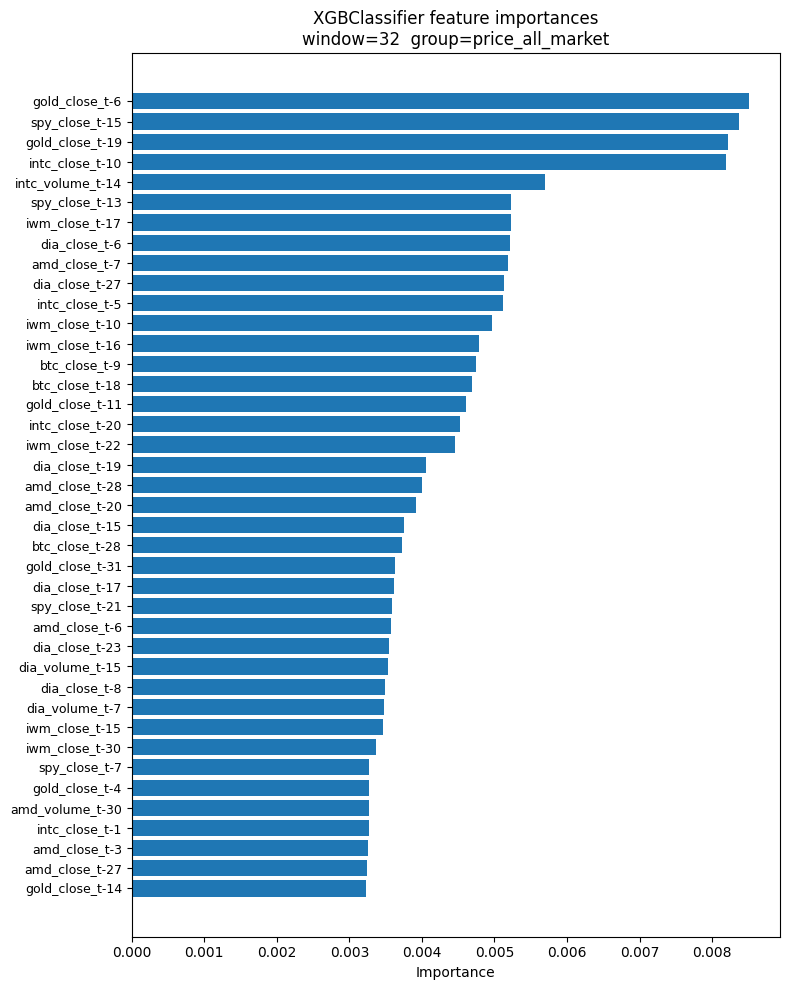

[saved] models/feature_importances\fi_w32_price_all_market_LGBMClassifier.png


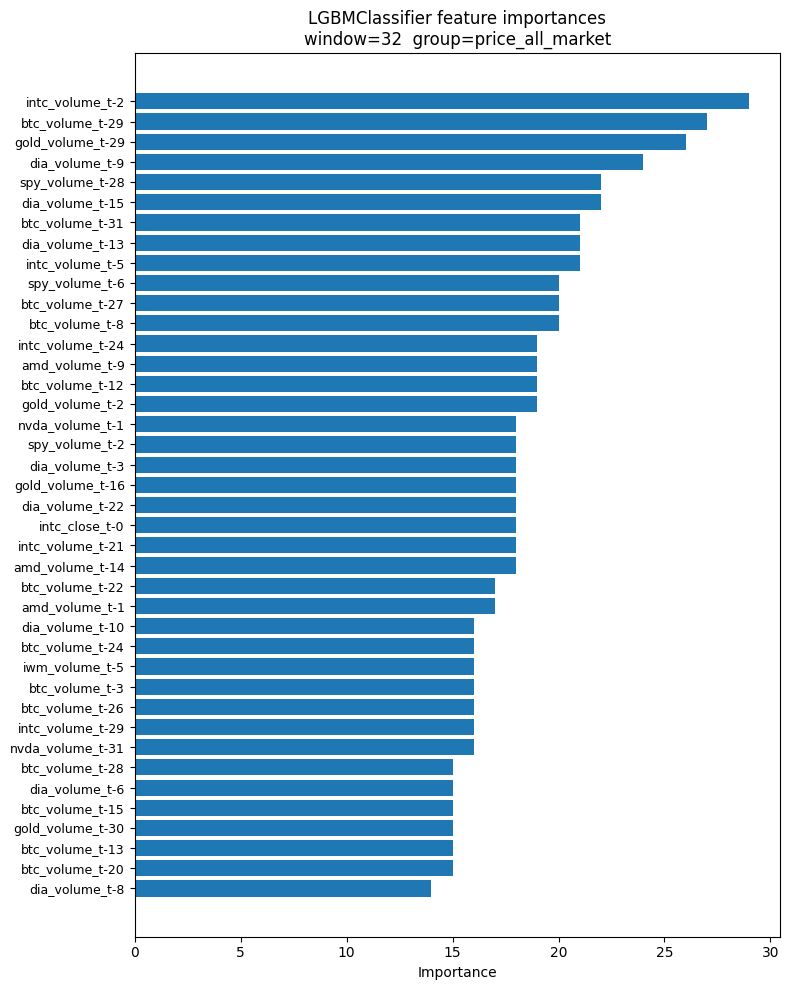

[saved] models/feature_importances\fi_w48_price_amd_RandomForestClassifier.png


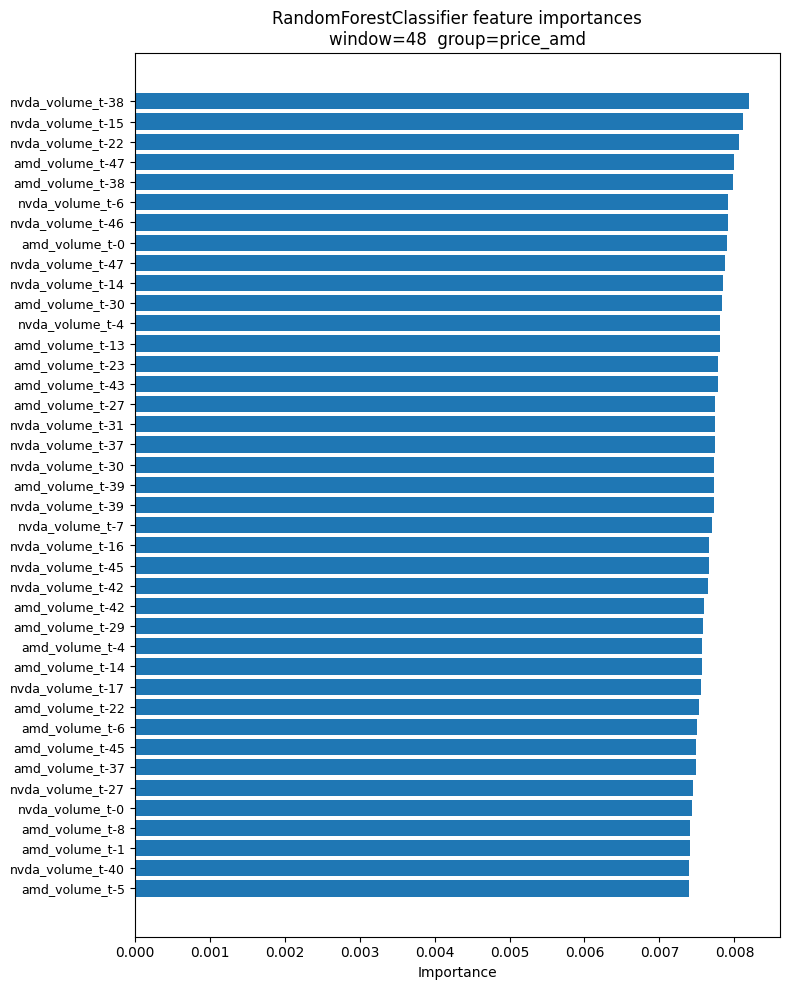

[saved] models/feature_importances\fi_w48_price_amd_XGBClassifier.png


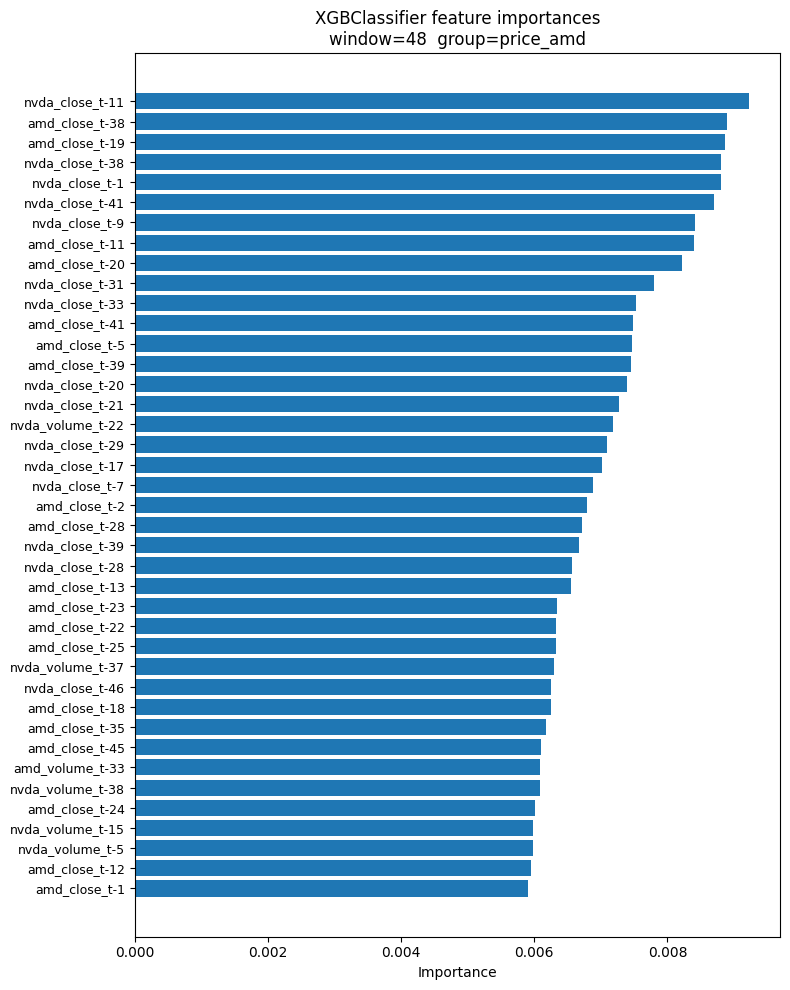

[saved] models/feature_importances\fi_w48_price_amd_LGBMClassifier.png


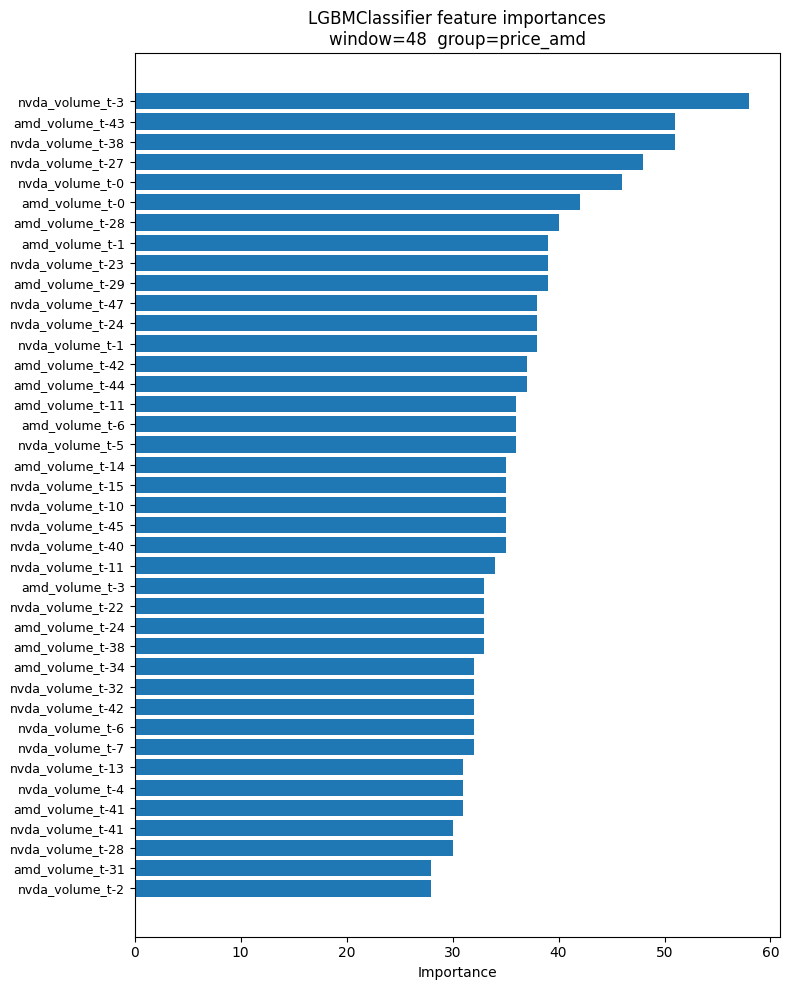

[saved] models/feature_importances\fi_w48_price_intc_RandomForestClassifier.png


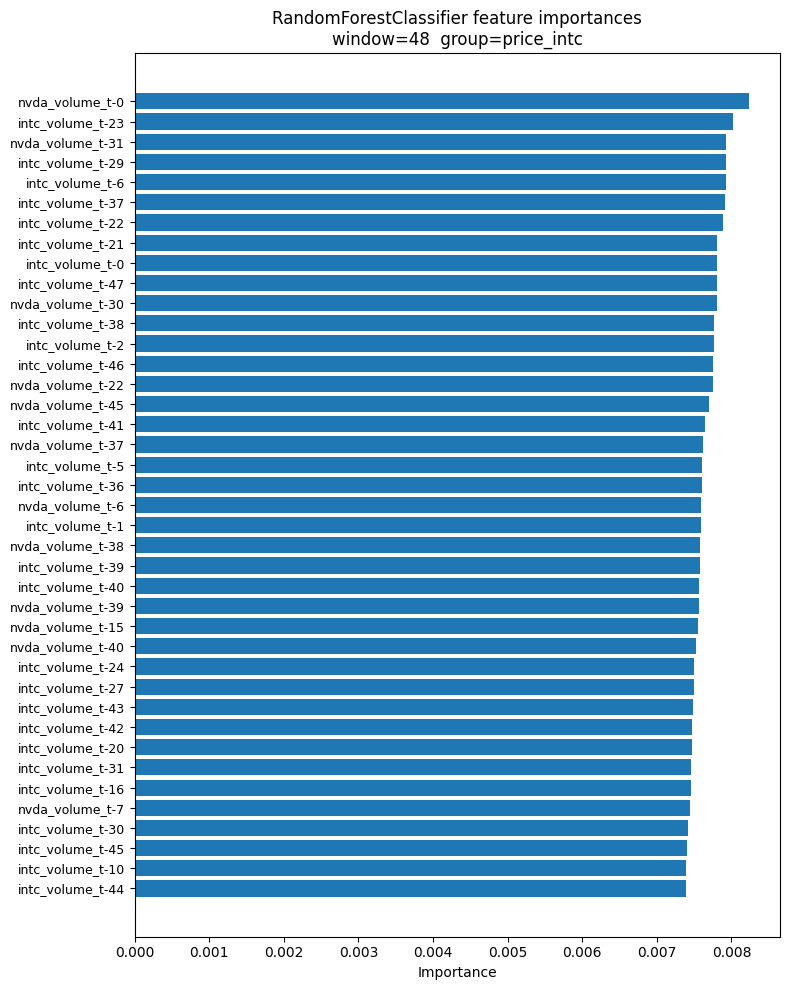

[saved] models/feature_importances\fi_w48_price_intc_XGBClassifier.png


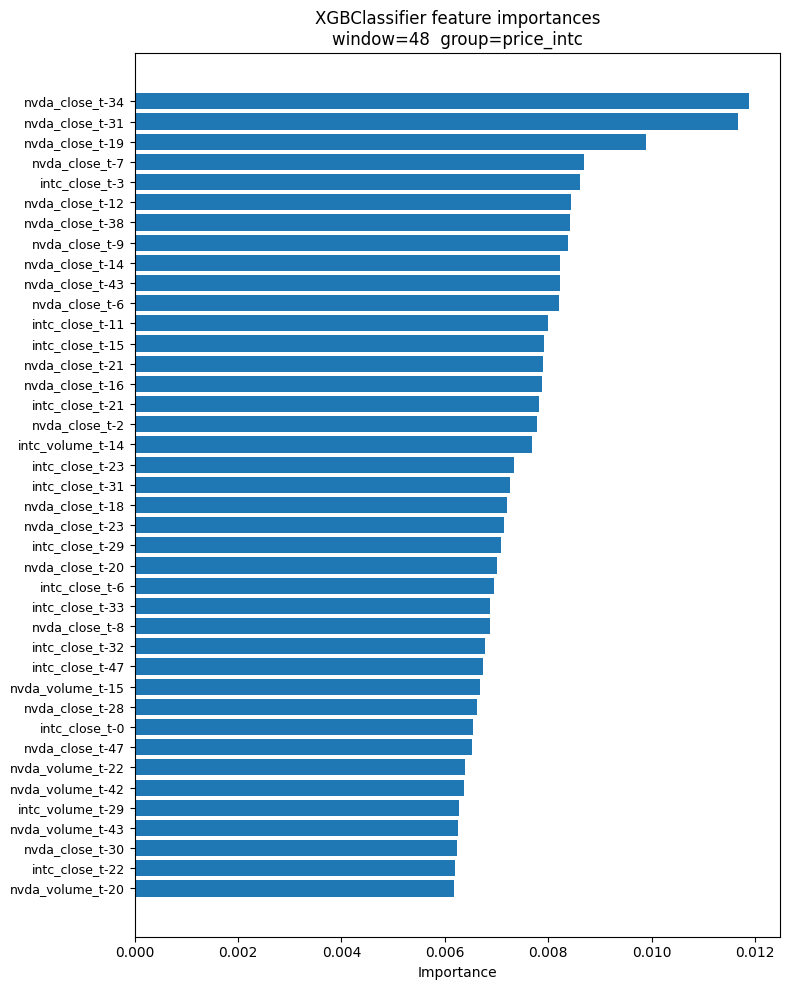

[saved] models/feature_importances\fi_w48_price_intc_LGBMClassifier.png


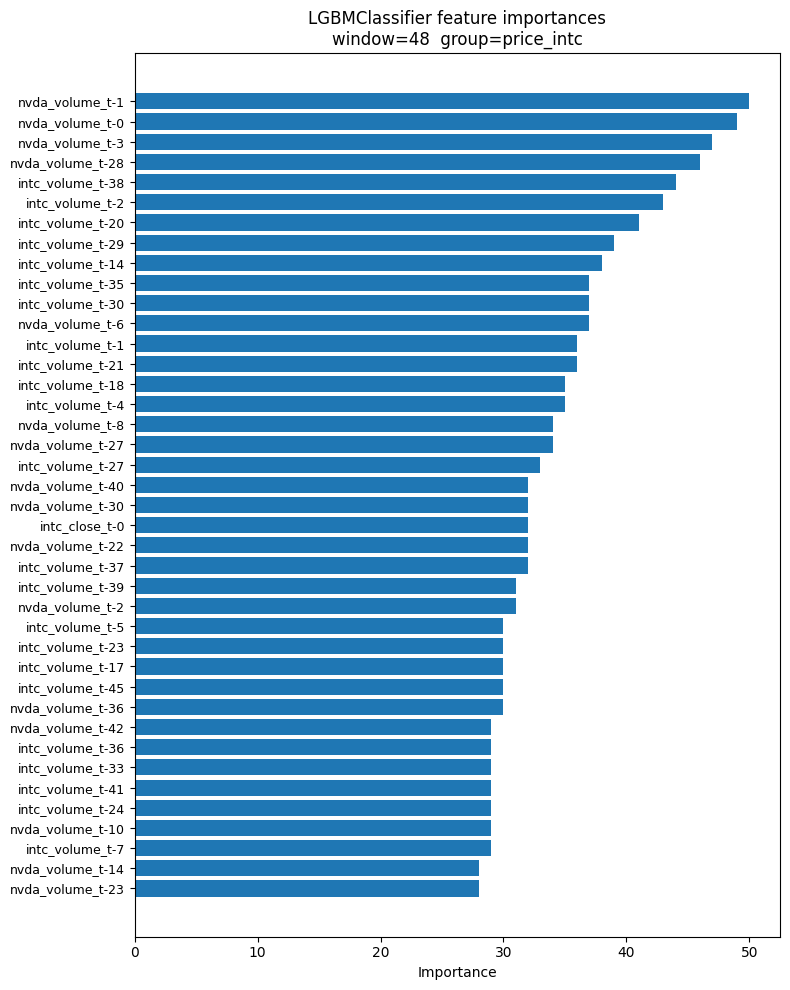

[saved] models/feature_importances\fi_w48_price_spy_RandomForestClassifier.png


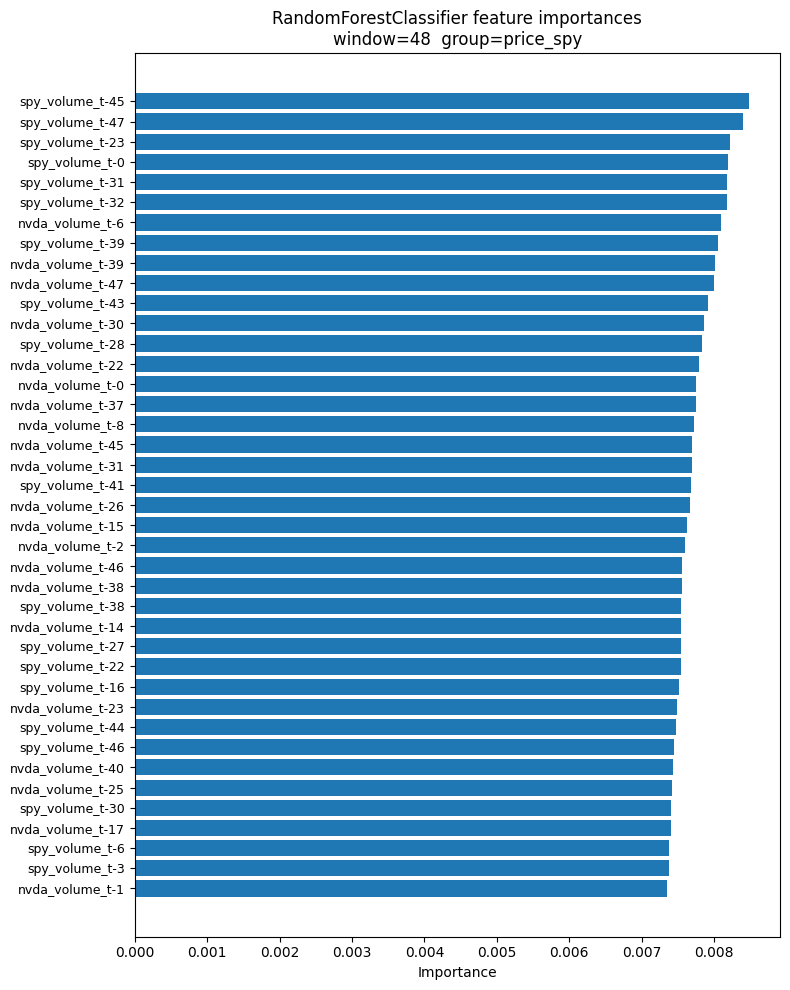

[saved] models/feature_importances\fi_w48_price_spy_XGBClassifier.png


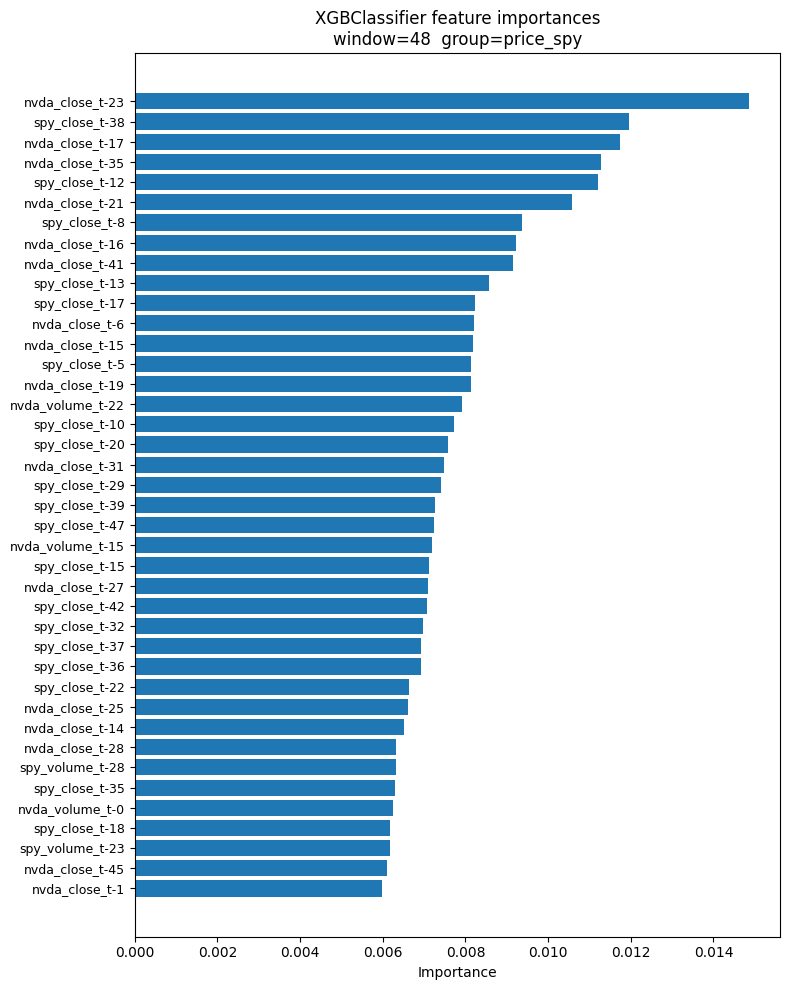

[saved] models/feature_importances\fi_w48_price_spy_LGBMClassifier.png


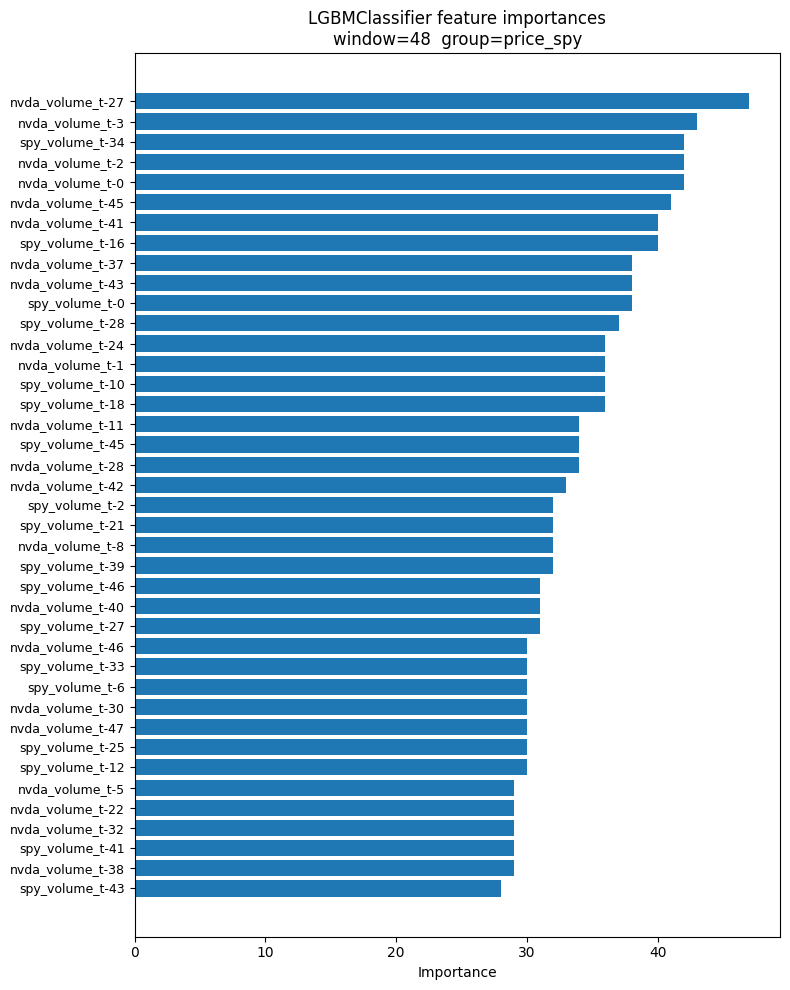

[saved] models/feature_importances\fi_w48_price_dia_RandomForestClassifier.png


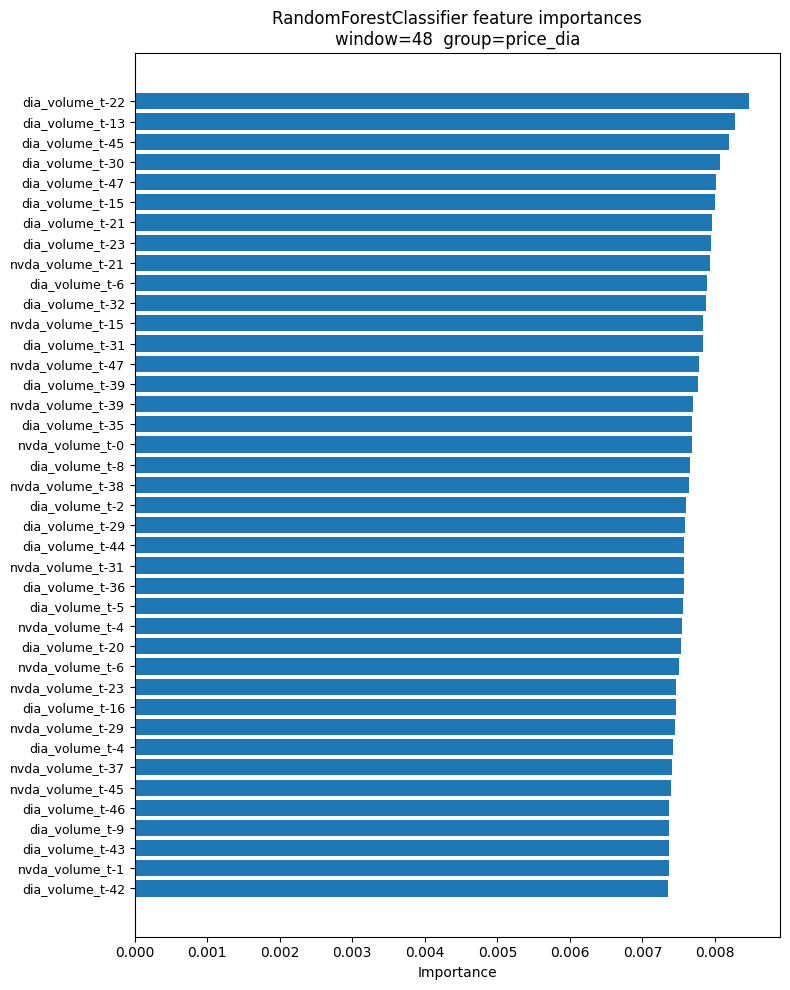

[saved] models/feature_importances\fi_w48_price_dia_XGBClassifier.png


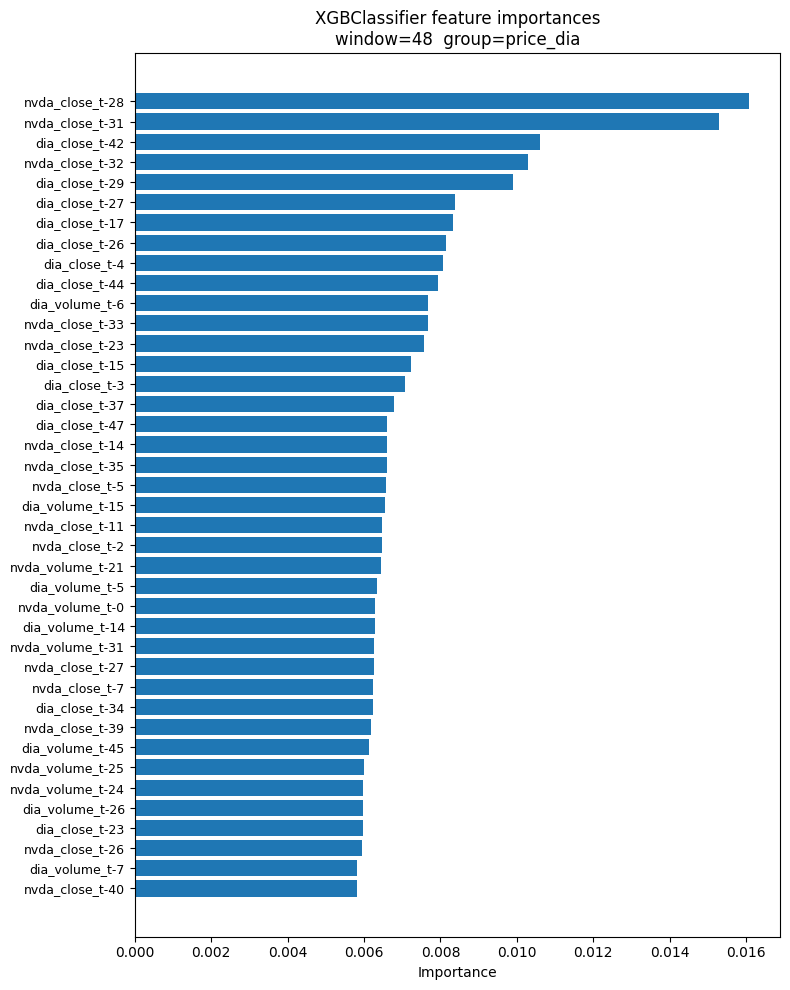

[saved] models/feature_importances\fi_w48_price_dia_LGBMClassifier.png


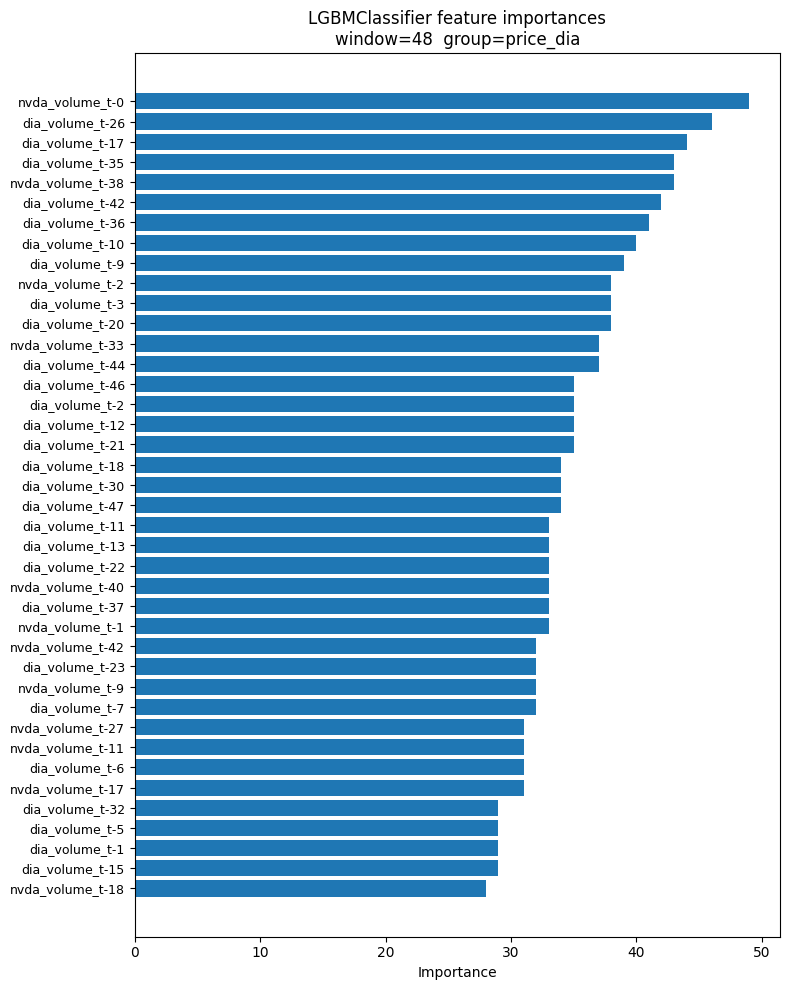

[saved] models/feature_importances\fi_w48_price_iwm_RandomForestClassifier.png


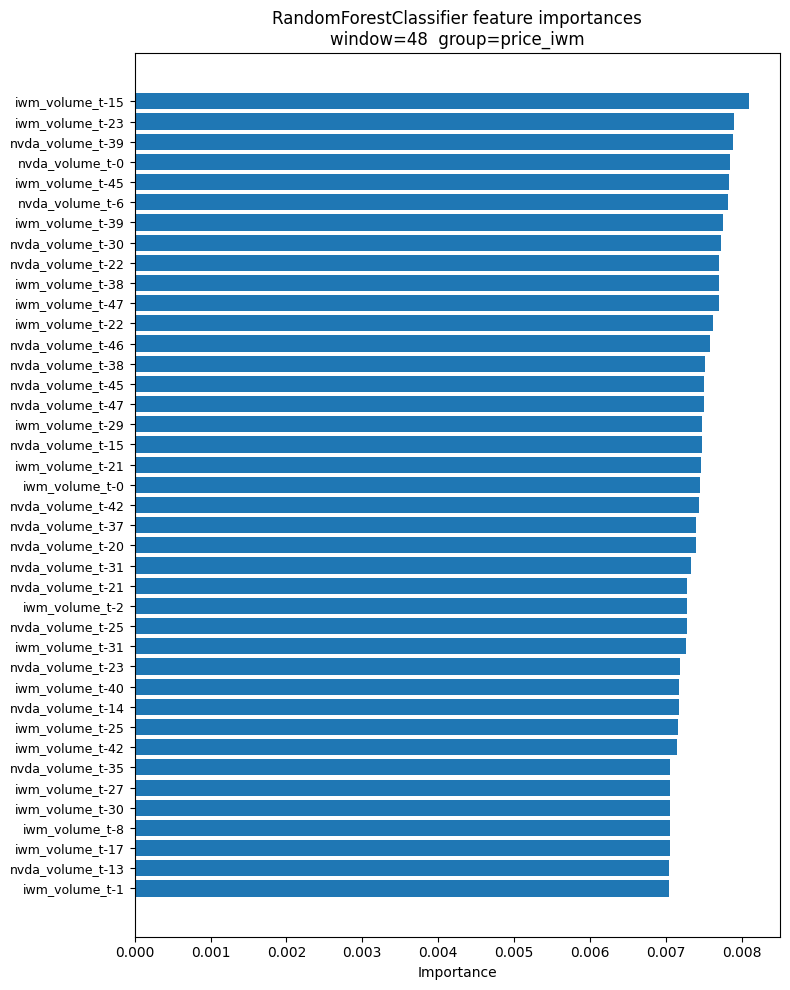

[saved] models/feature_importances\fi_w48_price_iwm_XGBClassifier.png


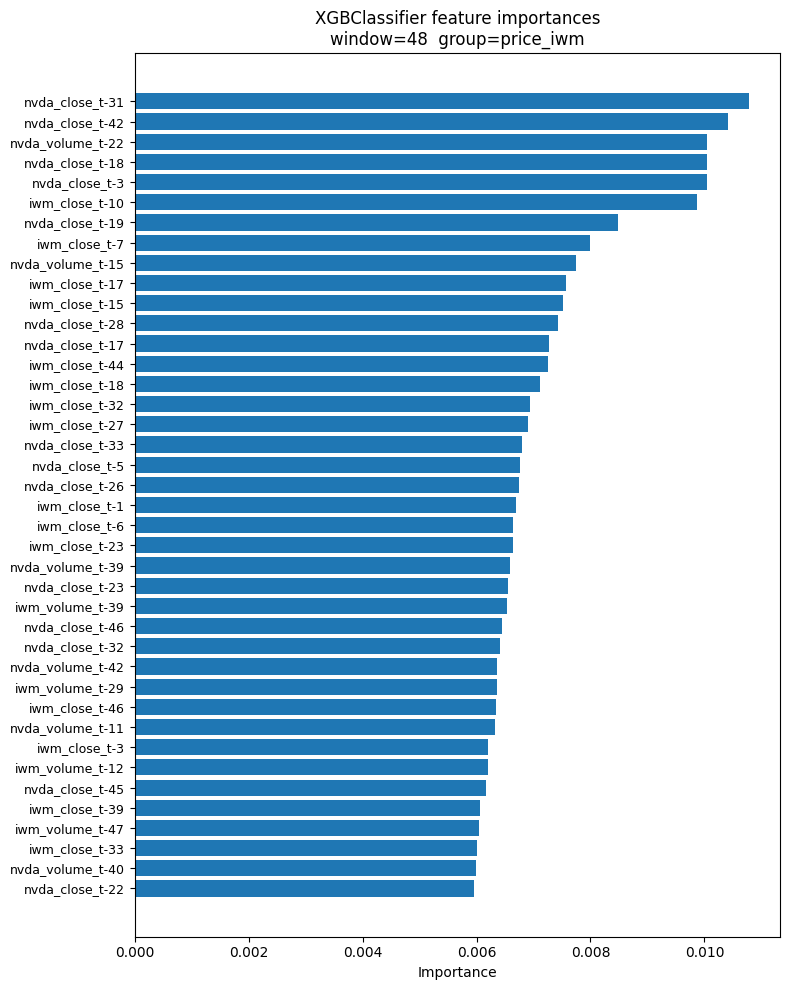

[saved] models/feature_importances\fi_w48_price_iwm_LGBMClassifier.png


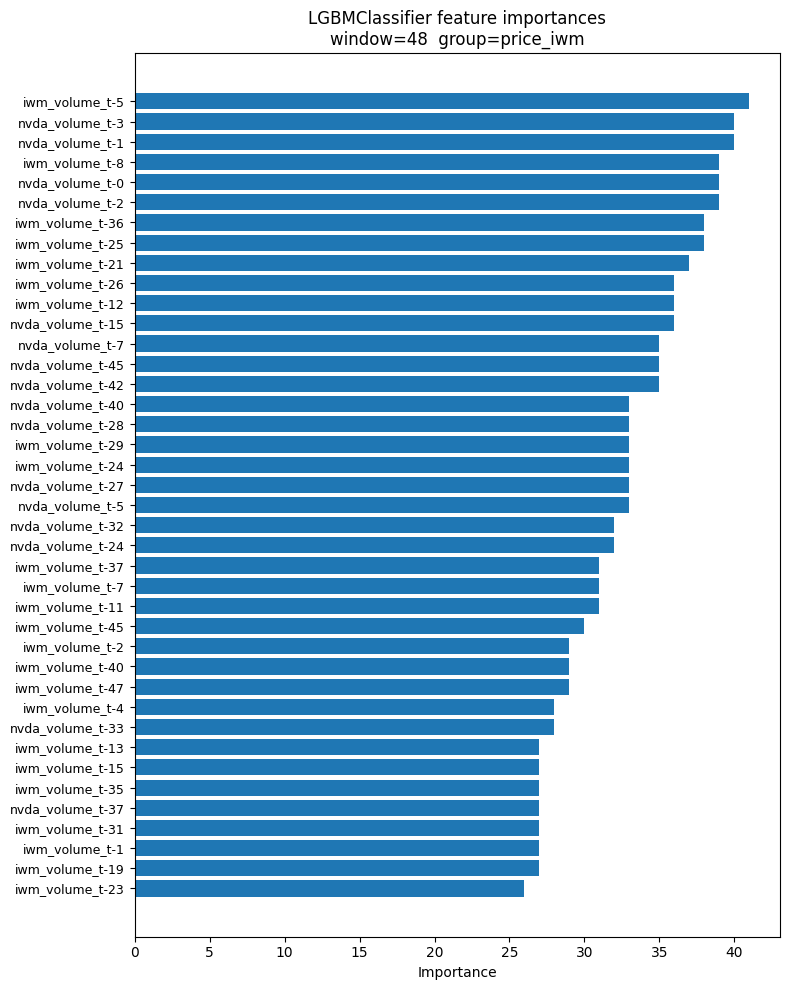

[saved] models/feature_importances\fi_w48_price_btc_RandomForestClassifier.png


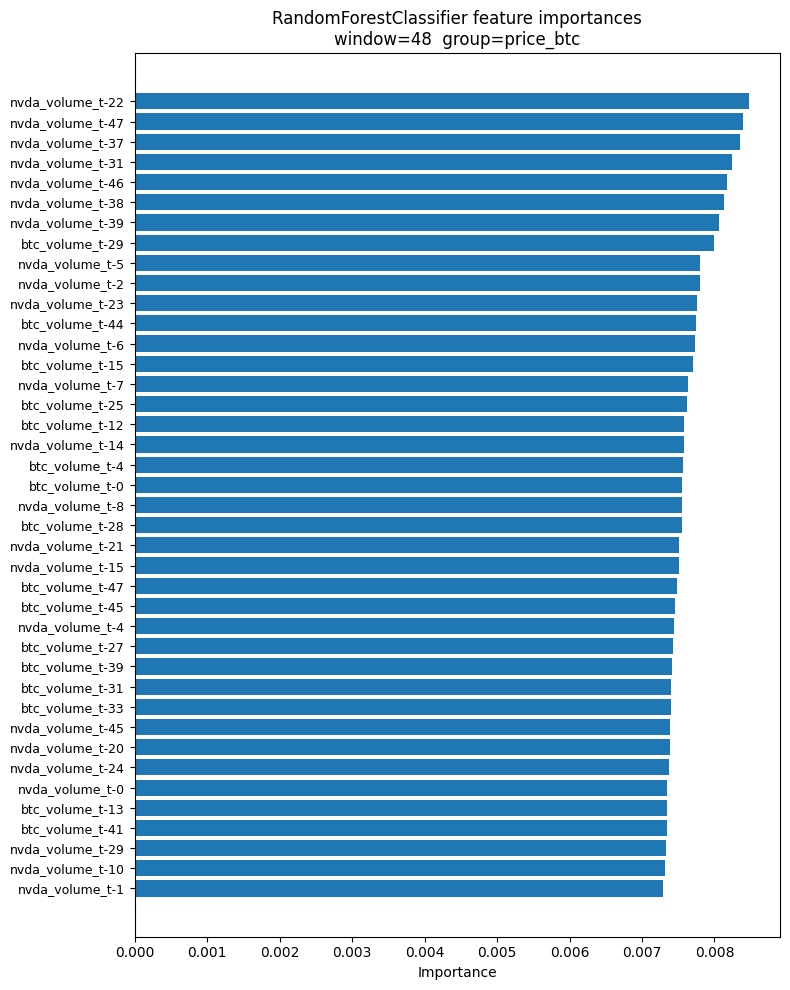

[saved] models/feature_importances\fi_w48_price_btc_XGBClassifier.png


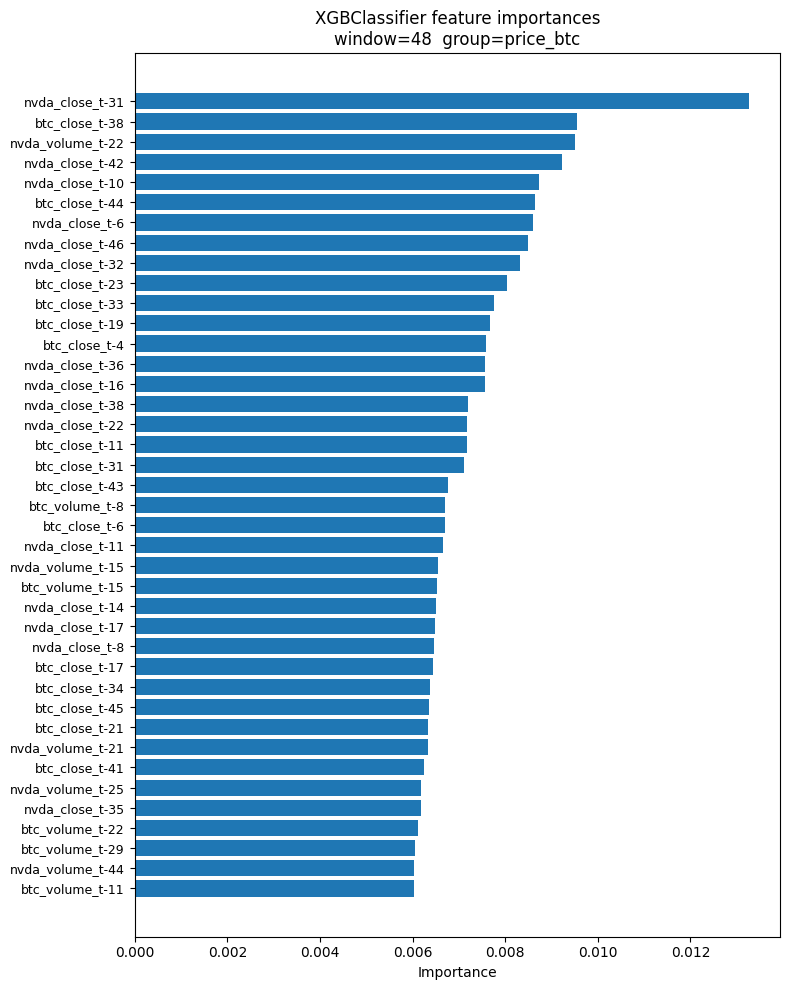

[saved] models/feature_importances\fi_w48_price_btc_LGBMClassifier.png


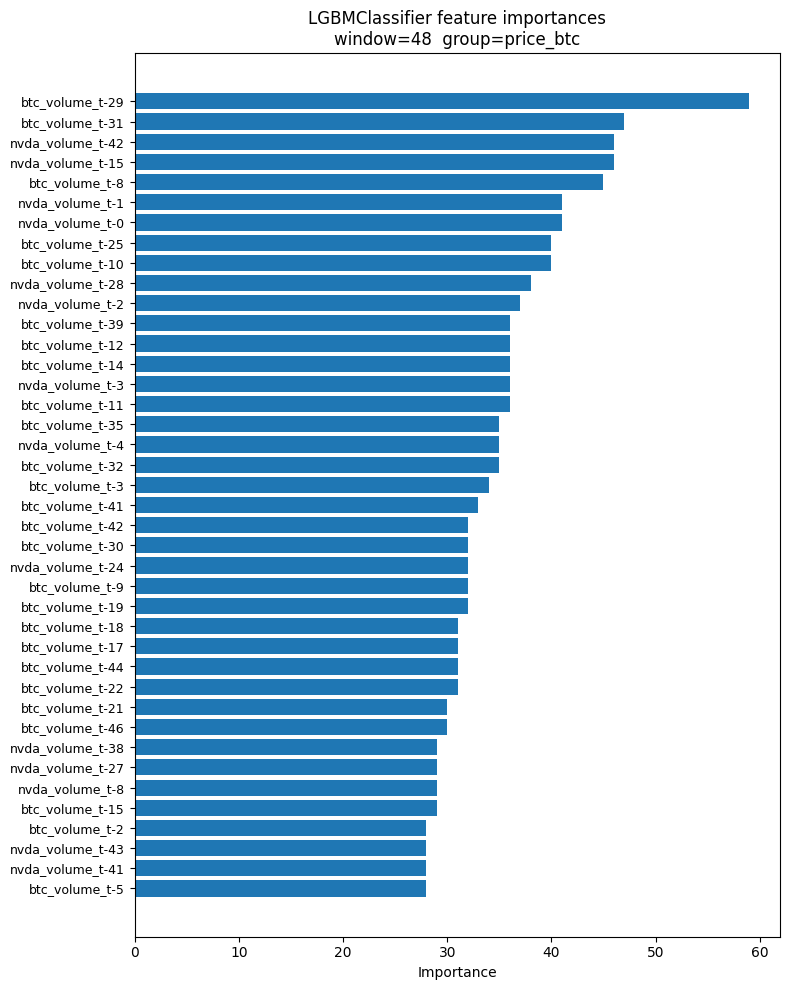

[saved] models/feature_importances\fi_w48_price_gold_RandomForestClassifier.png


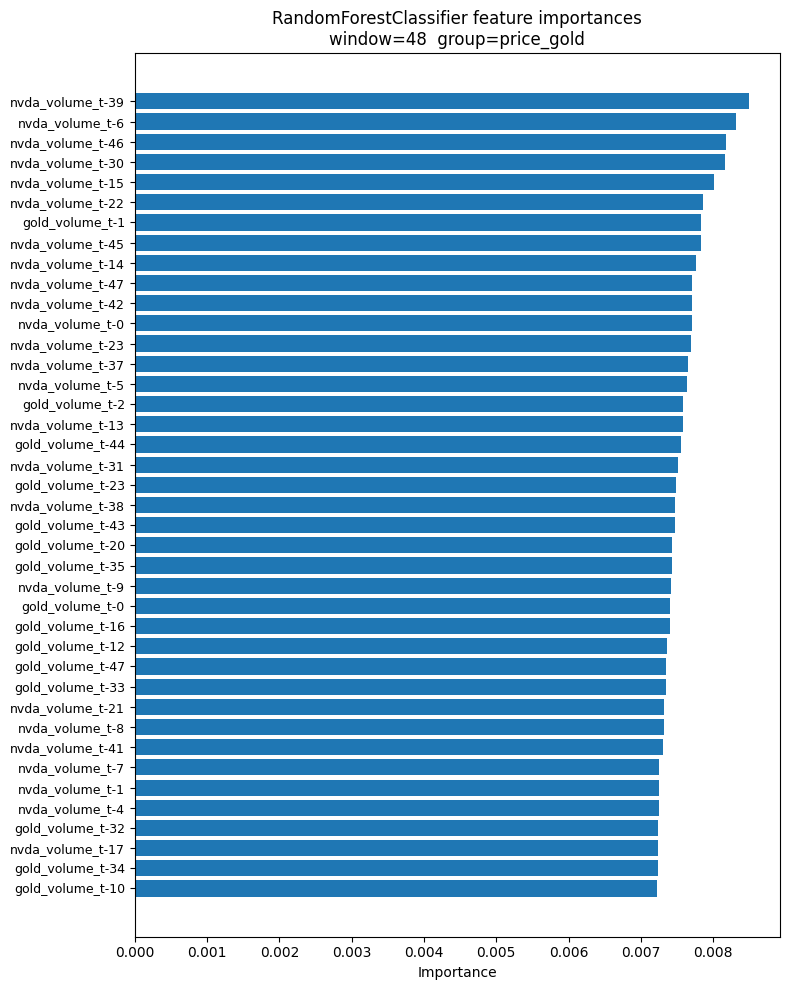

[saved] models/feature_importances\fi_w48_price_gold_XGBClassifier.png


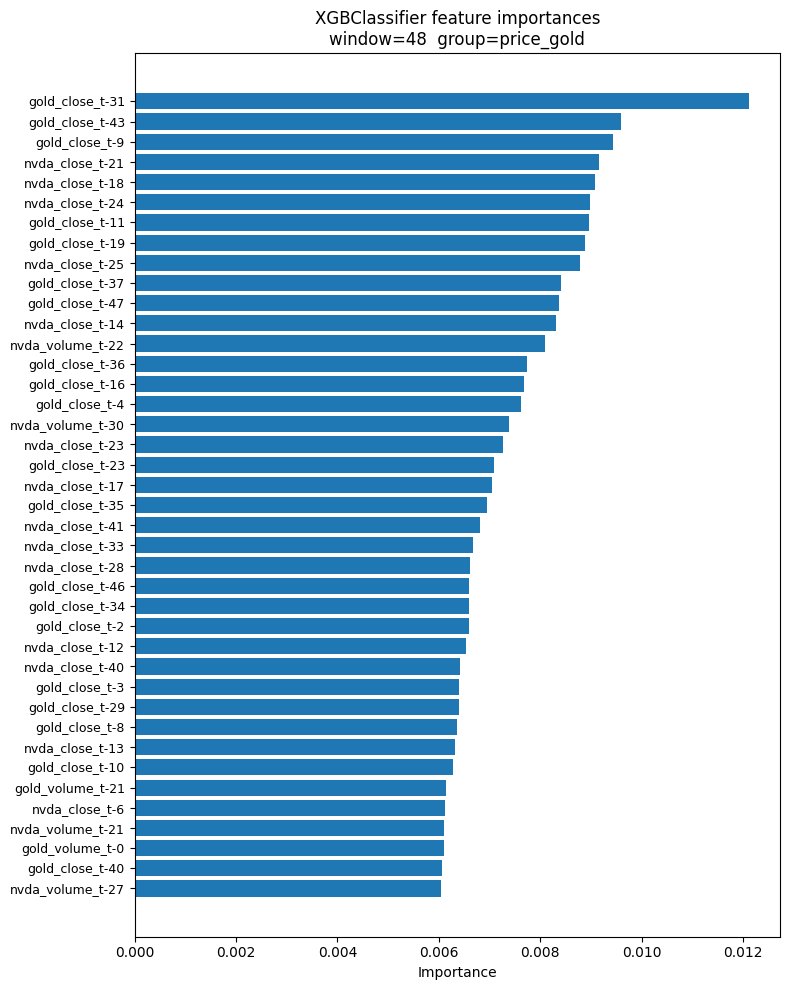

[saved] models/feature_importances\fi_w48_price_gold_LGBMClassifier.png


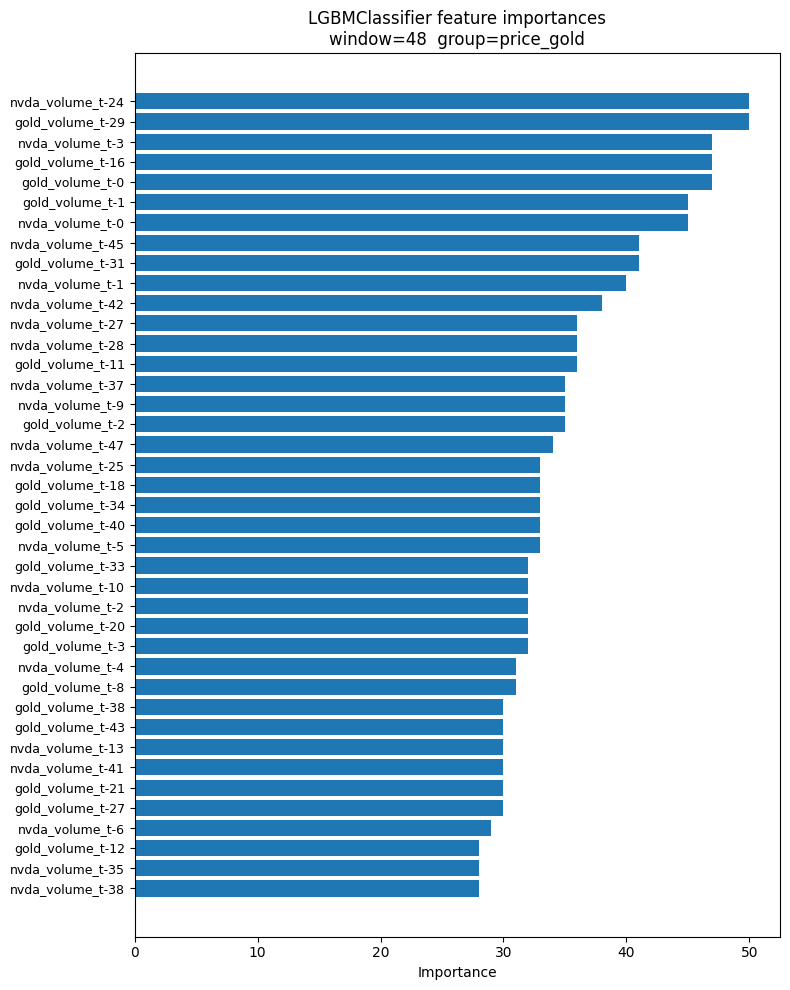

[saved] models/feature_importances\fi_w48_price_all_stocks_RandomForestClassifier.png


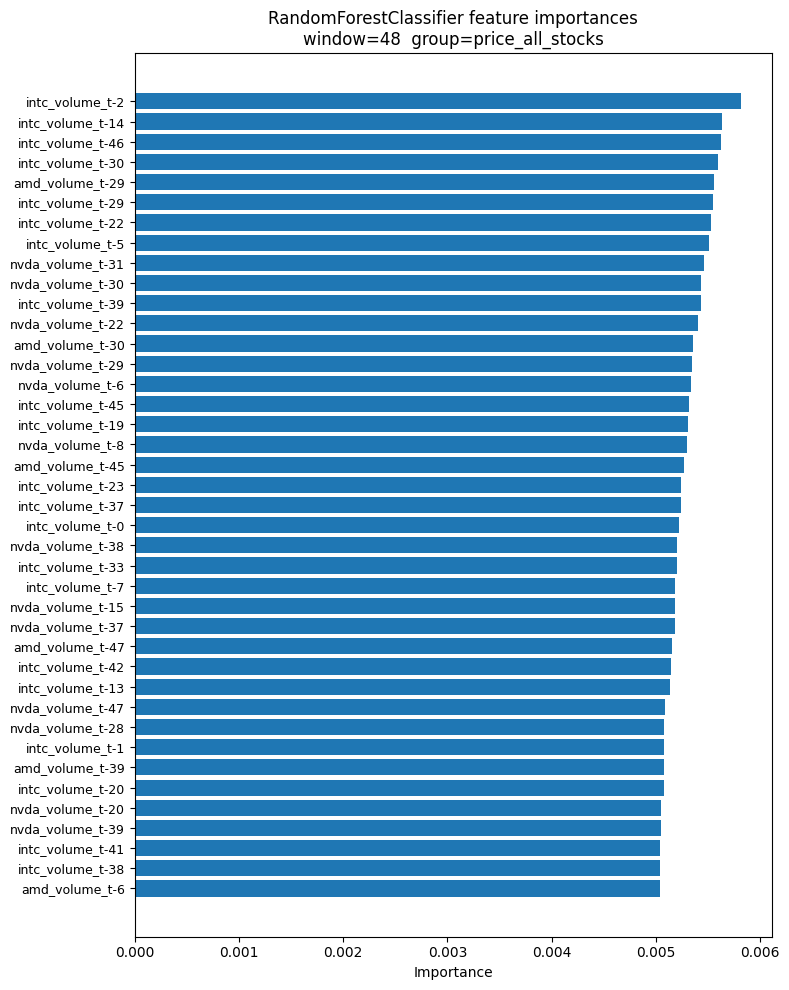

[saved] models/feature_importances\fi_w48_price_all_stocks_XGBClassifier.png


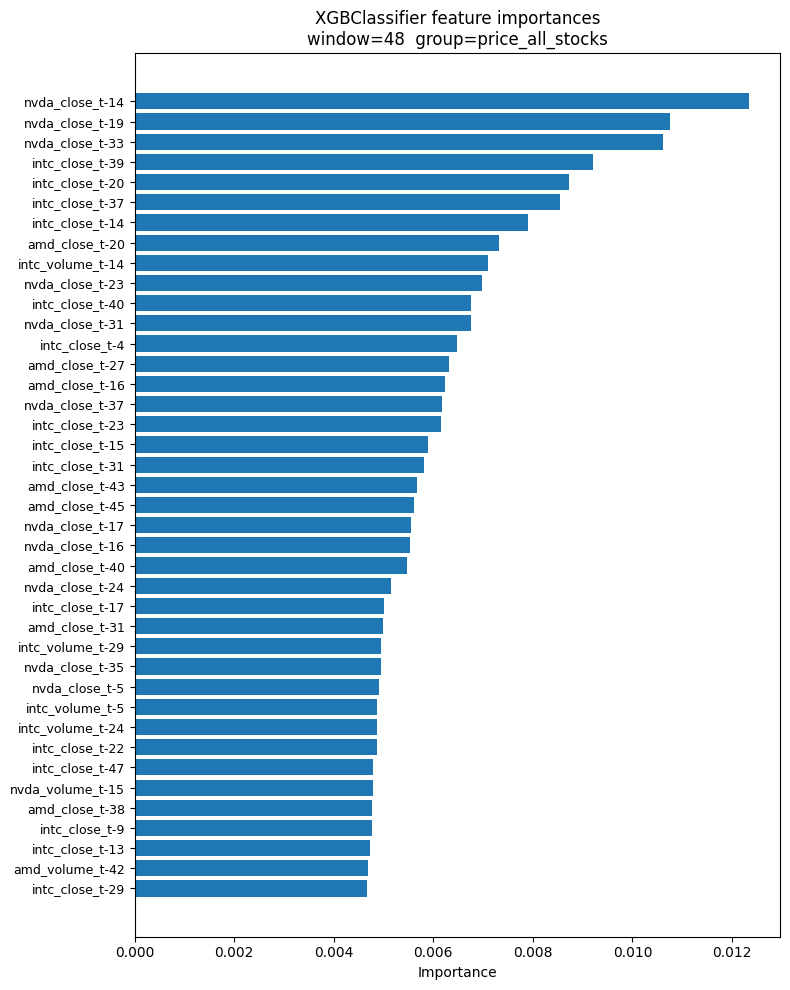

[saved] models/feature_importances\fi_w48_price_all_stocks_LGBMClassifier.png


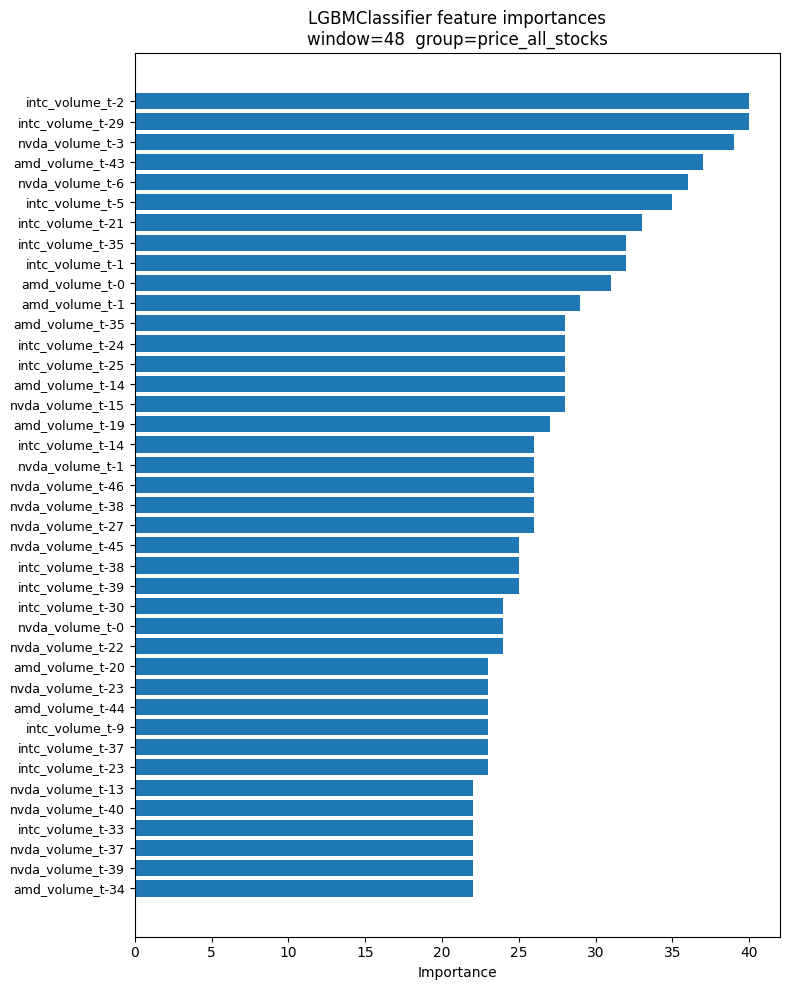

[saved] models/feature_importances\fi_w48_price_all_etf_RandomForestClassifier.png


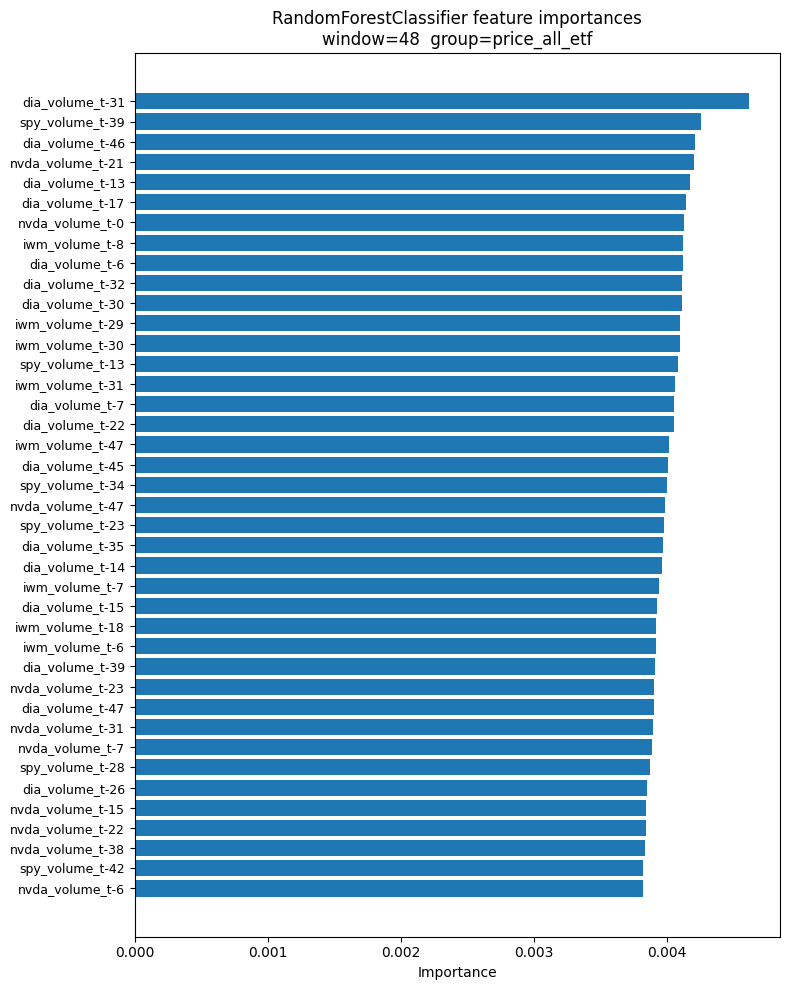

[saved] models/feature_importances\fi_w48_price_all_etf_XGBClassifier.png


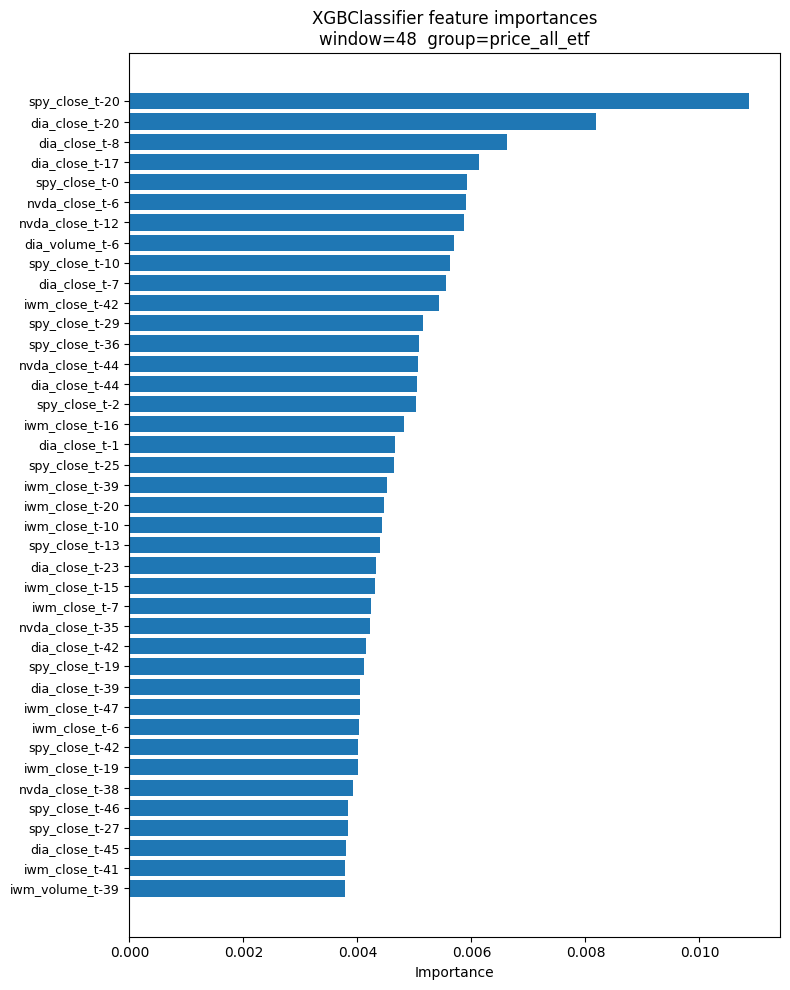

[saved] models/feature_importances\fi_w48_price_all_etf_LGBMClassifier.png


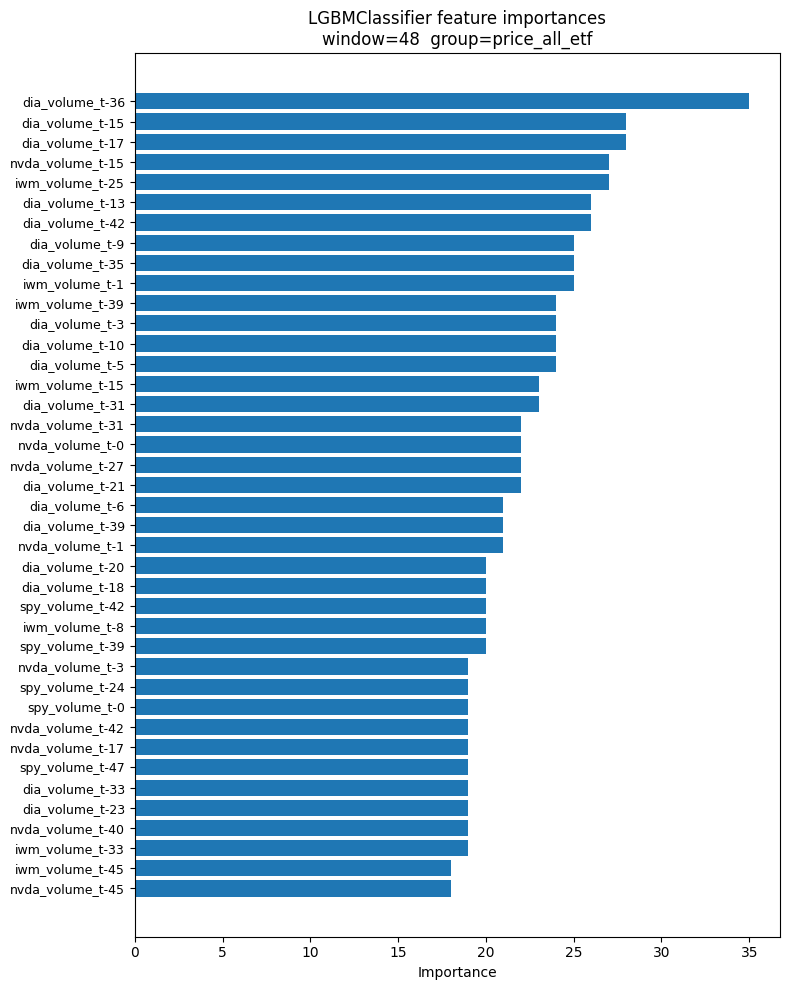

[saved] models/feature_importances\fi_w48_price_all_alt_RandomForestClassifier.png


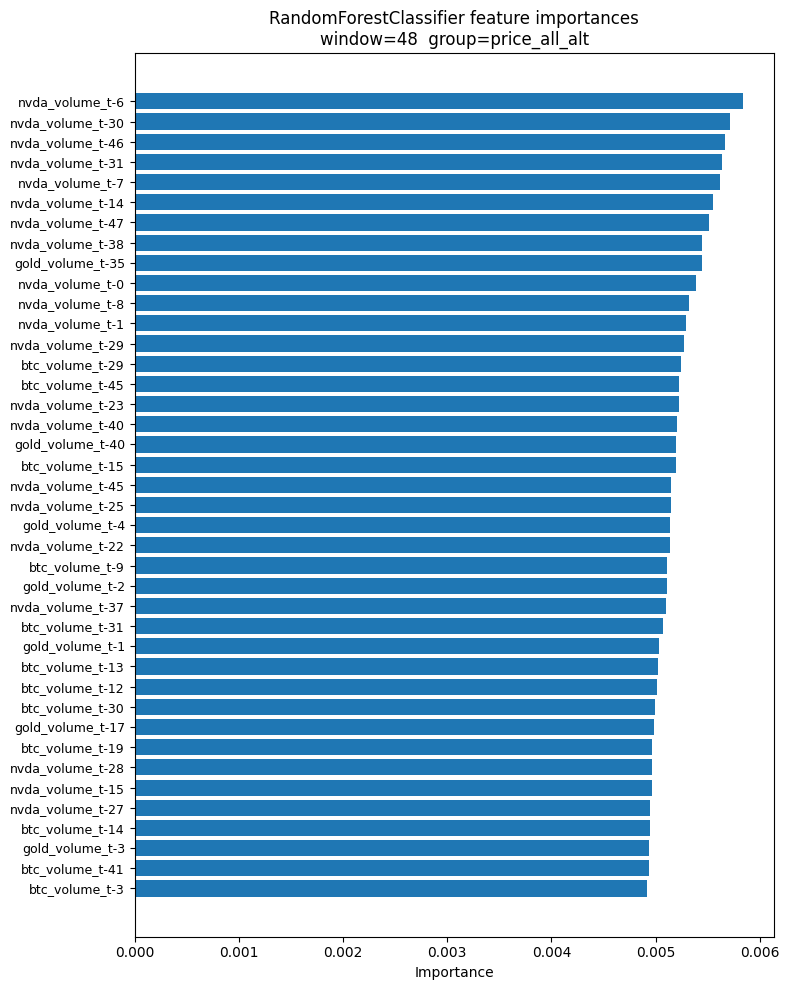

[saved] models/feature_importances\fi_w48_price_all_alt_XGBClassifier.png


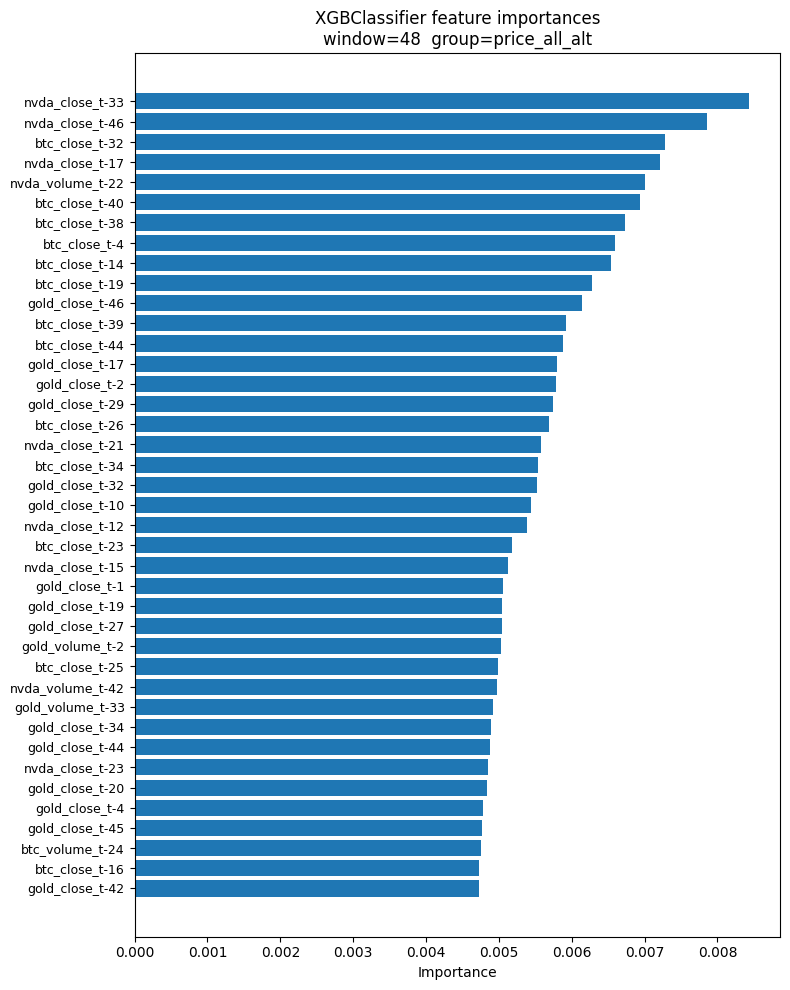

[saved] models/feature_importances\fi_w48_price_all_alt_LGBMClassifier.png


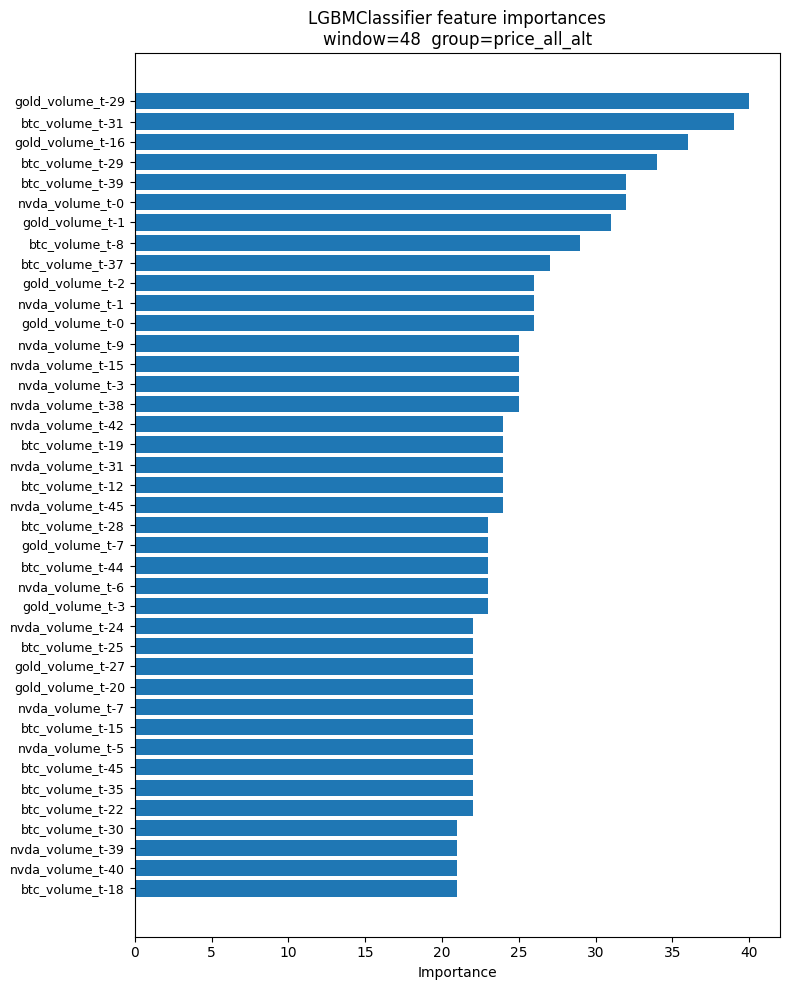

[saved] models/feature_importances\fi_w48_price_all_market_RandomForestClassifier.png


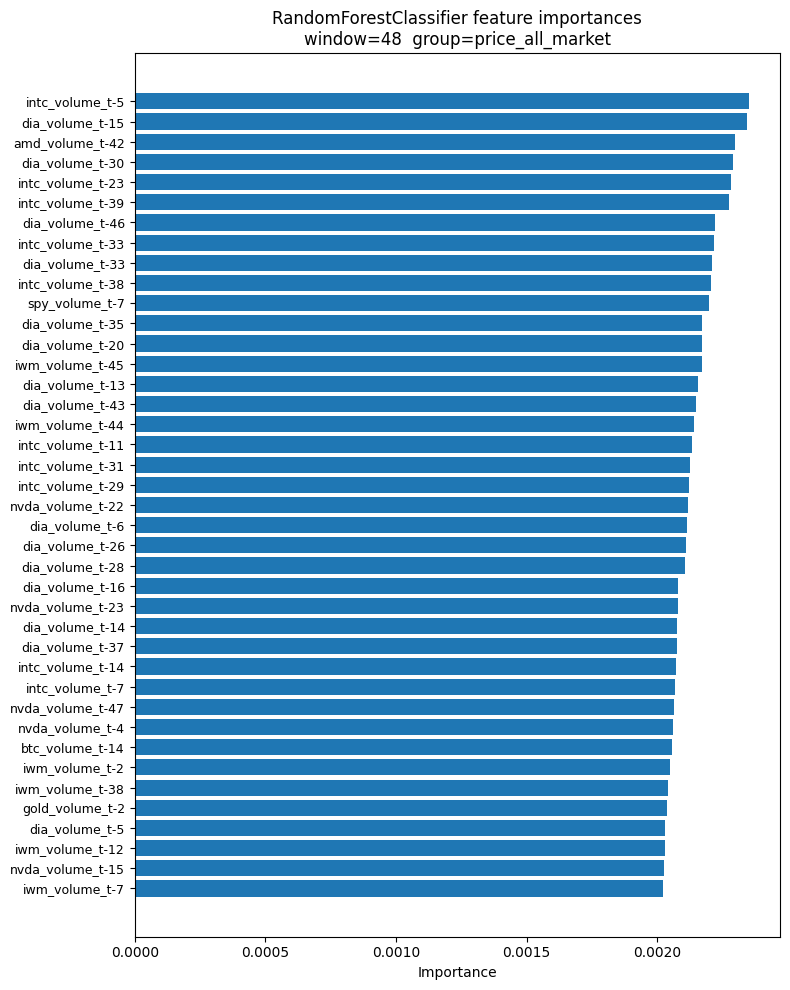

[saved] models/feature_importances\fi_w48_price_all_market_XGBClassifier.png


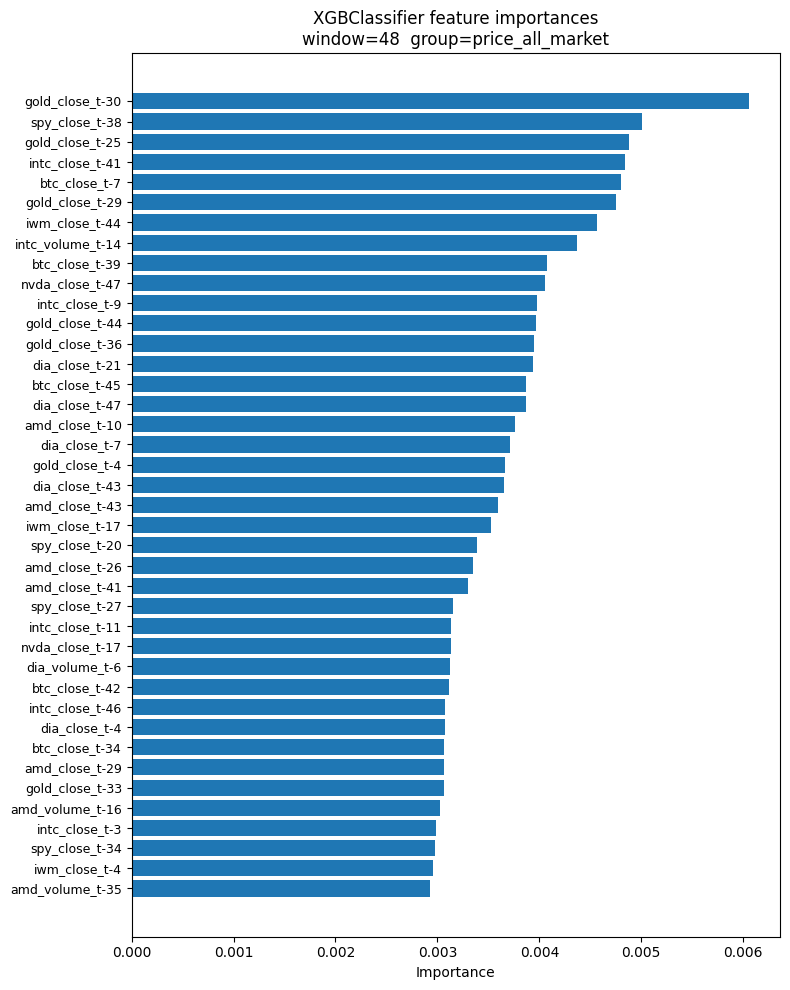

[saved] models/feature_importances\fi_w48_price_all_market_LGBMClassifier.png


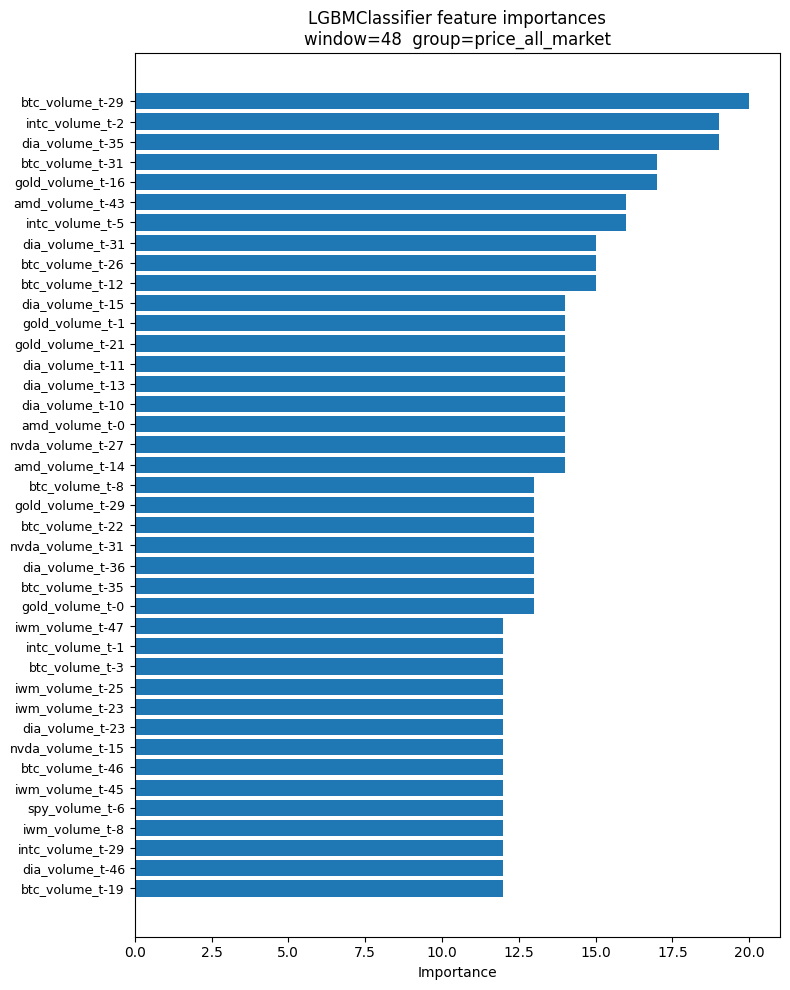

In [55]:
# feature_importances_plot.py
# Paste-ready script to plot top-N feature importances for RF/XGB/LGBM (and linear coef_ fallback)
# Assumes you already have: `pipelines_loaded`, `COLS_GROUPS`, and `generate_column_names` in scope.

import os
import numpy as np
import matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
TARGET_MODELS = {"RandomForestClassifier", "XGBClassifier", "LGBMClassifier"}
TOP_N = 40
OUT_DIR = "models/feature_importances"
os.makedirs(OUT_DIR, exist_ok=True)
SAVE_FIGS = True  # set False if you only want to show, not save
IMPORTANCE_TYPE_XGB = "gain"  # choices: "weight","gain","cover","total_gain","total_cover"
PREPROCESSOR_STEP_NAME = "preprocessor"  # change if your pipeline uses a different name
CLASSIFIER_STEP_NAME = "classifier"  # change if your pipeline uses a different name
# ------------------------------------------------


def _safe_get_feature_names_out(obj):
    """Return obj.get_feature_names_out() if available, else None."""
    try:
        if hasattr(obj, "get_feature_names_out"):
            return obj.get_feature_names_out()
    except Exception:
        pass
    return None


def get_feature_names_from_pipeline(pipe, fallback_names):
    """
    Best-effort feature name recovery:
    - pipeline.get_feature_names_out()
    - pipeline.named_steps['preprocessor'].get_feature_names_out()
    - fallback provided by caller (e.g., your generate_column_names)
    """
    names = _safe_get_feature_names_out(pipe)
    if names is not None:
        return np.asarray(names, dtype=object)

    pre = None
    try:
        pre = getattr(pipe, "named_steps", {}).get(PREPROCESSOR_STEP_NAME, None)
    except Exception:
        pre = None

    if pre is not None:
        names = _safe_get_feature_names_out(pre)
        if names is not None:
            return np.asarray(names, dtype=object)

    return np.asarray(fallback_names, dtype=object)


def unwrap_ovr_importances(estimator):
    """
    If estimator is an OneVsRest-like wrapper with `estimators_`,
    average per-class importances/coefficients into a single vector.
    Returns None if it can't extract.
    """
    ests = getattr(estimator, "estimators_", None)
    if not ests:
        return None

    stacks = []
    for est in ests:
        if hasattr(est, "feature_importances_"):
            stacks.append(np.asarray(est.feature_importances_, dtype=float).ravel())
        elif hasattr(est, "coef_"):
            coef = np.asarray(est.coef_, dtype=float)
            stacks.append(np.abs(coef).ravel() if coef.ndim == 1 else np.mean(np.abs(coef), axis=0).ravel())
    if stacks:
        return np.mean(np.vstack(stacks), axis=0)

    return None


def extract_importances(clf, feature_names, model_name):
    """
    Returns a 1D numpy array of importances aligned to feature_names,
    or None if not available.
    """
    # Native tree-based importances
    if hasattr(clf, "feature_importances_"):
        return np.asarray(clf.feature_importances_, dtype=float).ravel()

    # Linear models: use |coef_|
    if hasattr(clf, "coef_"):
        coef = np.asarray(clf.coef_, dtype=float)
        return np.abs(coef).ravel() if coef.ndim == 1 else np.mean(np.abs(coef), axis=0).ravel()

    # One-vs-Rest wrappers
    ovr = unwrap_ovr_importances(clf)
    if ovr is not None:
        return ovr

    # XGBoost booster fallback with named mapping when possible
    if model_name == "XGBClassifier" and hasattr(clf, "get_booster"):
        try:
            booster = clf.get_booster()
            score = booster.get_score(importance_type=IMPORTANCE_TYPE_XGB)  # dict: {feature_name_or_fi: score}
            vals = np.zeros(len(feature_names), dtype=float)

            # Prefer mapping by name if booster has feature_names
            booster_names = getattr(booster, "feature_names", None)
            if booster_names is not None and len(booster_names) == len(feature_names):
                # Map booster feature names -> index in our feature_names
                idx_map = {name: i for i, name in enumerate(feature_names)}
                for k, v in score.items():
                    i = idx_map.get(k, None)
                    if i is not None:
                        vals[i] = float(v)
            else:
                # Fallback: map f0,f1,... -> index
                for k, v in score.items():
                    if isinstance(k, str) and k.startswith("f"):
                        try:
                            i = int(k[1:])
                            if 0 <= i < len(vals):
                                vals[i] = float(v)
                        except ValueError:
                            pass
            return vals
        except Exception:
            return None

    return None


def get_final_estimator(pipeline_or_estimator):
    """Return the final estimator from a sklearn Pipeline or passthrough the estimator."""
    pipe = pipeline_or_estimator
    # Try standard named step
    try:
        if hasattr(pipe, "named_steps") and CLASSIFIER_STEP_NAME in pipe.named_steps:
            return pipe.named_steps[CLASSIFIER_STEP_NAME]
    except Exception:
        pass

    # Try last step
    if hasattr(pipe, "steps") and pipe.steps:
        return pipe.steps[-1][1]

    # Already an estimator
    return pipe


def plot_top_importances(model_name, window_size, col_group_name, feature_names, importances, top_n=TOP_N):
    """Plot and optionally save the top-N feature importances."""
    if len(importances) != len(feature_names):
        raise ValueError(
            f"Length mismatch: importances={len(importances)} vs feature_names={len(feature_names)}. "
            "Fix feature-name generation or pipeline feature extraction."
        )

    if np.all(importances == 0):
        print(f"[skip] All importances zero for {model_name} | window={window_size} | group={col_group_name}")
        return

    idx_sorted = np.argsort(importances)[::-1][:top_n]
    top_feats = [str(feature_names[i]) for i in idx_sorted]
    top_vals = importances[idx_sorted]

    plt.figure(figsize=(8, max(4, 0.25 * len(top_feats))))
    y = np.arange(len(top_feats))
    # reverse so the largest is on top
    plt.barh(y, top_vals[::-1], align="center")
    plt.yticks(y, top_feats[::-1], fontsize=9)
    plt.xlabel("Importance")
    plt.title(f"{model_name} feature importances\nwindow={window_size}  group={col_group_name}")
    plt.tight_layout()

    # Save + show
    fname = os.path.join(OUT_DIR, f"fi_w{window_size}_{col_group_name}_{model_name}.png")
    if SAVE_FIGS:
        try:
            plt.savefig(fname, dpi=150)
            print(f"[saved] {fname}")
        except Exception as e:
            print(f"[warn] Failed to save {fname}: {e}")
    plt.show()
    plt.close()


def run_plots(pipelines_loaded):
    """
    Main loop to iterate your loaded pipelines and plot importances.
    Expects pipelines_loaded keyed by (window_size, col_group_name, model_name).
    """
    for (window_size, col_group_name, model_name), pipeline in pipelines_loaded.items():
        if model_name not in TARGET_MODELS:
            continue

        # Build fallback feature names (your project-specific generator)
        base_cols = None
        try:
            base_cols = COLS_GROUPS.get(col_group_name)
        except Exception:
            pass

        if base_cols is None:
            print(f"[warn] COLS_GROUPS has no entry for group '{col_group_name}'. Using empty base cols.")
            base_cols = []

        try:
            fallback_names = generate_column_names(base_cols, window_size)
        except Exception:
            # last-ditch fallback to numbered names if your helper isn't available
            fallback_names = [f"f{i}" for i in range(10000)]

        # Prefer names coming out of the pipeline/preprocessor if possible
        feature_names = get_feature_names_from_pipeline(pipeline, fallback_names)

        # Get the trained classifier
        clf = get_final_estimator(pipeline)

        # Extract importances
        importances = extract_importances(clf, feature_names, model_name)

        if importances is None:
            print(f"[skip] {model_name} | window={window_size} | group={col_group_name}: no importances available")
            continue

        # Hard fail on length mismatch to surface preprocessing/name bugs
        if len(importances) != len(feature_names):
            raise ValueError(
                f"Length mismatch for ({model_name}, window={window_size}, group={col_group_name}): "
                f"importances={len(importances)} vs features={len(feature_names)}"
            )

        # Plot/save
        plot_top_importances(model_name, window_size, col_group_name, feature_names, importances, top_n=TOP_N)


# -------------------- ENTRY --------------------
# Call run_plots(pipelines_loaded) after you have pipelines_loaded in memory.
# Example:
run_plots(pipelines_loaded)
